Rosenbrock synthetic function:

GP ERM versus STP nu = 3 ERM (winner)

https://www.sfu.ca/~ssurjano/rosen.html

In [1]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
### Inputs:

obj_func = 'Rosenbrock'
n_test = 50 # test points
df = 3 # nu

util_loser = 'RegretMinimized'
util_winner = 'tRegretMinimized'
n_init = 5 # random initialisations

cov_func = squaredExponential()


In [3]:
### Objective function:

if obj_func == 'Rosenbrock':
            
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -2.048 
    ub = +2.048 
    
# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
    max_iter = (10 * dim)*0 + 100  # iterations of Bayesian optimisation
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))
    
    def f_syn_polarity(x1_training, x2_training):
        return operator * (100 * (x2_training - x1_training ** 2) ** 2 + (x1_training - 1) ** 2)


In [4]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [5]:
### Set-seeds:

run_num_1 = 111
run_num_2 = 113
run_num_3 = 3333
run_num_4 = 444
run_num_5 = 5555
run_num_6 = 6
run_num_7 = 777
run_num_8 = 887
run_num_9 = 99
run_num_10 = 1000
run_num_11 = 1113
run_num_12 = 1234
run_num_13 = 2345
run_num_14 = 88
run_num_15 = 1556
run_num_16 = 1666
run_num_17 = 717
run_num_18 = 8
run_num_19 = 1998
run_num_20 = 2000


In [6]:
### Acquisition function - ERM:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'RegretMinimized': self.RegretMinimized,
            'tRegretMinimized': self.tRegretMinimized
        }

        self.f = mode_dict[mode]
   
    def RegretMinimized(self, tau, mean, std):
        
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return z * (std + self.eps) * norm.cdf(z) + (std + self.eps) * norm.pdf(z)[0]
    
    def tRegretMinimized(self, tau, mean, std, nu=3.0):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + (std + self.eps) * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)
    

In [7]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_loser_1 = GaussianProcess(cov_func)

loser_1 = GPGO(surrogate_loser_1, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.45944904 -1.35549029]. 	  -245.71064611316496 	 -108.5713485785257
init   	 [-0.26190226  1.10289909]. 	  -108.5713485785257 	 -108.5713485785257
init   	 [-0.83834755 -1.43702853]. 	  -461.2775269355244 	 -108.5713485785257
init   	 [-1.95592878 -0.32676048]. 	  -1732.9949421003257 	 -108.5713485785257
init   	 [-1.07035795 -0.66496024]. 	  -332.12317010404104 	 -108.5713485785257
1      	 [-0.22246619 -0.23774559]. 	  -9.744921046208802 	 -9.744921046208802
2      	 [-0.44259375 -0.41212289]. 	  -39.0489503873149 	 -9.744921046208802
3      	 [ 1.38387448 -0.09997246]. 	  -406.2025216458289 	 -9.744921046208802
4      	 [-0.16665514  0.08681738]. 	  -1.7096970021626978 	 -1.7096970021626978
5      	 [ 1.53746021 -2.048     ]. 	  -1946.6725713151652 	 -1.7096970021626978
6      	 [0.0419833  0.29493492]. 	  -9.512796927906653 	 -1.7096970021626978
7      	 [ 1.78803192 -0.60648493]. 	  -1447.3149830671293 	 -1.7096

96     	 [-1.65372101 -1.45526157]. 	  -1762.698113551249 	 -0.0015649549045195304
97     	 [1.00007027 0.99805295]. 	  -0.00043581245498646804 	 -0.00043581245498646804
98     	 [ 1.72114382 -0.85529876]. 	  -1457.9536047382583 	 -0.00043581245498646804
99     	 [0.34268958 0.38226986]. 	  -7.445746616971624 	 -0.00043581245498646804
100    	 [-1.0954881   0.33887054]. 	  -78.56168510444935 	 -0.00043581245498646804


In [8]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_loser_2 = GaussianProcess(cov_func)

loser_2 = GPGO(surrogate_loser_2, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.44173258 -1.74529086]. 	  -1462.4037722675753 	 -1.3013277264983028
init   	 [ 1.6176405  -0.26012243]. 	  -828.0271838688934 	 -1.3013277264983028
init   	 [-1.525032    0.31071385]. 	  -412.40181251788414 	 -1.3013277264983028
init   	 [ 1.39456889 -0.26574622]. 	  -488.8170397507174 	 -1.3013277264983028
init   	 [0.80244966 0.75627765]. 	  -1.3013277264983028 	 -1.3013277264983028
1      	 [ 0.38382722 -0.20002744]. 	  -12.444925217581003 	 -1.3013277264983028
2      	 [0.74575449 0.06127072]. 	  -24.555167089118154 	 -1.3013277264983028
3      	 [0.86803262 1.82156653]. 	  -114.09816275934874 	 -1.3013277264983028
4      	 [ 0.46185146 -0.65999866]. 	  -76.5558415660385 	 -1.3013277264983028
5      	 [0.5105136  1.17310968]. 	  -83.5025837806539 	 -1.3013277264983028
6      	 [1.18411797 1.28058677]. 	  -1.5113054183090753 	 -1.3013277264983028
7      	 [0.96695624 1.09506056]. 	  -2.5628902934529054 	 -1.30132

96     	 [1.24293068 1.52543964]. 	  -0.09679515991743427 	 -0.0037764840180860245
97     	 [1.2432263  1.52651501]. 	  -0.09562714401257486 	 -0.0037764840180860245
98     	 [-1.20891657  0.77681768]. 	  -51.75546165606691 	 -0.0037764840180860245
99     	 [ 1.04183685 -0.83097723]. 	  -367.26112762398185 	 -0.0037764840180860245
100    	 [-0.67481668  0.98829967]. 	  -31.20560964966402 	 -0.0037764840180860245


In [9]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_loser_3 = GaussianProcess(cov_func)

loser_3 = GPGO(surrogate_loser_3, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.03045369 -1.60050678]. 	  -708.8071948417274 	 -1.118465165857483
init   	 [-0.05684724 -0.0006915 ]. 	  -1.118465165857483 	 -1.118465165857483
init   	 [ 0.64352256 -1.08181622]. 	  -223.90997740226942 	 -1.118465165857483
init   	 [ 0.46200787 -1.55790376]. 	  -314.05929962166397 	 -1.118465165857483
init   	 [ 0.86918061 -0.52199202]. 	  -163.20929387450548 	 -1.118465165857483
1      	 [-0.41275174 -0.97286658]. 	  -132.69348247966587 	 -1.118465165857483
2      	 [ 0.20874147 -0.31693142]. 	  -13.622434004259702 	 -1.118465165857483
3      	 [-0.49114702  1.07775462]. 	  -72.20163389946413 	 -1.118465165857483
4      	 [-0.16863905  0.31002998]. 	  -9.2950576707444 	 -1.118465165857483
5      	 [-0.50104472  0.20894064]. 	  -2.4304197416885485 	 -1.118465165857483
6      	 [-2.02343475  1.58463911]. 	  -638.9749977990072 	 -1.118465165857483
7      	 [-0.27229474  0.03287976]. 	  -1.789011151972603 	 -1.118465

97     	 [-1.25274348  1.20739645]. 	  -18.17706518631196 	 -0.011989492271941809
98     	 [-1.8188858  -2.01500327]. 	  -2841.750389796985 	 -0.011989492271941809
99     	 [0.28598232 1.17276022]. 	  -119.53232007701105 	 -0.011989492271941809
100    	 [ 1.94508247 -0.03896131]. 	  -1461.8963614633797 	 -0.011989492271941809


In [10]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_loser_4 = GaussianProcess(cov_func)

loser_4 = GPGO(surrogate_loser_4, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.39002285 1.31602418]. 	  -38.11488737154776 	 -12.122423820878506
init   	 [0.58248055 0.68494384]. 	  -12.122423820878506 	 -12.122423820878506
init   	 [-1.88768295 -1.7790059 ]. 	  -2862.4120613667637 	 -12.122423820878506
init   	 [-0.91545338 -0.75218738]. 	  -256.5560079635026 	 -12.122423820878506
init   	 [-1.25504548 -1.24070756]. 	  -797.98450090518 	 -12.122423820878506
1      	 [-0.00933519 -1.72218378]. 	  -297.64047024942215 	 -12.122423820878506
2      	 [0.55438246 1.26879645]. 	  -92.63844192618087 	 -12.122423820878506
3      	 [1.4102362 0.3572151]. 	  -266.3641717959405 	 -12.122423820878506
4      	 [2.048 2.048]. 	  -461.7603900415999 	 -12.122423820878506
5      	 [0.9509412  0.96688936]. 	  -0.3942852631873592 	 -0.3942852631873592
6      	 [0.74756226 0.81859824]. 	  -6.810674116298312 	 -0.3942852631873592
7      	 [ 1.73111495 -0.26146777]. 	  -1062.138680699351 	 -0.3942852631873592
8     

96     	 [ 1.35705638 -0.0890798 ]. 	  -372.880721250297 	 -0.0030098714087796576
97     	 [0.79248782 0.00551502]. 	  -38.79641589678887 	 -0.0030098714087796576
98     	 [-1.22520577  1.49539825]. 	  -4.954825042362605 	 -0.0030098714087796576
99     	 [-0.26276442  1.13854958]. 	  -115.97854910800217 	 -0.0030098714087796576
100    	 [ 1.28981407 -0.97803313]. 	  -697.9172874987738 	 -0.0030098714087796576


In [11]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_loser_5 = GaussianProcess(cov_func)

loser_5 = GPGO(surrogate_loser_5, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.23491901 0.17105153]. 	  -1.9278091788796494 	 -1.9278091788796494
init   	 [ 0.24749582 -0.48313101]. 	  -30.201785940713883 	 -1.9278091788796494
init   	 [-1.56019024  1.41721238]. 	  -109.97965348801837 	 -1.9278091788796494
init   	 [0.98198164 1.77093658]. 	  -65.06852657321838 	 -1.9278091788796494
init   	 [1.47180752 0.85239655]. 	  -172.83511538815276 	 -1.9278091788796494
1      	 [-0.20787038  0.38221562]. 	  -12.951425052058712 	 -1.9278091788796494
2      	 [-2.0143131  -1.31251332]. 	  -2892.7444960501225 	 -1.9278091788796494
3      	 [ 1.01950798 -1.24720923]. 	  -522.85696842208 	 -1.9278091788796494
4      	 [ 0.07100164 -0.05570017]. 	  -1.2319897893378482 	 -1.2319897893378482
5      	 [-0.31009759  1.36182696]. 	  -161.9075115269378 	 -1.2319897893378482
6      	 [1.84256052 1.9255108 ]. 	  -216.6583564474458 	 -1.2319897893378482
7      	 [-0.36629948 -0.2342708 ]. 	  -15.44202785243899 	 -1.23

97     	 [ 1.8800602  -0.87843687]. 	  -1948.2872100578213 	 -0.015546421776397694
98     	 [-1.81468614  1.5420402 ]. 	  -314.5385193068393 	 -0.015546421776397694
99     	 [-0.74573766  0.83727171]. 	  -10.951966768460675 	 -0.015546421776397694
100    	 [-0.72720043 -1.80539374]. 	  -547.8388160624896 	 -0.015546421776397694


In [12]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_loser_6 = GaussianProcess(cov_func)

loser_6 = GPGO(surrogate_loser_6, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.60915518 -0.68821072]. 	  -1074.6314195925434 	 -3.0269049669752817
init   	 [ 1.31575449 -1.87721062]. 	  -1302.169546932896 	 -3.0269049669752817
init   	 [-1.60703824  0.38933325]. 	  -487.8262244570432 	 -3.0269049669752817
init   	 [ 0.12213192 -0.33256477]. 	  -12.844955340992902 	 -3.0269049669752817
init   	 [-0.67416945  0.50183959]. 	  -3.0269049669752817 	 -3.0269049669752817
1      	 [-0.00884268  0.57735456]. 	  -34.3425644814277 	 -3.0269049669752817
2      	 [-0.41056426 -0.32434024]. 	  -26.285052479462937 	 -3.0269049669752817
3      	 [-0.18259276  0.05642632]. 	  -1.451822910191488 	 -1.451822910191488
4      	 [-0.69918937  1.52001968]. 	  -109.21508306962447 	 -1.451822910191488
5      	 [-0.49491752  0.74319853]. 	  -27.06060131172997 	 -1.451822910191488
6      	 [1.25253705 1.38194386]. 	  -3.5571302781407854 	 -1.451822910191488
7      	 [0.94735483 0.96480224]. 	  -0.4559842442259708 	 -0.4

97     	 [-1.51158698 -1.05923967]. 	  -1124.6318739826365 	 -0.004108453769549359
98     	 [-1.21562782 -1.17840815]. 	  -710.4271513891267 	 -0.004108453769549359
99     	 [0.95872571 0.92954807]. 	  -0.01250519048231594 	 -0.004108453769549359
100    	 [-1.45895949 -1.65195926]. 	  -1435.2811721917542 	 -0.004108453769549359


In [13]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_loser_7 = GaussianProcess(cov_func)

loser_7 = GPGO(surrogate_loser_7, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.42268934 -0.80954733]. 	  -808.7939502616841 	 -2.0077595729598063
init   	 [-1.79389885 -0.16441204]. 	  -1151.9264213711547 	 -2.0077595729598063
init   	 [1.37319786 1.74897991]. 	  -2.0077595729598063 	 -2.0077595729598063
init   	 [0.92974688 1.09976052]. 	  -5.543015908052858 	 -2.0077595729598063
init   	 [-0.94533605  0.58994398]. 	  -13.008689168416776 	 -2.0077595729598063
1      	 [-0.47273281  1.16874249]. 	  -91.52175707418381 	 -2.0077595729598063
2      	 [-0.02450474  0.04538531]. 	  -1.2501780197199097 	 -1.2501780197199097
3      	 [1.68585264 0.78240463]. 	  -424.70453514476327 	 -1.2501780197199097
4      	 [-0.42007355  0.486865  ]. 	  -11.651624457822306 	 -1.2501780197199097
5      	 [-1.44885198  1.39505365]. 	  -55.57515125944981 	 -1.2501780197199097
6      	 [ 0.24875508 -1.16743118]. 	  -151.68474322135503 	 -1.2501780197199097
7      	 [0.93084749 2.03834578]. 	  -137.33241456947934 	 -1

96     	 [-1.20940169 -1.15883084]. 	  -692.0989167941194 	 -0.0007922403871347229
97     	 [1.36083287 1.87749507]. 	  -0.1958847502149283 	 -0.0007922403871347229
98     	 [0.63313443 0.41442596]. 	  -0.15299603144374702 	 -0.0007922403871347229
99     	 [1.14033305 1.29017386]. 	  -0.03006803698557653 	 -0.0007922403871347229
100    	 [-0.54071186  1.67082572]. 	  -192.38799757088222 	 -0.0007922403871347229


In [14]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_loser_8 = GaussianProcess(cov_func)

loser_8 = GPGO(surrogate_loser_8, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.59948851 -1.8750873 ]. 	  -1972.3059423071145 	 -7.238275380208551
init   	 [ 0.40834083 -0.81972959]. 	  -97.66272647293047 	 -7.238275380208551
init   	 [ 1.21492186 -0.54806067]. 	  -409.7425700197761 	 -7.238275380208551
init   	 [ 1.55897178 -0.82804067]. 	  -1062.051446884513 	 -7.238275380208551
init   	 [-0.69999303  0.28146449]. 	  -7.238275380208551 	 -7.238275380208551
1      	 [0.6164745  0.32466281]. 	  -0.45376407586037554 	 -0.45376407586037554
2      	 [ 0.50908955 -0.18347256]. 	  -19.834429029373293 	 -0.45376407586037554
3      	 [-1.32333068  0.93303667]. 	  -72.33765762594129 	 -0.45376407586037554
4      	 [1.44508292 0.8206238 ]. 	  -160.8894336881283 	 -0.45376407586037554
5      	 [-0.62676042  0.76344834]. 	  -16.382247344473406 	 -0.45376407586037554
6      	 [-1.032139    0.43005276]. 	  -44.48488220039099 	 -0.45376407586037554
7      	 [-2.048  2.048]. 	  -469.9523900415999 	 -0.4537640

96     	 [-2.01567355 -0.66988734]. 	  -2249.0596095799283 	 -0.029616457175806413
97     	 [ 2.02019527 -1.57878686]. 	  -3204.5733881370375 	 -0.029616457175806413
98     	 [-0.03460129  1.98045929]. 	  -392.81822179015063 	 -0.029616457175806413
99     	 [-0.05600739 -1.1276132 ]. 	  -128.97471474266496 	 -0.029616457175806413
100    	 [1.18931045 1.35118693]. 	  -0.43617834160686086 	 -0.029616457175806413


In [15]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_loser_9 = GaussianProcess(cov_func)

loser_9 = GPGO(surrogate_loser_9, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.70565298 -0.04883088]. 	  -29.9831488845538 	 -29.9831488845538
init   	 [ 1.33322823 -1.9191956 ]. 	  -1366.6650412963722 	 -29.9831488845538
init   	 [1.26177265 0.26876895]. 	  -175.18114988457984 	 -29.9831488845538
init   	 [-0.82893825 -1.85673433]. 	  -650.4739702903224 	 -29.9831488845538
init   	 [ 2.00960983 -2.0200418 ]. 	  -3671.650548034952 	 -29.9831488845538
1      	 [ 0.43606844 -1.67369118]. 	  -347.71053213071485 	 -29.9831488845538
2      	 [-0.13839446  0.7147904 ]. 	  -49.68707676672544 	 -29.9831488845538
3      	 [-1.8510361   2.03742245]. 	  -201.03611268756 	 -29.9831488845538
4      	 [ 1.36280034 -0.74164998]. 	  -675.5466126021265 	 -29.9831488845538
5      	 [0.42078817 0.31547559]. 	  -2.2512996056908405 	 -2.2512996056908405
6      	 [-1.19704929  0.13798041]. 	  -172.5156939449146 	 -2.2512996056908405
7      	 [-1.33704579  1.04920576]. 	  -59.99789396651467 	 -2.2512996056908405
8  

98     	 [0.64266637 0.42010077]. 	  -0.13270096373467086 	 -0.00976080774599615
99     	 [-0.45261262  0.90300121]. 	  -50.85045173697143 	 -0.00976080774599615
100    	 [ 1.19856704 -0.13210183]. 	  -246.11034989199715 	 -0.00976080774599615


In [16]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_loser_10 = GaussianProcess(cov_func)

loser_10 = GPGO(surrogate_loser_10, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.62910294 -1.57693156]. 	  -389.29291138113445 	 -8.580376531587937
init   	 [ 1.84435861 -0.07294402]. 	  -1207.999341247548 	 -8.580376531587937
init   	 [ 1.5256557  -1.17828534]. 	  -1229.4172568797705 	 -8.580376531587937
init   	 [-1.88125338 -0.42109149]. 	  -1576.6245828972787 	 -8.580376531587937
init   	 [-1.09309052  1.39977001]. 	  -8.580376531587937 	 -8.580376531587937
1      	 [-0.85767015  2.048     ]. 	  -175.69081547649077 	 -8.580376531587937
2      	 [-0.5337917   1.15217037]. 	  -77.5624817749036 	 -8.580376531587937
3      	 [-1.87496607  1.74203438]. 	  -322.7826713148287 	 -8.580376531587937
4      	 [-0.02273896 -1.98197652]. 	  -394.07407427702145 	 -8.580376531587937
5      	 [-0.45198894  1.79927878]. 	  -256.50591736736254 	 -8.580376531587937
6      	 [1.82395491 1.22407741]. 	  -442.82797197898645 	 -8.580376531587937
7      	 [0.76191163 0.20393692]. 	  -14.237364089085258 	 -8.5803765

96     	 [-0.81057464  1.07467568]. 	  -20.720868440719848 	 -0.002080999024356565
97     	 [-0.79374399  1.80956559]. 	  -142.348050764057 	 -0.002080999024356565
98     	 [-0.65314311 -0.35198627]. 	  -63.351906424072624 	 -0.002080999024356565
99     	 [ 1.97285981 -1.2448696 ]. 	  -2639.870017628281 	 -0.002080999024356565
100    	 [2.01579377 0.71686644]. 	  -1120.9769394817645 	 -0.002080999024356565


In [17]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_loser_11 = GaussianProcess(cov_func)

loser_11 = GPGO(surrogate_loser_11, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.97032207 1.31583119]. 	  -659.5505379977991 	 -45.00854175284071
init   	 [ 0.59758024 -0.3125739 ]. 	  -45.00854175284071 	 -45.00854175284071
init   	 [-1.21933423 -0.03314987]. 	  -235.94289844157058 	 -45.00854175284071
init   	 [-1.48046507 -0.19447384]. 	  -575.5719351651762 	 -45.00854175284071
init   	 [-1.58214297 -2.0360213 ]. 	  -2067.0989998073865 	 -45.00854175284071
1      	 [-0.59060318  0.68440247]. 	  -13.792107070246617 	 -13.792107070246617
2      	 [-0.43261271  0.05287406]. 	  -3.8554828095625155 	 -3.8554828095625155
3      	 [-1.09092491  0.68223928]. 	  -30.165961943368167 	 -3.8554828095625155
4      	 [ 1.36856297 -1.03958351]. 	  -848.4294834321007 	 -3.8554828095625155
5      	 [0.52611459 0.12330121]. 	  -2.580649747779165 	 -2.580649747779165
6      	 [ 0.39211637 -1.33428971]. 	  -221.7973022262781 	 -2.580649747779165
7      	 [-0.76397583  0.37859956]. 	  -7.316550643665399 	 -2.58064

96     	 [0.11221832 0.17690602]. 	  -3.488034753685005 	 -0.04106571157579786
97     	 [ 1.53115004 -0.15748759]. 	  -626.2364977558283 	 -0.04106571157579786
98     	 [-0.04377054  1.07377422]. 	  -115.97749058569023 	 -0.04106571157579786
99     	 [-1.07275224  1.30988671]. 	  -6.8272437195548115 	 -0.04106571157579786
100    	 [ 1.99729274 -0.68967908]. 	  -2190.1652376019097 	 -0.04106571157579786


In [18]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_loser_12 = GaussianProcess(cov_func)

loser_12 = GPGO(surrogate_loser_12, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.26353633  0.50015753]. 	  -125.32555445527122 	 -19.52113145175031
init   	 [-0.25506718  1.16882876]. 	  -123.40590278793995 	 -19.52113145175031
init   	 [ 1.14678091 -0.93146069]. 	  -504.72793807789463 	 -19.52113145175031
init   	 [-0.91560241  1.23646844]. 	  -19.52113145175031 	 -19.52113145175031
init   	 [1.87653879 1.53982007]. 	  -393.43336554061835 	 -19.52113145175031
1      	 [-1.3787018  2.048    ]. 	  -7.824456843181751 	 -7.824456843181751
2      	 [-1.16736243  1.64664033]. 	  -12.75768117752235 	 -7.824456843181751
3      	 [-0.82476779  1.48115298]. 	  -67.47563363670153 	 -7.824456843181751
4      	 [-2.048       1.85692053]. 	  -555.6264525326193 	 -7.824456843181751
5      	 [-0.12642315  0.45531769]. 	  -20.57034283559652 	 -7.824456843181751
6      	 [-1.19370865 -1.3207978 ]. 	  -758.720153086171 	 -7.824456843181751
7      	 [0.49818184 1.06984657]. 	  -67.76457057592293 	 -7.8244568431817

96     	 [ 0.21458814 -1.62712584]. 	  -280.5679665819224 	 -0.0026711546260692227
97     	 [1.00421244 1.90356606]. 	  -80.12461242201168 	 -0.0026711546260692227
98     	 [1.29858931 1.68016183]. 	  -0.09296537477530241 	 -0.0026711546260692227
99     	 [-1.00773153 -1.93180522]. 	  -872.7052511651193 	 -0.0026711546260692227
100    	 [-0.43163006 -0.55778265]. 	  -57.41613508491781 	 -0.0026711546260692227


In [19]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_loser_13 = GaussianProcess(cov_func)

loser_13 = GPGO(surrogate_loser_13, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.65799909 -0.35389173]. 	  -62.0309701572776 	 -62.0309701572776
init   	 [ 0.68854808 -1.10615174]. 	  -249.81607110978882 	 -62.0309701572776
init   	 [1.26025046 0.56040843]. 	  -105.7097019264073 	 -62.0309701572776
init   	 [-1.34269398 -0.98145948]. 	  -780.713409392333 	 -62.0309701572776
init   	 [ 1.70115068 -0.15230767]. 	  -928.4380405275942 	 -62.0309701572776
1      	 [0.37995778 0.83552072]. 	  -48.153672694682946 	 -48.153672694682946
2      	 [1.55860765 1.62153229]. 	  -65.55409148154004 	 -48.153672694682946
3      	 [0.46023823 0.17397552]. 	  -0.43455737399098016 	 -0.43455737399098016
4      	 [0.95160054 1.01537238]. 	  -1.2085789839255758 	 -0.43455737399098016
5      	 [-1.08607807  2.048     ]. 	  -79.76955836944353 	 -0.43455737399098016
6      	 [0.76140714 0.61041897]. 	  -0.15104134638093003 	 -0.15104134638093003
7      	 [1.00337308 0.90654961]. 	  -1.004174379817866 	 -0.15104134638093

98     	 [-1.10398428  1.61088889]. 	  -19.801586554812506 	 -0.0105007464795961
99     	 [1.0275188  1.04328329]. 	  -0.016411293445117516 	 -0.0105007464795961
100    	 [2.0161086 1.2859591]. 	  -773.1691858866905 	 -0.0105007464795961


In [20]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_loser_14 = GaussianProcess(cov_func)

loser_14 = GPGO(surrogate_loser_14, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.6043691  0.02928512]. 	  -11.444570460525577 	 -4.306489127802793
init   	 [0.11608629 1.6231842 ]. 	  -259.89734211112767 	 -4.306489127802793
init   	 [0.81916392 0.87776093]. 	  -4.306489127802793 	 -4.306489127802793
init   	 [ 0.89021801 -1.13533148]. 	  -371.66089065122344 	 -4.306489127802793
init   	 [-1.33056707 -0.17677726]. 	  -384.58487399689074 	 -4.306489127802793
1      	 [1.24752015 0.50762648]. 	  -110.03425123612769 	 -4.306489127802793
2      	 [0.40905629 0.43067185]. 	  -7.284263221937693 	 -4.306489127802793
3      	 [0.58960722 0.36786723]. 	  -0.20934976693068252 	 -0.20934976693068252
4      	 [1.50467572 1.85422513]. 	  -17.050259355443057 	 -0.20934976693068252
5      	 [0.3895931  0.08380615]. 	  -0.8346788131126889 	 -0.20934976693068252
6      	 [1.04319355 1.15819176]. 	  -0.4910117331202918 	 -0.20934976693068252
7      	 [0.74112232 1.67535394]. 	  -126.87525800509205 	 -0.20934976693

96     	 [ 1.19759156 -0.75635892]. 	  -479.90507167496264 	 -0.00598628680283637
97     	 [1.06233966 1.11046425]. 	  -0.0366519316149771 	 -0.00598628680283637
98     	 [ 1.98684688 -0.24356647]. 	  -1757.5284212307308 	 -0.00598628680283637
99     	 [ 1.8417731  -0.26493655]. 	  -1338.1207981665664 	 -0.00598628680283637
100    	 [-0.67578045 -1.95670776]. 	  -585.2519126932482 	 -0.00598628680283637


In [21]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_loser_15 = GaussianProcess(cov_func)

loser_15 = GPGO(surrogate_loser_15, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.31900409 -1.00146655]. 	  -122.17543449532224 	 -6.867717811955245
init   	 [-1.01364994  0.85976824]. 	  -6.867717811955245 	 -6.867717811955245
init   	 [-0.21482552 -1.11844164]. 	  -137.1031718367486 	 -6.867717811955245
init   	 [-0.40259762  1.56572768]. 	  -198.98860193376754 	 -6.867717811955245
init   	 [-0.25717364  1.55002954]. 	  -221.77381285664336 	 -6.867717811955245
1      	 [-1.81759642  0.69595325]. 	  -687.9505990059421 	 -6.867717811955245
2      	 [-0.42723667  0.39237061]. 	  -6.440263368743487 	 -6.440263368743487
3      	 [-0.68138009  0.77658894]. 	  -12.58079932586099 	 -6.440263368743487
4      	 [1.30644486 2.048     ]. 	  -11.735777297828214 	 -6.440263368743487
5      	 [-0.63826815  0.03497162]. 	  -16.55318639544221 	 -6.440263368743487
6      	 [1.19322693 0.38983581]. 	  -106.94356890411369 	 -6.440263368743487
7      	 [-0.279325    0.00863746]. 	  -2.1181002226537706 	 -2.11810022

96     	 [ 1.52335898 -1.74116497]. 	  -1650.0857154121345 	 -0.0021824393687718793
97     	 [0.87720362 0.79027476]. 	  -0.05829541102554585 	 -0.0021824393687718793
98     	 [ 0.83029518 -0.30582201]. 	  -99.07350907469653 	 -0.0021824393687718793
99     	 [-0.87332185 -0.51619905]. 	  -167.06532525331025 	 -0.0021824393687718793
100    	 [-1.01396943 -1.98510142]. 	  -912.0148419647545 	 -0.0021824393687718793


In [22]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_loser_16 = GaussianProcess(cov_func)

loser_16 = GPGO(surrogate_loser_16, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.49073237 -0.75216486]. 	  -884.9748202573794 	 -21.690996320546372
init   	 [0.70512959 0.03240619]. 	  -21.690996320546372 	 -21.690996320546372
init   	 [ 1.15368111 -0.88603985]. 	  -491.54136063574043 	 -21.690996320546372
init   	 [-1.09072882  0.26132352]. 	  -90.5574614167091 	 -21.690996320546372
init   	 [1.5360998 0.8967902]. 	  -214.26941031258198 	 -21.690996320546372
1      	 [ 0.01925236 -1.03263826]. 	  -107.67260830173007 	 -21.690996320546372
2      	 [0.24241732 0.64168896]. 	  -34.55383093366369 	 -21.690996320546372
3      	 [ 0.32122442 -0.08712064]. 	  -4.0823647468742 	 -4.0823647468742
4      	 [-2.048       0.58434354]. 	  -1312.4717561464336 	 -4.0823647468742
5      	 [-0.67957819  0.06097666]. 	  -18.889043986844815 	 -4.0823647468742
6      	 [ 0.44883143 -2.048     ]. 	  -506.3061619406781 	 -4.0823647468742
7      	 [-0.57582745  0.77096427]. 	  -21.789327264593773 	 -4.0823647468742
8

97     	 [-1.16529491  1.41904107]. 	  -5.062175677754481 	 -0.001164720931605901
98     	 [1.03446245 1.09305449]. 	  -0.05382082520092298 	 -0.001164720931605901
99     	 [-1.45038161  1.64952399]. 	  -26.623491401680013 	 -0.001164720931605901
100    	 [-1.31115942  1.94872672]. 	  -10.612508665163395 	 -0.001164720931605901


In [23]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_loser_17 = GaussianProcess(cov_func)

loser_17 = GPGO(surrogate_loser_17, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.62187122 0.94420838]. 	  -31.22188590191926 	 -31.22188590191926
init   	 [-1.25596728  0.08059797]. 	  -229.14713198618372 	 -31.22188590191926
init   	 [0.72246586 1.2470062 ]. 	  -52.64667111223406 	 -31.22188590191926
init   	 [0.13726869 1.671308  ]. 	  -273.80846401311214 	 -31.22188590191926
init   	 [-0.2315013  -0.99953783]. 	  -112.42501801714917 	 -31.22188590191926
1      	 [1.52002911 0.72258891]. 	  -252.41293686650607 	 -31.22188590191926
2      	 [ 1.67350791 -1.98930425]. 	  -2294.799412623314 	 -31.22188590191926
3      	 [-1.38699609 -2.028939  ]. 	  -1568.0792396357292 	 -31.22188590191926
4      	 [-0.04878061 -0.25273843]. 	  -7.608458763831756 	 -7.608458763831756
5      	 [ 0.98301962 -1.01648991]. 	  -393.1568044044206 	 -7.608458763831756
6      	 [ 0.39397944 -0.54423186]. 	  -49.290523610417054 	 -7.608458763831756
7      	 [ 1.03714737 -0.87052167]. 	  -378.7694005688127 	 -7.608458763831

97     	 [-0.32671966 -0.20386439]. 	  -11.40804985655089 	 -0.036188593283794895
98     	 [1.39696587 0.04097297]. 	  -365.1741489099554 	 -0.036188593283794895
99     	 [1.676243   1.94336126]. 	  -75.52728652939464 	 -0.036188593283794895
100    	 [0.53826131 1.57679642]. 	  -165.8684252955217 	 -0.036188593283794895


In [24]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_loser_18 = GaussianProcess(cov_func)

loser_18 = GPGO(surrogate_loser_18, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.52956683 1.91914255]. 	  -17.95675982372887 	 -1.7663579664225912
init   	 [1.51222084 0.12638491]. 	  -467.0068292530542 	 -1.7663579664225912
init   	 [-1.09474477 -2.0013105 ]. 	  -1028.244988519411 	 -1.7663579664225912
init   	 [-0.28479972 -0.39996883]. 	  -24.79447905426233 	 -1.7663579664225912
init   	 [ 0.09287545 -0.0885072 ]. 	  -1.7663579664225912 	 -1.7663579664225912
1      	 [-0.5838592   0.42107488]. 	  -3.151546324395398 	 -1.7663579664225912
2      	 [-0.25047818  0.02972492]. 	  -1.6726906902126766 	 -1.6726906902126766
3      	 [-1.31652822  1.37453189]. 	  -18.23392347915735 	 -1.6726906902126766
4      	 [ 0.21720923 -0.54450454]. 	  -35.62180259164732 	 -1.6726906902126766
5      	 [0.39893756 2.048     ]. 	  -357.13626394766504 	 -1.6726906902126766
6      	 [2.048 2.048]. 	  -461.7603900415999 	 -1.6726906902126766
7      	 [-1.6592448   0.61224628]. 	  -465.3941770270854 	 -1.67269069021267

96     	 [ 1.6314697  -1.10691842]. 	  -1420.642250098064 	 -0.00039501496185426996
97     	 [1.10320842 1.21263853]. 	  -0.01261472276031042 	 -0.00039501496185426996
98     	 [-0.97394672  1.79359404]. 	  -75.30265313975646 	 -0.00039501496185426996
99     	 [ 2.00177263 -1.26549273]. 	  -2781.0202770904502 	 -0.00039501496185426996
100    	 [-0.20113591  1.12016858]. 	  -118.02072811771028 	 -0.00039501496185426996


In [25]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_loser_19 = GaussianProcess(cov_func)

loser_19 = GPGO(surrogate_loser_19, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.24348908 1.07107119]. 	  -102.94304782477323 	 -4.219752052396591
init   	 [-1.04639875  1.11284007]. 	  -4.219752052396591 	 -4.219752052396591
init   	 [-0.59608235  1.21527255]. 	  -76.50031976976825 	 -4.219752052396591
init   	 [-0.63078391 -0.22989031]. 	  -42.07005958957044 	 -4.219752052396591
init   	 [-0.8056685  -0.23710138]. 	  -81.79603430667063 	 -4.219752052396591
1      	 [ 0.4289548  -0.54692575]. 	  -53.75166279546546 	 -4.219752052396591
2      	 [-2.01057158  1.54840386]. 	  -631.0642658014616 	 -4.219752052396591
3      	 [-0.81640829  0.57003337]. 	  -4.230354265254039 	 -4.219752052396591
4      	 [1.48975836 1.25183036]. 	  -93.85508647922497 	 -4.219752052396591
5      	 [-0.08031195 -0.27675321]. 	  -9.187480026978836 	 -4.219752052396591
6      	 [-0.20278538 -1.27079977]. 	  -173.56054293310598 	 -4.219752052396591
7      	 [-1.00036302  0.86176304]. 	  -5.932527489682171 	 -4.219752052396

96     	 [-0.87974617 -1.97633035]. 	  -759.9394729222546 	 -0.0020986079645110515
97     	 [1.22201364 0.65736029]. 	  -69.93170963058354 	 -0.0020986079645110515
98     	 [-1.51314065  0.48297648]. 	  -332.70279227581244 	 -0.0020986079645110515
99     	 [-2.02472409  1.55710344]. 	  -655.530863928991 	 -0.0020986079645110515
100    	 [-0.20069779  1.79982045]. 	  -311.04007298950785 	 -0.0020986079645110515


In [26]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_loser_20 = GaussianProcess(cov_func)

loser_20 = GPGO(surrogate_loser_20, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.2888388  0.26430978]. 	  -3.777577453542735 	 -3.777577453542735
init   	 [-0.04734225 -0.66978712]. 	  -46.25914429040042 	 -3.777577453542735
init   	 [-0.50844394  0.13121892]. 	  -3.895838569726608 	 -3.777577453542735
init   	 [-1.76903664  0.34623103]. 	  -782.3209705533411 	 -3.777577453542735
init   	 [-1.07357076 -1.38954104]. 	  -650.524506936468 	 -3.777577453542735
1      	 [-0.1332695   0.13267709]. 	  -2.6048761032215726 	 -2.6048761032215726
2      	 [1.52601541 0.49362155]. 	  -337.0364385207258 	 -2.6048761032215726
3      	 [0.06323371 1.41284359]. 	  -199.36197910212854 	 -2.6048761032215726
4      	 [ 0.93462177 -1.1475014 ]. 	  -408.4561526610949 	 -2.6048761032215726
5      	 [-0.37159194 -0.18318702]. 	  -12.202550786317964 	 -2.6048761032215726
6      	 [-1.42024952  1.13391263]. 	  -83.86113639867138 	 -2.6048761032215726
7      	 [-1.41345518  2.048     ]. 	  -6.07621247720745 	 -2.604876103

97     	 [0.6027097  1.82522772]. 	  -213.89309756821692 	 -0.01407250852536994
98     	 [-1.99286282 -1.79067893]. 	  -3329.230399486352 	 -0.01407250852536994
99     	 [ 1.5240691  -0.14424668]. 	  -608.8999803784616 	 -0.01407250852536994
100    	 [-0.71917525  1.86097463]. 	  -183.5250858961645 	 -0.01407250852536994


In [27]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_winner_1 = tStudentProcess(cov_func, nu = df)

winner_1 = GPGO(surrogate_winner_1, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.45944904 -1.35549029]. 	  -245.71064611316496 	 -108.5713485785257
init   	 [-0.26190226  1.10289909]. 	  -108.5713485785257 	 -108.5713485785257
init   	 [-0.83834755 -1.43702853]. 	  -461.2775269355244 	 -108.5713485785257
init   	 [-1.95592878 -0.32676048]. 	  -1732.9949421003257 	 -108.5713485785257
init   	 [-1.07035795 -0.66496024]. 	  -332.12317010404104 	 -108.5713485785257
1      	 [ 0.00128835 -0.13877779]. 	  -2.9233984470034695 	 -2.9233984470034695
2      	 [2.048 2.048]. 	  -461.7603900415999 	 -2.9233984470034695
3      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -2.9233984470034695
4      	 [-2.048  2.048]. 	  -469.9523900415999 	 -2.9233984470034695
5      	 [2.048      0.43090226]. 	  -1417.4175668339624 	 -2.9233984470034695
6      	 [0.37668347 2.048     ]. 	  -363.71389063167976 	 -2.9233984470034695
7      	 [-0.82134949  2.048     ]. 	  -191.93595526899637 	 -2.9233984470034695
8      	 [-2.04

97     	 [1.05498416 1.12829335]. 	  -0.026437674680498402 	 -0.007341469802820256
98     	 [-0.09528591  0.03774469]. 	  -1.2818210723764543 	 -0.007341469802820256
99     	 [0.66625589 0.4051948 ]. 	  -0.2611704980396064 	 -0.007341469802820256
100    	 [0.68611425 0.42683727]. 	  -0.29138126283446064 	 -0.007341469802820256


In [28]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_winner_2 = tStudentProcess(cov_func, nu = df)

winner_2 = GPGO(surrogate_winner_2, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.44173258 -1.74529086]. 	  -1462.4037722675753 	 -1.3013277264983028
init   	 [ 1.6176405  -0.26012243]. 	  -828.0271838688934 	 -1.3013277264983028
init   	 [-1.525032    0.31071385]. 	  -412.40181251788414 	 -1.3013277264983028
init   	 [ 1.39456889 -0.26574622]. 	  -488.8170397507174 	 -1.3013277264983028
init   	 [0.80244966 0.75627765]. 	  -1.3013277264983028 	 -1.3013277264983028
1      	 [ 0.16909841 -0.32076974]. 	  -12.895918857031877 	 -1.3013277264983028
2      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -1.3013277264983028
3      	 [-2.048  2.048]. 	  -469.9523900415999 	 -1.3013277264983028
4      	 [2.048 2.048]. 	  -461.7603900415999 	 -1.3013277264983028
5      	 [-0.18877374  2.048     ]. 	  -406.37426171258574 	 -1.3013277264983028
6      	 [ 0.02375442 -2.048     ]. 	  -420.6146132499557 	 -1.3013277264983028
7      	 [-0.53154899  0.92362894]. 	  -43.44459107771689 	 -1.3013277264983028
8      	 [

97     	 [1.24606001 1.53653516]. 	  -0.08656449364615296 	 -0.0003593597674281231
98     	 [0.7386426  0.47500706]. 	  -0.5665436397191428 	 -0.0003593597674281231
99     	 [1.16110338 1.31909634]. 	  -0.11043010956288224 	 -0.0003593597674281231
100    	 [0.6869505  0.40208811]. 	  -0.5853837212579867 	 -0.0003593597674281231


In [29]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_winner_3 = tStudentProcess(cov_func, nu = df)

winner_3 = GPGO(surrogate_winner_3, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.03045369 -1.60050678]. 	  -708.8071948417274 	 -1.118465165857483
init   	 [-0.05684724 -0.0006915 ]. 	  -1.118465165857483 	 -1.118465165857483
init   	 [ 0.64352256 -1.08181622]. 	  -223.90997740226942 	 -1.118465165857483
init   	 [ 0.46200787 -1.55790376]. 	  -314.05929962166397 	 -1.118465165857483
init   	 [ 0.86918061 -0.52199202]. 	  -163.20929387450548 	 -1.118465165857483
1      	 [-0.89830197 -1.18801708]. 	  -401.59148800089145 	 -1.118465165857483
2      	 [-2.048  2.048]. 	  -469.9523900415999 	 -1.118465165857483
3      	 [2.048 2.048]. 	  -461.7603900415999 	 -1.118465165857483
4      	 [-0.00293696  2.048     ]. 	  -420.4327494538231 	 -1.118465165857483
5      	 [-2.048       0.24991511]. 	  -1565.1106736813902 	 -1.118465165857483
6      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -1.118465165857483
7      	 [2.048      0.42469052]. 	  -1422.0968808010853 	 -1.118465165857483
8      	 [-0.22045224

97     	 [0.80755567 0.61122167]. 	  -0.2045162022365295 	 -0.008973481409548685
98     	 [0.4704414  0.18981105]. 	  -0.3796828569685258 	 -0.008973481409548685
99     	 [1.4289079 2.048    ]. 	  -0.18783359138754666 	 -0.008973481409548685
100    	 [0.44939979 0.1687033 ]. 	  -0.41376255135504225 	 -0.008973481409548685


In [30]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_winner_4 = tStudentProcess(cov_func, nu = df)

winner_4 = GPGO(surrogate_winner_4, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.39002285 1.31602418]. 	  -38.11488737154776 	 -12.122423820878506
init   	 [0.58248055 0.68494384]. 	  -12.122423820878506 	 -12.122423820878506
init   	 [-1.88768295 -1.7790059 ]. 	  -2862.4120613667637 	 -12.122423820878506
init   	 [-0.91545338 -0.75218738]. 	  -256.5560079635026 	 -12.122423820878506
init   	 [-1.25504548 -1.24070756]. 	  -797.98450090518 	 -12.122423820878506
1      	 [ 0.33600626 -2.048     ]. 	  -467.3898575531001 	 -12.122423820878506
2      	 [-2.048  2.048]. 	  -469.9523900415999 	 -12.122423820878506
3      	 [ 2.048     -0.4625607]. 	  -2169.7371882813745 	 -12.122423820878506
4      	 [0.13092338 2.048     ]. 	  -413.1941500252042 	 -12.122423820878506
5      	 [2.048 2.048]. 	  -461.7603900415999 	 -12.122423820878506
6      	 [-2.048       0.42193818]. 	  -1432.364695305647 	 -12.122423820878506
7      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -12.122423820878506
8      	 [-0.3161109

96     	 [0.92010578 0.85913067]. 	  -0.022098272797665637 	 -0.0004951943332375657
97     	 [0.73289507 0.47650011]. 	  -0.4390061713547876 	 -0.0004951943332375657
98     	 [1.15022837 1.28598466]. 	  -0.159769394613564 	 -0.0004951943332375657
99     	 [0.74620719 0.50507761]. 	  -0.33219178114267806 	 -0.0004951943332375657
100    	 [0.88229058 0.73970136]. 	  -0.16389787010238357 	 -0.0004951943332375657


In [31]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_winner_5 = tStudentProcess(cov_func, nu = df)

winner_5 = GPGO(surrogate_winner_5, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.23491901 0.17105153]. 	  -1.9278091788796494 	 -1.9278091788796494
init   	 [ 0.24749582 -0.48313101]. 	  -30.201785940713883 	 -1.9278091788796494
init   	 [-1.56019024  1.41721238]. 	  -109.97965348801837 	 -1.9278091788796494
init   	 [0.98198164 1.77093658]. 	  -65.06852657321838 	 -1.9278091788796494
init   	 [1.47180752 0.85239655]. 	  -172.83511538815276 	 -1.9278091788796494
1      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -1.9278091788796494
2      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -1.9278091788796494
3      	 [2.048 2.048]. 	  -461.7603900415999 	 -1.9278091788796494
4      	 [-0.39642756  2.048     ]. 	  -359.47956228568347 	 -1.9278091788796494
5      	 [-2.048       0.26265706]. 	  -1555.0750727407233 	 -1.9278091788796494
6      	 [-2.048  2.048]. 	  -469.9523900415999 	 -1.9278091788796494
7      	 [-0.01574563 -2.048     ]. 	  -420.56369541398857 	 -1.9278091788796494
8      	 [-0.62481575

97     	 [1.03591102 1.13557972]. 	  -0.3915156897956238 	 -0.002868555651033312
98     	 [0.96503396 0.92157713]. 	  -0.010657651615050178 	 -0.002868555651033312
99     	 [0.58425331 0.31559392]. 	  -0.2391928278108737 	 -0.002868555651033312
100    	 [0.72551944 0.50675545]. 	  -0.11384581870317573 	 -0.002868555651033312


In [32]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_winner_6 = tStudentProcess(cov_func, nu = df)

winner_6 = GPGO(surrogate_winner_6, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.60915518 -0.68821072]. 	  -1074.6314195925434 	 -3.0269049669752817
init   	 [ 1.31575449 -1.87721062]. 	  -1302.169546932896 	 -3.0269049669752817
init   	 [-1.60703824  0.38933325]. 	  -487.8262244570432 	 -3.0269049669752817
init   	 [ 0.12213192 -0.33256477]. 	  -12.844955340992902 	 -3.0269049669752817
init   	 [-0.67416945  0.50183959]. 	  -3.0269049669752817 	 -3.0269049669752817
1      	 [0.47546261 1.56187371]. 	  -178.71371194373634 	 -3.0269049669752817
2      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -3.0269049669752817
3      	 [2.048 2.048]. 	  -461.7603900415999 	 -3.0269049669752817
4      	 [-2.048  2.048]. 	  -469.9523900415999 	 -3.0269049669752817
5      	 [-0.60190514  2.048     ]. 	  -286.7279869977491 	 -3.0269049669752817
6      	 [2.048     0.7270468]. 	  -1203.2855504167007 	 -3.0269049669752817
7      	 [0.23858608 0.50198406]. 	  -20.38765752260349 	 -3.0269049669752817
8      	 [-0.074

96     	 [0.75372332 0.55727322]. 	  -0.07237160707666836 	 -0.0015282576420380743
97     	 [0.76320489 0.59180454]. 	  -0.06476346014172188 	 -0.0015282576420380743
98     	 [0.98681533 0.97092696]. 	  -0.0010018532059937995 	 -0.0010018532059937995
99     	 [0.93339903 0.87486696]. 	  -0.005755719284405291 	 -0.0010018532059937995
100    	 [1.08109389 1.14452147]. 	  -0.06534628006079968 	 -0.0010018532059937995


In [33]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_winner_7 = tStudentProcess(cov_func, nu = df)

winner_7 = GPGO(surrogate_winner_7, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.42268934 -0.80954733]. 	  -808.7939502616841 	 -2.0077595729598063
init   	 [-1.79389885 -0.16441204]. 	  -1151.9264213711547 	 -2.0077595729598063
init   	 [1.37319786 1.74897991]. 	  -2.0077595729598063 	 -2.0077595729598063
init   	 [0.92974688 1.09976052]. 	  -5.543015908052858 	 -2.0077595729598063
init   	 [-0.94533605  0.58994398]. 	  -13.008689168416776 	 -2.0077595729598063
1      	 [-0.60810559  1.63311685]. 	  -162.18486816257092 	 -2.0077595729598063
2      	 [ 0.12293374 -0.04820384]. 	  -1.1701436763679447 	 -1.1701436763679447
3      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -1.1701436763679447
4      	 [-2.048  2.048]. 	  -469.9523900415999 	 -1.1701436763679447
5      	 [-0.60693766 -2.048     ]. 	  -586.4682529886005 	 -1.1701436763679447
6      	 [2.048      0.68233776]. 	  -1234.4889931365685 	 -1.1701436763679447
7      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -1.1701436763679447
8      	 [

96     	 [1.03279587 1.06768201]. 	  -0.0011785301063792703 	 -0.0006994252640097042
97     	 [1.36082092 1.87749393]. 	  -0.19603713463914085 	 -0.0006994252640097042
98     	 [1.38199398 1.92683554]. 	  -0.17457578039733668 	 -0.0006994252640097042
99     	 [1.08973793 1.19314616]. 	  -0.01120840825311341 	 -0.0006994252640097042
100    	 [1.41825018 2.048     ]. 	  -0.30864365038919234 	 -0.0006994252640097042


In [34]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_winner_8 = tStudentProcess(cov_func, nu = df)

winner_8 = GPGO(surrogate_winner_8, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.59948851 -1.8750873 ]. 	  -1972.3059423071145 	 -7.238275380208551
init   	 [ 0.40834083 -0.81972959]. 	  -97.66272647293047 	 -7.238275380208551
init   	 [ 1.21492186 -0.54806067]. 	  -409.7425700197761 	 -7.238275380208551
init   	 [ 1.55897178 -0.82804067]. 	  -1062.051446884513 	 -7.238275380208551
init   	 [-0.69999303  0.28146449]. 	  -7.238275380208551 	 -7.238275380208551
1      	 [0.752975   0.78635495]. 	  -4.873937703479205 	 -4.873937703479205
2      	 [-2.048  2.048]. 	  -469.9523900415999 	 -4.873937703479205
3      	 [2.048 2.048]. 	  -461.7603900415999 	 -4.873937703479205
4      	 [0.37555311 0.01947143]. 	  -1.8678289049826764 	 -1.8678289049826764
5      	 [-0.20387181  2.048     ]. 	  -404.0279639214682 	 -1.8678289049826764
6      	 [-2.048       0.40145323]. 	  -1447.8620019270932 	 -1.8678289049826764
7      	 [2.048      0.67678358]. 	  -1238.3932934208035 	 -1.8678289049826764
8      	 [-0.3

96     	 [1.13124357 1.31148336]. 	  -0.11816673671587703 	 -0.002087330507328505
97     	 [0.76734999 0.61346598]. 	  -0.11483887427660605 	 -0.002087330507328505
98     	 [0.84739661 0.66496656]. 	  -0.30540227712623935 	 -0.002087330507328505
99     	 [0.95283385 0.89504386]. 	  -0.018732981682470017 	 -0.002087330507328505
100    	 [1.23728991 1.5294751 ]. 	  -0.05650565384801041 	 -0.002087330507328505


In [35]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_winner_9 = tStudentProcess(cov_func, nu = df)

winner_9 = GPGO(surrogate_winner_9, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.70565298 -0.04883088]. 	  -29.9831488845538 	 -29.9831488845538
init   	 [ 1.33322823 -1.9191956 ]. 	  -1366.6650412963722 	 -29.9831488845538
init   	 [1.26177265 0.26876895]. 	  -175.18114988457984 	 -29.9831488845538
init   	 [-0.82893825 -1.85673433]. 	  -650.4739702903224 	 -29.9831488845538
init   	 [ 2.00960983 -2.0200418 ]. 	  -3671.650548034952 	 -29.9831488845538
1      	 [-2.048  2.048]. 	  -469.9523900415999 	 -29.9831488845538
2      	 [2.048 2.048]. 	  -461.7603900415999 	 -29.9831488845538
3      	 [-0.01597409  2.048     ]. 	  -420.3580915775033 	 -29.9831488845538
4      	 [-2.048      -0.00936751]. 	  -1776.3757203307102 	 -29.9831488845538
5      	 [ 0.36605349 -1.50572582]. 	  -269.27037694551353 	 -29.9831488845538
6      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -29.9831488845538
7      	 [-0.32604938  0.68294997]. 	  -35.0099806072706 	 -29.9831488845538
8      	 [ 0.15871023 -2.048     ]. 	

97     	 [1.14498837 1.28642873]. 	  -0.08138833137338163 	 -0.0038142941401176174
98     	 [1.08681255 1.14225135]. 	  -0.15893663121499896 	 -0.0038142941401176174
99     	 [1.36246271 1.84170477]. 	  -0.15269482018227526 	 -0.0038142941401176174
100    	 [1.03966417 1.05722436]. 	  -0.05763436514377697 	 -0.0038142941401176174


In [36]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_winner_10 = tStudentProcess(cov_func, nu = df)

winner_10 = GPGO(surrogate_winner_10, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.62910294 -1.57693156]. 	  -389.29291138113445 	 -8.580376531587937
init   	 [ 1.84435861 -0.07294402]. 	  -1207.999341247548 	 -8.580376531587937
init   	 [ 1.5256557  -1.17828534]. 	  -1229.4172568797705 	 -8.580376531587937
init   	 [-1.88125338 -0.42109149]. 	  -1576.6245828972787 	 -8.580376531587937
init   	 [-1.09309052  1.39977001]. 	  -8.580376531587937 	 -8.580376531587937
1      	 [0.35154688 2.048     ]. 	  -370.75771980518005 	 -8.580376531587937
2      	 [-2.048  2.048]. 	  -469.9523900415999 	 -8.580376531587937
3      	 [-0.58045515 -2.048     ]. 	  -571.2860797431229 	 -8.580376531587937
4      	 [2.048 2.048]. 	  -461.7603900415999 	 -8.580376531587937
5      	 [-0.11329274  0.62779615]. 	  -39.05711221853108 	 -8.580376531587937
6      	 [-0.74996258  2.048     ]. 	  -223.75006979455117 	 -8.580376531587937
7      	 [-0.48987451  1.16733152]. 	  -88.2183601070642 	 -8.580376531587937
8      	 [-0.0

97     	 [1.29348254 1.75517232]. 	  -0.7597664741253847 	 -0.00042497435016257694
98     	 [0.72698521 0.50967692]. 	  -0.10999614247570602 	 -0.00042497435016257694
99     	 [1.15938435 1.30920269]. 	  -0.14768913417819024 	 -0.00042497435016257694
100    	 [1.385286   1.92222234]. 	  -0.14947253253587578 	 -0.00042497435016257694


In [37]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_winner_11 = tStudentProcess(cov_func, nu = df)

winner_11 = GPGO(surrogate_winner_11, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.97032207 1.31583119]. 	  -659.5505379977991 	 -45.00854175284071
init   	 [ 0.59758024 -0.3125739 ]. 	  -45.00854175284071 	 -45.00854175284071
init   	 [-1.21933423 -0.03314987]. 	  -235.94289844157058 	 -45.00854175284071
init   	 [-1.48046507 -0.19447384]. 	  -575.5719351651762 	 -45.00854175284071
init   	 [-1.58214297 -2.0360213 ]. 	  -2067.0989998073865 	 -45.00854175284071
1      	 [-0.69370909  1.36934462]. 	  -81.74299988633194 	 -45.00854175284071
2      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -45.00854175284071
3      	 [-2.048  2.048]. 	  -469.9523900415999 	 -45.00854175284071
4      	 [0.06733099 0.53703121]. 	  -29.225256372675968 	 -29.225256372675968
5      	 [0.52359139 2.048     ]. 	  -314.8820758501786 	 -29.225256372675968
6      	 [-0.19955722 -0.65816033]. 	  -50.1570229368472 	 -29.225256372675968
7      	 [-2.048       0.85806891]. 	  -1122.336764065748 	 -29.225256372675968
8      	 [2.0

97     	 [0.76692274 0.59747828]. 	  -0.06298851137653683 	 -0.0037170952482864627
98     	 [1.35506155 1.84720976]. 	  -0.13820822082749118 	 -0.0037170952482864627
99     	 [1.2107871  1.46701096]. 	  -0.04453231719838447 	 -0.0037170952482864627
100    	 [1.42560611 2.048     ]. 	  -0.20562413909006877 	 -0.0037170952482864627


In [38]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_winner_12 = tStudentProcess(cov_func, nu = df)

winner_12 = GPGO(surrogate_winner_12, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.26353633  0.50015753]. 	  -125.32555445527122 	 -19.52113145175031
init   	 [-0.25506718  1.16882876]. 	  -123.40590278793995 	 -19.52113145175031
init   	 [ 1.14678091 -0.93146069]. 	  -504.72793807789463 	 -19.52113145175031
init   	 [-0.91560241  1.23646844]. 	  -19.52113145175031 	 -19.52113145175031
init   	 [1.87653879 1.53982007]. 	  -393.43336554061835 	 -19.52113145175031
1      	 [-2.048  2.048]. 	  -469.9523900415999 	 -19.52113145175031
2      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -19.52113145175031
3      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -19.52113145175031
4      	 [ 0.08523732 -0.47314183]. 	  -23.91590136845557 	 -19.52113145175031
5      	 [1.40059071 0.19849191]. 	  -311.0346467783002 	 -19.52113145175031
6      	 [0.44331993 2.048     ]. 	  -343.1030616229277 	 -19.52113145175031
7      	 [ 0.05346915 -2.048     ]. 	  -421.49816413986076 	 -19.52113145175031
8      	 [-2.048      0

97     	 [1.15326846 1.3571479 ]. 	  -0.09703933835179178 	 -0.011728676968830749
98     	 [1.28873249 1.66118043]. 	  -0.08337863127791323 	 -0.011728676968830749
99     	 [ 0.1666491  -1.64636867]. 	  -280.9691458226784 	 -0.011728676968830749
100    	 [0.51272624 0.27490294]. 	  -0.2518711088872295 	 -0.011728676968830749


In [39]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_winner_13 = tStudentProcess(cov_func, nu = df)

winner_13 = GPGO(surrogate_winner_13, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.65799909 -0.35389173]. 	  -62.0309701572776 	 -62.0309701572776
init   	 [ 0.68854808 -1.10615174]. 	  -249.81607110978882 	 -62.0309701572776
init   	 [1.26025046 0.56040843]. 	  -105.7097019264073 	 -62.0309701572776
init   	 [-1.34269398 -0.98145948]. 	  -780.713409392333 	 -62.0309701572776
init   	 [ 1.70115068 -0.15230767]. 	  -928.4380405275942 	 -62.0309701572776
1      	 [0.21315746 1.00825346]. 	  -93.32084653105952 	 -62.0309701572776
2      	 [1.88743872 2.048     ]. 	  -230.1358273308555 	 -62.0309701572776
3      	 [-2.048  2.048]. 	  -469.9523900415999 	 -62.0309701572776
4      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -62.0309701572776
5      	 [-0.29029598 -2.048     ]. 	  -456.3231476056351 	 -62.0309701572776
6      	 [-2.048       0.49994627]. 	  -1374.1182047121965 	 -62.0309701572776
7      	 [0.38632543 2.048     ]. 	  -360.9027648712583 	 -62.0309701572776
8      	 [-2.048 -2.048]. 	  -390

96     	 [1.08834396 1.18717739]. 	  -0.008525475006365982 	 -0.0005066365316785102
97     	 [1.01299041 0.99753468]. 	  -0.08204993722640865 	 -0.0005066365316785102
98     	 [0.90912651 0.77472447]. 	  -0.2764426892900103 	 -0.0005066365316785102
99     	 [1.02752374 1.04326831]. 	  -0.016474511888485928 	 -0.0005066365316785102
100    	 [1.41247491 2.01900794]. 	  -0.22736446030052537 	 -0.0005066365316785102


In [40]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_winner_14 = tStudentProcess(cov_func, nu = df)

winner_14 = GPGO(surrogate_winner_14, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.6043691  0.02928512]. 	  -11.444570460525577 	 -4.306489127802793
init   	 [0.11608629 1.6231842 ]. 	  -259.89734211112767 	 -4.306489127802793
init   	 [0.81916392 0.87776093]. 	  -4.306489127802793 	 -4.306489127802793
init   	 [ 0.89021801 -1.13533148]. 	  -371.66089065122344 	 -4.306489127802793
init   	 [-1.33056707 -0.17677726]. 	  -384.58487399689074 	 -4.306489127802793
1      	 [2.048    0.565773]. 	  -1317.7220223338327 	 -4.306489127802793
2      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -4.306489127802793
3      	 [-2.048  2.048]. 	  -469.9523900415999 	 -4.306489127802793
4      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -4.306489127802793
5      	 [1.63517772 2.048     ]. 	  -39.566786693352206 	 -4.306489127802793
6      	 [-0.07181142 -1.16097849]. 	  -137.13594882281868 	 -4.306489127802793
7      	 [-2.048      0.6922705]. 	  -1235.7141697878608 	 -4.306489127802793
8      	 [-0.39898277  0.42234

97     	 [1.09545872 1.22879729]. 	  -0.09186916478316538 	 -0.00598628680283637
98     	 [1.02019131 1.03830413]. 	  -0.001025797814883375 	 -0.001025797814883375
99     	 [0.80099164 0.61376263]. 	  -0.11702727462244467 	 -0.001025797814883375
100    	 [1.10033177 1.19763652]. 	  -0.0272103705220275 	 -0.001025797814883375


In [41]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_winner_15 = tStudentProcess(cov_func, nu = df)

winner_15 = GPGO(surrogate_winner_15, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.31900409 -1.00146655]. 	  -122.17543449532224 	 -6.867717811955245
init   	 [-1.01364994  0.85976824]. 	  -6.867717811955245 	 -6.867717811955245
init   	 [-0.21482552 -1.11844164]. 	  -137.1031718367486 	 -6.867717811955245
init   	 [-0.40259762  1.56572768]. 	  -198.98860193376754 	 -6.867717811955245
init   	 [-0.25717364  1.55002954]. 	  -221.77381285664336 	 -6.867717811955245
1      	 [-2.048       0.74271395]. 	  -1200.637688037653 	 -6.867717811955245
2      	 [-0.33643925  0.24944437]. 	  -3.6425578530696523 	 -3.6425578530696523
3      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -3.6425578530696523
4      	 [2.048 2.048]. 	  -461.7603900415999 	 -3.6425578530696523
5      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -3.6425578530696523
6      	 [2.048      0.42261237]. 	  -1423.6640809525513 	 -3.6425578530696523
7      	 [-2.048  2.048]. 	  -469.9523900415999 	 -3.6425578530696523
8      	 [ 0.08820464 -2.

96     	 [0.02630762 0.02835015]. 	  -1.0245736595290822 	 -0.0005954557996102115
97     	 [1.00305402 0.98151861]. 	  -0.06051921143573193 	 -0.0005954557996102115
98     	 [0.90962851 0.80433661]. 	  -0.061469861721548634 	 -0.0005954557996102115
99     	 [1.11061702 1.22205424]. 	  -0.02526845250903746 	 -0.0005954557996102115
100    	 [0.99436496 0.97587777]. 	  -0.016631252944379303 	 -0.0005954557996102115


In [42]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_winner_16 = tStudentProcess(cov_func, nu = df)

winner_16 = GPGO(surrogate_winner_16, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.49073237 -0.75216486]. 	  -884.9748202573794 	 -21.690996320546372
init   	 [0.70512959 0.03240619]. 	  -21.690996320546372 	 -21.690996320546372
init   	 [ 1.15368111 -0.88603985]. 	  -491.54136063574043 	 -21.690996320546372
init   	 [-1.09072882  0.26132352]. 	  -90.5574614167091 	 -21.690996320546372
init   	 [1.5360998 0.8967902]. 	  -214.26941031258198 	 -21.690996320546372
1      	 [-0.13823078 -1.26759214]. 	  -166.85523047624642 	 -21.690996320546372
2      	 [0.12874914 1.59550592]. 	  -250.06094104670106 	 -21.690996320546372
3      	 [-2.048  2.048]. 	  -469.9523900415999 	 -21.690996320546372
4      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -21.690996320546372
5      	 [2.048 2.048]. 	  -461.7603900415999 	 -21.690996320546372
6      	 [ 0.75139951 -2.048     ]. 	  -682.6303187679813 	 -21.690996320546372
7      	 [-0.05824138 -0.36410103]. 	  -14.624991836700517 	 -14.624991836700517
8      	 [-2.048

97     	 [0.80212501 0.6482129 ]. 	  -0.04146654641593419 	 -0.0067557300461
98     	 [1.03446245 1.09305449]. 	  -0.05382082520092298 	 -0.0067557300461
99     	 [0.77260723 0.66983368]. 	  -0.5833197154283127 	 -0.0067557300461
100    	 [0.71105061 0.47815746]. 	  -0.15876244762650446 	 -0.0067557300461


In [43]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_winner_17 = tStudentProcess(cov_func, nu = df)

winner_17 = GPGO(surrogate_winner_17, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.62187122 0.94420838]. 	  -31.22188590191926 	 -31.22188590191926
init   	 [-1.25596728  0.08059797]. 	  -229.14713198618372 	 -31.22188590191926
init   	 [0.72246586 1.2470062 ]. 	  -52.64667111223406 	 -31.22188590191926
init   	 [0.13726869 1.671308  ]. 	  -273.80846401311214 	 -31.22188590191926
init   	 [-0.2315013  -0.99953783]. 	  -112.42501801714917 	 -31.22188590191926
1      	 [1.73817989 0.64177085]. 	  -566.7462179445403 	 -31.22188590191926
2      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -31.22188590191926
3      	 [ 1.44705232 -2.048     ]. 	  -1715.7834707085842 	 -31.22188590191926
4      	 [-2.048  2.048]. 	  -469.9523900415999 	 -31.22188590191926
5      	 [2.048 2.048]. 	  -461.7603900415999 	 -31.22188590191926
6      	 [-0.06878508 -0.14396613]. 	  -3.353396608570467 	 -3.353396608570467
7      	 [-2.048       0.73510696]. 	  -1205.8947222374227 	 -3.353396608570467
8      	 [ 2.048      -0.647

97     	 [1.2371045  1.47126538]. 	  -0.40623459266498746 	 -0.00817324769449453
98     	 [0.64001144 0.42809533]. 	  -0.1637453048836222 	 -0.00817324769449453
99     	 [1.09841604 1.20797332]. 	  -0.009897573875014786 	 -0.00817324769449453
100    	 [1.09371988 1.19584553]. 	  -0.008797678840244554 	 -0.00817324769449453


In [44]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_winner_18 = tStudentProcess(cov_func, nu = df)

winner_18 = GPGO(surrogate_winner_18, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.52956683 1.91914255]. 	  -17.95675982372887 	 -1.7663579664225912
init   	 [1.51222084 0.12638491]. 	  -467.0068292530542 	 -1.7663579664225912
init   	 [-1.09474477 -2.0013105 ]. 	  -1028.244988519411 	 -1.7663579664225912
init   	 [-0.28479972 -0.39996883]. 	  -24.79447905426233 	 -1.7663579664225912
init   	 [ 0.09287545 -0.0885072 ]. 	  -1.7663579664225912 	 -1.7663579664225912
1      	 [-1.06159133  0.96230717]. 	  -6.96174586054512 	 -1.7663579664225912
2      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -1.7663579664225912
3      	 [-2.048  2.048]. 	  -469.9523900415999 	 -1.7663579664225912
4      	 [0.01451047 2.048     ]. 	  -420.3153512017588 	 -1.7663579664225912
5      	 [-2.048    -0.077764]. 	  -1834.3468052157702 	 -1.7663579664225912
6      	 [2.048      1.17653782]. 	  -911.7895777624595 	 -1.7663579664225912
7      	 [-0.25724617  0.77888257]. 	  -52.37579146374304 	 -1.7663579664225912
8      	 [ 0

97     	 [1.03110902 1.07090098]. 	  -0.0069201721416625875 	 -0.003469710241063105
98     	 [0.92837511 0.80752415]. 	  -0.3005897976390527 	 -0.003469710241063105
99     	 [1.03103833 1.05763369]. 	  -0.003886243538881619 	 -0.003469710241063105
100    	 [0.21520556 0.02056289]. 	  -0.6822113851315443 	 -0.003469710241063105


In [45]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_winner_19 = tStudentProcess(cov_func, nu = df)

winner_19 = GPGO(surrogate_winner_19, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.24348908 1.07107119]. 	  -102.94304782477323 	 -4.219752052396591
init   	 [-1.04639875  1.11284007]. 	  -4.219752052396591 	 -4.219752052396591
init   	 [-0.59608235  1.21527255]. 	  -76.50031976976825 	 -4.219752052396591
init   	 [-0.63078391 -0.22989031]. 	  -42.07005958957044 	 -4.219752052396591
init   	 [-0.8056685  -0.23710138]. 	  -81.79603430667063 	 -4.219752052396591
1      	 [ 0.55777892 -0.64921412]. 	  -92.41920807265583 	 -4.219752052396591
2      	 [-2.048      1.7410763]. 	  -611.1229179942204 	 -4.219752052396591
3      	 [2.048 2.048]. 	  -461.7603900415999 	 -4.219752052396591
4      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -4.219752052396591
5      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -4.219752052396591
6      	 [2.048      0.40364038]. 	  -1438.0113717369084 	 -4.219752052396591
7      	 [-2.048      0.3465583]. 	  -1489.805000845631 	 -4.219752052396591
8      	 [0.6859272 2.048    ]

97     	 [1.26553688 1.56267662]. 	  -0.2218851256146382 	 -0.011474348161723396
98     	 [0.7535567  0.55008279]. 	  -0.092293468505454 	 -0.011474348161723396
99     	 [1.43169611 2.048     ]. 	  -0.1866690927393541 	 -0.011474348161723396
100    	 [1.40414726 1.97842573]. 	  -0.16795383564947297 	 -0.011474348161723396


In [46]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_winner_20 = tStudentProcess(cov_func, nu = df)

winner_20 = GPGO(surrogate_winner_20, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.2888388  0.26430978]. 	  -3.777577453542735 	 -3.777577453542735
init   	 [-0.04734225 -0.66978712]. 	  -46.25914429040042 	 -3.777577453542735
init   	 [-0.50844394  0.13121892]. 	  -3.895838569726608 	 -3.777577453542735
init   	 [-1.76903664  0.34623103]. 	  -782.3209705533411 	 -3.777577453542735
init   	 [-1.07357076 -1.38954104]. 	  -650.524506936468 	 -3.777577453542735
1      	 [ 2.048 -2.048]. 	  -3897.7342268415996 	 -3.777577453542735
2      	 [2.048 2.048]. 	  -461.7603900415999 	 -3.777577453542735
3      	 [-0.49141028  2.048     ]. 	  -328.57428934260986 	 -3.777577453542735
4      	 [-2.048  2.048]. 	  -469.9523900415999 	 -3.777577453542735
5      	 [2.048      0.46329361]. 	  -1393.1421580488152 	 -3.777577453542735
6      	 [-2.048 -2.048]. 	  -3905.9262268415996 	 -3.777577453542735
7      	 [-0.12563239 -2.048     ]. 	  -427.18728097759015 	 -3.777577453542735
8      	 [0.74132347 2.048     ]. 	 

97     	 [0.71805351 0.47217066]. 	  -0.2681118787026915 	 -0.0073678672885846555
98     	 [1.25514242 1.57017525]. 	  -0.06780919837119254 	 -0.0073678672885846555
99     	 [0.87765521 0.8259362 ]. 	  -0.32474442445436835 	 -0.0073678672885846555
100    	 [1.1986307  1.45917217]. 	  -0.08988415257212753 	 -0.0073678672885846555


In [47]:
### Training regret minimization: run number = 1

loser_output_1 = np.append(np.max(loser_1.GP.y[0:n_init]),loser_1.GP.y[n_init:(n_init+max_iter)]) 
winner_output_1 = np.append(np.max(winner_1.GP.y[0:n_init]),winner_1.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_1 = np.log(y_global_orig - loser_output_1)
regret_winner_1 = np.log(y_global_orig - winner_output_1)

train_regret_loser_1 = min_max_array(regret_loser_1)
train_regret_winner_1 = min_max_array(regret_winner_1)

min_train_regret_loser_1 = min(train_regret_loser_1)
min_train_regret_winner_1 = min(train_regret_winner_1)

min_train_regret_loser_1, min_train_regret_winner_1


(-7.7382985562695135, -4.914216210786352)

In [48]:
### Training regret minimization: run number = 2

loser_output_2 = np.append(np.max(loser_2.GP.y[0:n_init]),loser_2.GP.y[n_init:(n_init+max_iter)]) 
winner_output_2 = np.append(np.max(winner_2.GP.y[0:n_init]),winner_2.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_2 = np.log(y_global_orig - loser_output_2)
regret_winner_2 = np.log(y_global_orig - winner_output_2)

train_regret_loser_2 = min_max_array(regret_loser_2)
train_regret_winner_2 = min_max_array(regret_winner_2)

min_train_regret_loser_2 = min(train_regret_loser_2)
min_train_regret_winner_2 = min(train_regret_winner_2)

min_train_regret_loser_2, min_train_regret_winner_2


(-5.578961856157758, -7.931186533597945)

In [49]:
### Training regret minimization: run number = 3

loser_output_3 = np.append(np.max(loser_3.GP.y[0:n_init]),loser_3.GP.y[n_init:(n_init+max_iter)]) 
winner_output_3 = np.append(np.max(winner_3.GP.y[0:n_init]),winner_3.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_3 = np.log(y_global_orig - loser_output_3)
regret_winner_3 = np.log(y_global_orig - winner_output_3)

train_regret_loser_3 = min_max_array(regret_loser_3)
train_regret_winner_3 = min_max_array(regret_winner_3)

min_train_regret_loser_3 = min(train_regret_loser_3)
min_train_regret_winner_3 = min(train_regret_winner_3)

min_train_regret_loser_3, min_train_regret_winner_3


(-4.423724656799146, -4.713481561202813)

In [50]:
### Training regret minimization: run number = 4

loser_output_4 = np.append(np.max(loser_4.GP.y[0:n_init]),loser_4.GP.y[n_init:(n_init+max_iter)]) 
winner_output_4 = np.append(np.max(winner_4.GP.y[0:n_init]),winner_4.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_4 = np.log(y_global_orig - loser_output_4)
regret_winner_4 = np.log(y_global_orig - winner_output_4)

train_regret_loser_4 = min_max_array(regret_loser_4)
train_regret_winner_4 = min_max_array(regret_winner_4)

min_train_regret_loser_4 = min(train_regret_loser_4)
min_train_regret_winner_4 = min(train_regret_winner_4)

min_train_regret_loser_4, min_train_regret_winner_4


(-5.805857922469597, -7.610560280040693)

In [51]:
### Training regret minimization: run number = 5

loser_output_5 = np.append(np.max(loser_5.GP.y[0:n_init]),loser_5.GP.y[n_init:(n_init+max_iter)]) 
winner_output_5 = np.append(np.max(winner_5.GP.y[0:n_init]),winner_5.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_5 = np.log(y_global_orig - loser_output_5)
regret_winner_5 = np.log(y_global_orig - winner_output_5)

train_regret_loser_5 = min_max_array(regret_loser_5)
train_regret_winner_5 = min_max_array(regret_winner_5)

min_train_regret_loser_5 = min(train_regret_loser_5)
min_train_regret_winner_5 = min(train_regret_winner_5)

min_train_regret_loser_5, min_train_regret_winner_5


(-4.163924777679048, -5.853946633366838)

In [52]:
### Training regret minimization: run number = 6

loser_output_6 = np.append(np.max(loser_6.GP.y[0:n_init]),loser_6.GP.y[n_init:(n_init+max_iter)]) 
winner_output_6 = np.append(np.max(winner_6.GP.y[0:n_init]),winner_6.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_6 = np.log(y_global_orig - loser_output_6)
regret_winner_6 = np.log(y_global_orig - winner_output_6)

train_regret_loser_6 = min_max_array(regret_loser_6)
train_regret_winner_6 = min_max_array(regret_winner_6)

min_train_regret_loser_6 = min(train_regret_loser_6)
min_train_regret_winner_6 = min(train_regret_winner_6)

min_train_regret_loser_6, min_train_regret_winner_6


(-5.49470853304788, -6.905903788055976)

In [53]:
### Training regret minimization: run number = 7

loser_output_7 = np.append(np.max(loser_7.GP.y[0:n_init]),loser_7.GP.y[n_init:(n_init+max_iter)]) 
winner_output_7 = np.append(np.max(winner_7.GP.y[0:n_init]),winner_7.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_7 = np.log(y_global_orig - loser_output_7)
regret_winner_7 = np.log(y_global_orig - winner_output_7)

train_regret_loser_7 = min_max_array(regret_loser_7)
train_regret_winner_7 = min_max_array(regret_winner_7)

min_train_regret_loser_7 = min(train_regret_loser_7)
min_train_regret_winner_7 = min(train_regret_winner_7)

min_train_regret_loser_7, min_train_regret_winner_7


(-7.1406456930929565, -7.265251611582902)

In [54]:
### Training regret minimization: run number = 8

loser_output_8 = np.append(np.max(loser_8.GP.y[0:n_init]),loser_8.GP.y[n_init:(n_init+max_iter)]) 
winner_output_8 = np.append(np.max(winner_8.GP.y[0:n_init]),winner_8.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_8 = np.log(y_global_orig - loser_output_8)
regret_winner_8 = np.log(y_global_orig - winner_output_8)

train_regret_loser_8 = min_max_array(regret_loser_8)
train_regret_winner_8 = min_max_array(regret_winner_8)

min_train_regret_loser_8 = min(train_regret_loser_8)
min_train_regret_winner_8 = min(train_regret_winner_8)

min_train_regret_loser_8, min_train_regret_winner_8


(-3.519425086485754, -6.171869298629812)

In [55]:
### Training regret minimization: run number = 9

loser_output_9 = np.append(np.max(loser_9.GP.y[0:n_init]),loser_9.GP.y[n_init:(n_init+max_iter)]) 
winner_output_9 = np.append(np.max(winner_9.GP.y[0:n_init]),winner_9.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_9 = np.log(y_global_orig - loser_output_9)
regret_winner_9 = np.log(y_global_orig - winner_output_9)

train_regret_loser_9 = min_max_array(regret_loser_9)
train_regret_winner_9 = min_max_array(regret_winner_9)

min_train_regret_loser_9 = min(train_regret_loser_9)
min_train_regret_winner_9 = min(train_regret_winner_9)

min_train_regret_loser_9, min_train_regret_winner_9


(-4.629380121121366, -5.568999653614086)

In [56]:
### Training regret minimization: run number = 10

loser_output_10 = np.append(np.max(loser_10.GP.y[0:n_init]),loser_10.GP.y[n_init:(n_init+max_iter)]) 
winner_output_10 = np.append(np.max(winner_10.GP.y[0:n_init]),winner_10.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_10 = np.log(y_global_orig - loser_output_10)
regret_winner_10 = np.log(y_global_orig - winner_output_10)

train_regret_loser_10 = min_max_array(regret_loser_10)
train_regret_winner_10 = min_max_array(regret_winner_10)

min_train_regret_loser_10 = min(train_regret_loser_10)
min_train_regret_winner_10 = min(train_regret_winner_10)

min_train_regret_loser_10, min_train_regret_winner_10


(-6.174907200404692, -7.7634817434197885)

In [57]:
### Training regret minimization: run number = 11

loser_output_11 = np.append(np.max(loser_11.GP.y[0:n_init]),loser_11.GP.y[n_init:(n_init+max_iter)]) 
winner_output_11 = np.append(np.max(winner_11.GP.y[0:n_init]),winner_11.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_11 = np.log(y_global_orig - loser_output_11)
regret_winner_11 = np.log(y_global_orig - winner_output_11)

train_regret_loser_11 = min_max_array(regret_loser_11)
train_regret_winner_11 = min_max_array(regret_winner_11)

min_train_regret_loser_11 = min(train_regret_loser_11)
min_train_regret_winner_11 = min(train_regret_winner_11)

min_train_regret_loser_11, min_train_regret_winner_11


(-3.192581773904122, -5.594812762951899)

In [58]:
### Training regret minimization: run number = 12

loser_output_12 = np.append(np.max(loser_12.GP.y[0:n_init]),loser_12.GP.y[n_init:(n_init+max_iter)]) 
winner_output_12 = np.append(np.max(winner_12.GP.y[0:n_init]),winner_12.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_12 = np.log(y_global_orig - loser_output_12)
regret_winner_12 = np.log(y_global_orig - winner_output_12)

train_regret_loser_12 = min_max_array(regret_loser_12)
train_regret_winner_12 = min_max_array(regret_winner_12)

min_train_regret_loser_12 = min(train_regret_loser_12)
min_train_regret_winner_12 = min(train_regret_winner_12)

min_train_regret_loser_12, min_train_regret_winner_12


(-5.92524445582635, -4.445718413059077)

In [59]:
### Training regret minimization: run number = 13

loser_output_13 = np.append(np.max(loser_13.GP.y[0:n_init]),loser_13.GP.y[n_init:(n_init+max_iter)]) 
winner_output_13 = np.append(np.max(winner_13.GP.y[0:n_init]),winner_13.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_13 = np.log(y_global_orig - loser_output_13)
regret_winner_13 = np.log(y_global_orig - winner_output_13)

train_regret_loser_13 = min_max_array(regret_loser_13)
train_regret_winner_13 = min_max_array(regret_winner_13)

min_train_regret_loser_13 = min(train_regret_loser_13)
min_train_regret_winner_13 = min(train_regret_winner_13)

min_train_regret_loser_13, min_train_regret_winner_13


(-4.556308931050801, -7.587716711511194)

In [60]:
### Training regret minimization: run number = 14

loser_output_14 = np.append(np.max(loser_14.GP.y[0:n_init]),loser_14.GP.y[n_init:(n_init+max_iter)]) 
winner_output_14 = np.append(np.max(winner_14.GP.y[0:n_init]),winner_14.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_14 = np.log(y_global_orig - loser_output_14)
regret_winner_14 = np.log(y_global_orig - winner_output_14)

train_regret_loser_14 = min_max_array(regret_loser_14)
train_regret_winner_14 = min_max_array(regret_winner_14)

min_train_regret_loser_14 = min(train_regret_loser_14)
min_train_regret_winner_14 = min(train_regret_winner_14)

min_train_regret_loser_14, min_train_regret_winner_14


(-5.118283958431365, -6.88228461316991)

In [61]:
### Training regret minimization: run number = 15

loser_output_15 = np.append(np.max(loser_15.GP.y[0:n_init]),loser_15.GP.y[n_init:(n_init+max_iter)]) 
winner_output_15 = np.append(np.max(winner_15.GP.y[0:n_init]),winner_15.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_15 = np.log(y_global_orig - loser_output_15)
regret_winner_15 = np.log(y_global_orig - winner_output_15)

train_regret_loser_15 = min_max_array(regret_loser_15)
train_regret_winner_15 = min_max_array(regret_winner_15)

min_train_regret_loser_15 = min(train_regret_loser_15)
min_train_regret_winner_15 = min(train_regret_winner_15)

min_train_regret_loser_15, min_train_regret_winner_15


(-6.127312051267847, -7.426183395919943)

In [62]:
### Training regret minimization: run number = 16

loser_output_16 = np.append(np.max(loser_16.GP.y[0:n_init]),loser_16.GP.y[n_init:(n_init+max_iter)]) 
winner_output_16 = np.append(np.max(winner_16.GP.y[0:n_init]),winner_16.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_16 = np.log(y_global_orig - loser_output_16)
regret_winner_16 = np.log(y_global_orig - winner_output_16)

train_regret_loser_16 = min_max_array(regret_loser_16)
train_regret_winner_16 = min_max_array(regret_winner_16)

min_train_regret_loser_16 = min(train_regret_loser_16)
min_train_regret_winner_16 = min(train_regret_winner_16)

min_train_regret_loser_16, min_train_regret_winner_16


(-6.755273764345566, -4.997364238487369)

In [63]:
### Training regret minimization: run number = 17

loser_output_17 = np.append(np.max(loser_17.GP.y[0:n_init]),loser_17.GP.y[n_init:(n_init+max_iter)]) 
winner_output_17 = np.append(np.max(winner_17.GP.y[0:n_init]),winner_17.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_17 = np.log(y_global_orig - loser_output_17)
regret_winner_17 = np.log(y_global_orig - winner_output_17)

train_regret_loser_17 = min_max_array(regret_loser_17)
train_regret_winner_17 = min_max_array(regret_winner_17)

min_train_regret_loser_17 = min(train_regret_loser_17)
min_train_regret_winner_17 = min(train_regret_winner_17)

min_train_regret_loser_17, min_train_regret_winner_17


(-3.3190113124632847, -4.806888934472219)

In [64]:
### Training regret minimization: run number = 18

loser_output_18 = np.append(np.max(loser_18.GP.y[0:n_init]),loser_18.GP.y[n_init:(n_init+max_iter)]) 
winner_output_18 = np.append(np.max(winner_18.GP.y[0:n_init]),winner_18.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_18 = np.log(y_global_orig - loser_output_18)
regret_winner_18 = np.log(y_global_orig - winner_output_18)

train_regret_loser_18 = min_max_array(regret_loser_18)
train_regret_winner_18 = min_max_array(regret_winner_18)

min_train_regret_loser_18 = min(train_regret_loser_18)
min_train_regret_winner_18 = min(train_regret_winner_18)

min_train_regret_loser_18, min_train_regret_winner_18


(-7.836586915668434, -5.66368419252642)

In [65]:
### Training regret minimization: run number = 19

loser_output_19 = np.append(np.max(loser_19.GP.y[0:n_init]),loser_19.GP.y[n_init:(n_init+max_iter)]) 
winner_output_19 = np.append(np.max(winner_19.GP.y[0:n_init]),winner_19.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_19 = np.log(y_global_orig - loser_output_19)
regret_winner_19 = np.log(y_global_orig - winner_output_19)

train_regret_loser_19 = min_max_array(regret_loser_19)
train_regret_winner_19 = min_max_array(regret_winner_19)

min_train_regret_loser_19 = min(train_regret_loser_19)
min_train_regret_winner_19 = min(train_regret_winner_19)

min_train_regret_loser_19, min_train_regret_winner_19


(-6.166481028093252, -4.467641329727569)

In [66]:
### Training regret minimization: run number = 20

loser_output_20 = np.append(np.max(loser_20.GP.y[0:n_init]),loser_20.GP.y[n_init:(n_init+max_iter)]) 
winner_output_20 = np.append(np.max(winner_20.GP.y[0:n_init]),winner_20.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_20 = np.log(y_global_orig - loser_output_20)
regret_winner_20 = np.log(y_global_orig - winner_output_20)

train_regret_loser_20 = min_max_array(regret_loser_20)
train_regret_winner_20 = min_max_array(regret_winner_20)

min_train_regret_loser_20 = min(train_regret_loser_20)
min_train_regret_winner_20 = min(train_regret_winner_20)

min_train_regret_loser_20, min_train_regret_winner_20


(-4.263532134808551, -4.910626992055536)

In [67]:
# Iteration1 :

slice1 = 0

loser1 = [train_regret_loser_1[slice1],
       train_regret_loser_2[slice1],
       train_regret_loser_3[slice1],
       train_regret_loser_4[slice1],
       train_regret_loser_5[slice1],
       train_regret_loser_6[slice1],
       train_regret_loser_7[slice1],
       train_regret_loser_8[slice1],
       train_regret_loser_9[slice1],
       train_regret_loser_10[slice1],
       train_regret_loser_11[slice1],
       train_regret_loser_12[slice1],
       train_regret_loser_13[slice1],
       train_regret_loser_14[slice1],
       train_regret_loser_15[slice1],
       train_regret_loser_16[slice1],
       train_regret_loser_17[slice1],
       train_regret_loser_18[slice1],
       train_regret_loser_19[slice1],
       train_regret_loser_20[slice1]]

winner1 = [train_regret_winner_1[slice1],
       train_regret_winner_2[slice1],
       train_regret_winner_3[slice1],
       train_regret_winner_4[slice1],
       train_regret_winner_5[slice1],
       train_regret_winner_6[slice1],
       train_regret_winner_7[slice1],
       train_regret_winner_8[slice1],
       train_regret_winner_9[slice1],
       train_regret_winner_10[slice1],
       train_regret_winner_11[slice1],
       train_regret_winner_12[slice1],
       train_regret_winner_13[slice1],
       train_regret_winner_14[slice1],
       train_regret_winner_15[slice1],
       train_regret_winner_16[slice1],
       train_regret_winner_17[slice1],
       train_regret_winner_18[slice1],
       train_regret_winner_19[slice1],
       train_regret_winner_20[slice1]]

loser1_results = pd.DataFrame(loser1).sort_values(by=[0], ascending=False)
winner1_results = pd.DataFrame(winner1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser1 = np.asarray(loser1_results[4:5][0])[0]
median_loser1 = np.asarray(loser1_results[9:10][0])[0]
upper_loser1 = np.asarray(loser1_results[14:15][0])[0]

lower_winner1 = np.asarray(winner1_results[4:5][0])[0]
median_winner1 = np.asarray(winner1_results[9:10][0])[0]
upper_winner1 = np.asarray(winner1_results[14:15][0])[0]


In [68]:
# Iteration11 :

slice11 = 10

loser11 = [train_regret_loser_1[slice11],
       train_regret_loser_2[slice11],
       train_regret_loser_3[slice11],
       train_regret_loser_4[slice11],
       train_regret_loser_5[slice11],
       train_regret_loser_6[slice11],
       train_regret_loser_7[slice11],
       train_regret_loser_8[slice11],
       train_regret_loser_9[slice11],
       train_regret_loser_10[slice11],
       train_regret_loser_11[slice11],
       train_regret_loser_12[slice11],
       train_regret_loser_13[slice11],
       train_regret_loser_14[slice11],
       train_regret_loser_15[slice11],
       train_regret_loser_16[slice11],
       train_regret_loser_17[slice11],
       train_regret_loser_18[slice11],
       train_regret_loser_19[slice11],
       train_regret_loser_20[slice11]]

winner11 = [train_regret_winner_1[slice11],
       train_regret_winner_2[slice11],
       train_regret_winner_3[slice11],
       train_regret_winner_4[slice11],
       train_regret_winner_5[slice11],
       train_regret_winner_6[slice11],
       train_regret_winner_7[slice11],
       train_regret_winner_8[slice11],
       train_regret_winner_9[slice11],
       train_regret_winner_10[slice11],
       train_regret_winner_11[slice11],
       train_regret_winner_12[slice11],
       train_regret_winner_13[slice11],
       train_regret_winner_14[slice11],
       train_regret_winner_15[slice11],
       train_regret_winner_16[slice11],
       train_regret_winner_17[slice11],
       train_regret_winner_18[slice11],
       train_regret_winner_19[slice11],
       train_regret_winner_20[slice11]]

loser11_results = pd.DataFrame(loser11).sort_values(by=[0], ascending=False)
winner11_results = pd.DataFrame(winner11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser11 = np.asarray(loser11_results[4:5][0])[0]
median_loser11 = np.asarray(loser11_results[9:10][0])[0]
upper_loser11 = np.asarray(loser11_results[14:15][0])[0]

lower_winner11 = np.asarray(winner11_results[4:5][0])[0]
median_winner11 = np.asarray(winner11_results[9:10][0])[0]
upper_winner11 = np.asarray(winner11_results[14:15][0])[0]


In [69]:
# Iteration21 :

slice21 = 20

loser21 = [train_regret_loser_1[slice21],
       train_regret_loser_2[slice21],
       train_regret_loser_3[slice21],
       train_regret_loser_4[slice21],
       train_regret_loser_5[slice21],
       train_regret_loser_6[slice21],
       train_regret_loser_7[slice21],
       train_regret_loser_8[slice21],
       train_regret_loser_9[slice21],
       train_regret_loser_10[slice21],
       train_regret_loser_11[slice21],
       train_regret_loser_12[slice21],
       train_regret_loser_13[slice21],
       train_regret_loser_14[slice21],
       train_regret_loser_15[slice21],
       train_regret_loser_16[slice21],
       train_regret_loser_17[slice21],
       train_regret_loser_18[slice21],
       train_regret_loser_19[slice21],
       train_regret_loser_20[slice21]]

winner21 = [train_regret_winner_1[slice21],
       train_regret_winner_2[slice21],
       train_regret_winner_3[slice21],
       train_regret_winner_4[slice21],
       train_regret_winner_5[slice21],
       train_regret_winner_6[slice21],
       train_regret_winner_7[slice21],
       train_regret_winner_8[slice21],
       train_regret_winner_9[slice21],
       train_regret_winner_10[slice21],
       train_regret_winner_11[slice21],
       train_regret_winner_12[slice21],
       train_regret_winner_13[slice21],
       train_regret_winner_14[slice21],
       train_regret_winner_15[slice21],
       train_regret_winner_16[slice21],
       train_regret_winner_17[slice21],
       train_regret_winner_18[slice21],
       train_regret_winner_19[slice21],
       train_regret_winner_20[slice21]]

loser21_results = pd.DataFrame(loser21).sort_values(by=[0], ascending=False)
winner21_results = pd.DataFrame(winner21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser21 = np.asarray(loser21_results[4:5][0])[0]
median_loser21 = np.asarray(loser21_results[9:10][0])[0]
upper_loser21 = np.asarray(loser21_results[14:15][0])[0]

lower_winner21 = np.asarray(winner21_results[4:5][0])[0]
median_winner21 = np.asarray(winner21_results[9:10][0])[0]
upper_winner21 = np.asarray(winner21_results[14:15][0])[0]


In [70]:
# Iteration31 :

slice31 = 30

loser31 = [train_regret_loser_1[slice31],
       train_regret_loser_2[slice31],
       train_regret_loser_3[slice31],
       train_regret_loser_4[slice31],
       train_regret_loser_5[slice31],
       train_regret_loser_6[slice31],
       train_regret_loser_7[slice31],
       train_regret_loser_8[slice31],
       train_regret_loser_9[slice31],
       train_regret_loser_10[slice31],
       train_regret_loser_11[slice31],
       train_regret_loser_12[slice31],
       train_regret_loser_13[slice31],
       train_regret_loser_14[slice31],
       train_regret_loser_15[slice31],
       train_regret_loser_16[slice31],
       train_regret_loser_17[slice31],
       train_regret_loser_18[slice31],
       train_regret_loser_19[slice31],
       train_regret_loser_20[slice31]]

winner31 = [train_regret_winner_1[slice31],
       train_regret_winner_2[slice31],
       train_regret_winner_3[slice31],
       train_regret_winner_4[slice31],
       train_regret_winner_5[slice31],
       train_regret_winner_6[slice31],
       train_regret_winner_7[slice31],
       train_regret_winner_8[slice31],
       train_regret_winner_9[slice31],
       train_regret_winner_10[slice31],
       train_regret_winner_11[slice31],
       train_regret_winner_12[slice31],
       train_regret_winner_13[slice31],
       train_regret_winner_14[slice31],
       train_regret_winner_15[slice31],
       train_regret_winner_16[slice31],
       train_regret_winner_17[slice31],
       train_regret_winner_18[slice31],
       train_regret_winner_19[slice31],
       train_regret_winner_20[slice31]]

loser31_results = pd.DataFrame(loser31).sort_values(by=[0], ascending=False)
winner31_results = pd.DataFrame(winner31).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser31 = np.asarray(loser31_results[4:5][0])[0]
median_loser31 = np.asarray(loser31_results[9:10][0])[0]
upper_loser31 = np.asarray(loser31_results[14:15][0])[0]

lower_winner31 = np.asarray(winner31_results[4:5][0])[0]
median_winner31 = np.asarray(winner31_results[9:10][0])[0]
upper_winner31 = np.asarray(winner31_results[14:15][0])[0]


In [71]:
# Iteration41 :

slice41 = 40

loser41 = [train_regret_loser_1[slice41],
       train_regret_loser_2[slice41],
       train_regret_loser_3[slice41],
       train_regret_loser_4[slice41],
       train_regret_loser_5[slice41],
       train_regret_loser_6[slice41],
       train_regret_loser_7[slice41],
       train_regret_loser_8[slice41],
       train_regret_loser_9[slice41],
       train_regret_loser_10[slice41],
       train_regret_loser_11[slice41],
       train_regret_loser_12[slice41],
       train_regret_loser_13[slice41],
       train_regret_loser_14[slice41],
       train_regret_loser_15[slice41],
       train_regret_loser_16[slice41],
       train_regret_loser_17[slice41],
       train_regret_loser_18[slice41],
       train_regret_loser_19[slice41],
       train_regret_loser_20[slice41]]

winner41 = [train_regret_winner_1[slice41],
       train_regret_winner_2[slice41],
       train_regret_winner_3[slice41],
       train_regret_winner_4[slice41],
       train_regret_winner_5[slice41],
       train_regret_winner_6[slice41],
       train_regret_winner_7[slice41],
       train_regret_winner_8[slice41],
       train_regret_winner_9[slice41],
       train_regret_winner_10[slice41],
       train_regret_winner_11[slice41],
       train_regret_winner_12[slice41],
       train_regret_winner_13[slice41],
       train_regret_winner_14[slice41],
       train_regret_winner_15[slice41],
       train_regret_winner_16[slice41],
       train_regret_winner_17[slice41],
       train_regret_winner_18[slice41],
       train_regret_winner_19[slice41],
       train_regret_winner_20[slice41]]

loser41_results = pd.DataFrame(loser41).sort_values(by=[0], ascending=False)
winner41_results = pd.DataFrame(winner41).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser41 = np.asarray(loser41_results[4:5][0])[0]
median_loser41 = np.asarray(loser41_results[9:10][0])[0]
upper_loser41 = np.asarray(loser41_results[14:15][0])[0]

lower_winner41 = np.asarray(winner41_results[4:5][0])[0]
median_winner41 = np.asarray(winner41_results[9:10][0])[0]
upper_winner41 = np.asarray(winner41_results[14:15][0])[0]


In [72]:
# Iteration51 :

slice51 = 50

loser51 = [train_regret_loser_1[slice51],
       train_regret_loser_2[slice51],
       train_regret_loser_3[slice51],
       train_regret_loser_4[slice51],
       train_regret_loser_5[slice51],
       train_regret_loser_6[slice51],
       train_regret_loser_7[slice51],
       train_regret_loser_8[slice51],
       train_regret_loser_9[slice51],
       train_regret_loser_10[slice51],
       train_regret_loser_11[slice51],
       train_regret_loser_12[slice51],
       train_regret_loser_13[slice51],
       train_regret_loser_14[slice51],
       train_regret_loser_15[slice51],
       train_regret_loser_16[slice51],
       train_regret_loser_17[slice51],
       train_regret_loser_18[slice51],
       train_regret_loser_19[slice51],
       train_regret_loser_20[slice51]]

winner51 = [train_regret_winner_1[slice51],
       train_regret_winner_2[slice51],
       train_regret_winner_3[slice51],
       train_regret_winner_4[slice51],
       train_regret_winner_5[slice51],
       train_regret_winner_6[slice51],
       train_regret_winner_7[slice51],
       train_regret_winner_8[slice51],
       train_regret_winner_9[slice51],
       train_regret_winner_10[slice51],
       train_regret_winner_11[slice51],
       train_regret_winner_12[slice51],
       train_regret_winner_13[slice51],
       train_regret_winner_14[slice51],
       train_regret_winner_15[slice51],
       train_regret_winner_16[slice51],
       train_regret_winner_17[slice51],
       train_regret_winner_18[slice51],
       train_regret_winner_19[slice51],
       train_regret_winner_20[slice51]]

loser51_results = pd.DataFrame(loser51).sort_values(by=[0], ascending=False)
winner51_results = pd.DataFrame(winner51).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser51 = np.asarray(loser51_results[4:5][0])[0]
median_loser51 = np.asarray(loser51_results[9:10][0])[0]
upper_loser51 = np.asarray(loser51_results[14:15][0])[0]

lower_winner51 = np.asarray(winner51_results[4:5][0])[0]
median_winner51 = np.asarray(winner51_results[9:10][0])[0]
upper_winner51 = np.asarray(winner51_results[14:15][0])[0]


In [73]:
# Iteration61 :

slice61 = 60

loser61 = [train_regret_loser_1[slice61],
       train_regret_loser_2[slice61],
       train_regret_loser_3[slice61],
       train_regret_loser_4[slice61],
       train_regret_loser_5[slice61],
       train_regret_loser_6[slice61],
       train_regret_loser_7[slice61],
       train_regret_loser_8[slice61],
       train_regret_loser_9[slice61],
       train_regret_loser_10[slice61],
       train_regret_loser_11[slice61],
       train_regret_loser_12[slice61],
       train_regret_loser_13[slice61],
       train_regret_loser_14[slice61],
       train_regret_loser_15[slice61],
       train_regret_loser_16[slice61],
       train_regret_loser_17[slice61],
       train_regret_loser_18[slice61],
       train_regret_loser_19[slice61],
       train_regret_loser_20[slice61]]

winner61 = [train_regret_winner_1[slice61],
       train_regret_winner_2[slice61],
       train_regret_winner_3[slice61],
       train_regret_winner_4[slice61],
       train_regret_winner_5[slice61],
       train_regret_winner_6[slice61],
       train_regret_winner_7[slice61],
       train_regret_winner_8[slice61],
       train_regret_winner_9[slice61],
       train_regret_winner_10[slice61],
       train_regret_winner_11[slice61],
       train_regret_winner_12[slice61],
       train_regret_winner_13[slice61],
       train_regret_winner_14[slice61],
       train_regret_winner_15[slice61],
       train_regret_winner_16[slice61],
       train_regret_winner_17[slice61],
       train_regret_winner_18[slice61],
       train_regret_winner_19[slice61],
       train_regret_winner_20[slice61]]

loser61_results = pd.DataFrame(loser61).sort_values(by=[0], ascending=False)
winner61_results = pd.DataFrame(winner61).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser61 = np.asarray(loser61_results[4:5][0])[0]
median_loser61 = np.asarray(loser61_results[9:10][0])[0]
upper_loser61 = np.asarray(loser61_results[14:15][0])[0]

lower_winner61 = np.asarray(winner61_results[4:5][0])[0]
median_winner61 = np.asarray(winner61_results[9:10][0])[0]
upper_winner61 = np.asarray(winner61_results[14:15][0])[0]


In [74]:
# Iteration71 :

slice71 = 70

loser71 = [train_regret_loser_1[slice71],
       train_regret_loser_2[slice71],
       train_regret_loser_3[slice71],
       train_regret_loser_4[slice71],
       train_regret_loser_5[slice71],
       train_regret_loser_6[slice71],
       train_regret_loser_7[slice71],
       train_regret_loser_8[slice71],
       train_regret_loser_9[slice71],
       train_regret_loser_10[slice71],
       train_regret_loser_11[slice71],
       train_regret_loser_12[slice71],
       train_regret_loser_13[slice71],
       train_regret_loser_14[slice71],
       train_regret_loser_15[slice71],
       train_regret_loser_16[slice71],
       train_regret_loser_17[slice71],
       train_regret_loser_18[slice71],
       train_regret_loser_19[slice71],
       train_regret_loser_20[slice71]]

winner71 = [train_regret_winner_1[slice71],
       train_regret_winner_2[slice71],
       train_regret_winner_3[slice71],
       train_regret_winner_4[slice71],
       train_regret_winner_5[slice71],
       train_regret_winner_6[slice71],
       train_regret_winner_7[slice71],
       train_regret_winner_8[slice71],
       train_regret_winner_9[slice71],
       train_regret_winner_10[slice71],
       train_regret_winner_11[slice71],
       train_regret_winner_12[slice71],
       train_regret_winner_13[slice71],
       train_regret_winner_14[slice71],
       train_regret_winner_15[slice71],
       train_regret_winner_16[slice71],
       train_regret_winner_17[slice71],
       train_regret_winner_18[slice71],
       train_regret_winner_19[slice71],
       train_regret_winner_20[slice71]]

loser71_results = pd.DataFrame(loser71).sort_values(by=[0], ascending=False)
winner71_results = pd.DataFrame(winner71).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser71 = np.asarray(loser71_results[4:5][0])[0]
median_loser71 = np.asarray(loser71_results[9:10][0])[0]
upper_loser71 = np.asarray(loser71_results[14:15][0])[0]

lower_winner71 = np.asarray(winner71_results[4:5][0])[0]
median_winner71 = np.asarray(winner71_results[9:10][0])[0]
upper_winner71 = np.asarray(winner71_results[14:15][0])[0]


In [75]:
# Iteration81 :

slice81 = 80

loser81 = [train_regret_loser_1[slice81],
       train_regret_loser_2[slice81],
       train_regret_loser_3[slice81],
       train_regret_loser_4[slice81],
       train_regret_loser_5[slice81],
       train_regret_loser_6[slice81],
       train_regret_loser_7[slice81],
       train_regret_loser_8[slice81],
       train_regret_loser_9[slice81],
       train_regret_loser_10[slice81],
       train_regret_loser_11[slice81],
       train_regret_loser_12[slice81],
       train_regret_loser_13[slice81],
       train_regret_loser_14[slice81],
       train_regret_loser_15[slice81],
       train_regret_loser_16[slice81],
       train_regret_loser_17[slice81],
       train_regret_loser_18[slice81],
       train_regret_loser_19[slice81],
       train_regret_loser_20[slice81]]

winner81 = [train_regret_winner_1[slice81],
       train_regret_winner_2[slice81],
       train_regret_winner_3[slice81],
       train_regret_winner_4[slice81],
       train_regret_winner_5[slice81],
       train_regret_winner_6[slice81],
       train_regret_winner_7[slice81],
       train_regret_winner_8[slice81],
       train_regret_winner_9[slice81],
       train_regret_winner_10[slice81],
       train_regret_winner_11[slice81],
       train_regret_winner_12[slice81],
       train_regret_winner_13[slice81],
       train_regret_winner_14[slice81],
       train_regret_winner_15[slice81],
       train_regret_winner_16[slice81],
       train_regret_winner_17[slice81],
       train_regret_winner_18[slice81],
       train_regret_winner_19[slice81],
       train_regret_winner_20[slice81]]

loser81_results = pd.DataFrame(loser81).sort_values(by=[0], ascending=False)
winner81_results = pd.DataFrame(winner81).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser81 = np.asarray(loser81_results[4:5][0])[0]
median_loser81 = np.asarray(loser81_results[9:10][0])[0]
upper_loser81 = np.asarray(loser81_results[14:15][0])[0]

lower_winner81 = np.asarray(winner81_results[4:5][0])[0]
median_winner81 = np.asarray(winner81_results[9:10][0])[0]
upper_winner81 = np.asarray(winner81_results[14:15][0])[0]


In [76]:
# Iteration91 :

slice91 = 90

loser91 = [train_regret_loser_1[slice91],
       train_regret_loser_2[slice91],
       train_regret_loser_3[slice91],
       train_regret_loser_4[slice91],
       train_regret_loser_5[slice91],
       train_regret_loser_6[slice91],
       train_regret_loser_7[slice91],
       train_regret_loser_8[slice91],
       train_regret_loser_9[slice91],
       train_regret_loser_10[slice91],
       train_regret_loser_11[slice91],
       train_regret_loser_12[slice91],
       train_regret_loser_13[slice91],
       train_regret_loser_14[slice91],
       train_regret_loser_15[slice91],
       train_regret_loser_16[slice91],
       train_regret_loser_17[slice91],
       train_regret_loser_18[slice91],
       train_regret_loser_19[slice91],
       train_regret_loser_20[slice91]]

winner91 = [train_regret_winner_1[slice91],
       train_regret_winner_2[slice91],
       train_regret_winner_3[slice91],
       train_regret_winner_4[slice91],
       train_regret_winner_5[slice91],
       train_regret_winner_6[slice91],
       train_regret_winner_7[slice91],
       train_regret_winner_8[slice91],
       train_regret_winner_9[slice91],
       train_regret_winner_10[slice91],
       train_regret_winner_11[slice91],
       train_regret_winner_12[slice91],
       train_regret_winner_13[slice91],
       train_regret_winner_14[slice91],
       train_regret_winner_15[slice91],
       train_regret_winner_16[slice91],
       train_regret_winner_17[slice91],
       train_regret_winner_18[slice91],
       train_regret_winner_19[slice91],
       train_regret_winner_20[slice91]]

loser91_results = pd.DataFrame(loser91).sort_values(by=[0], ascending=False)
winner91_results = pd.DataFrame(winner91).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser91 = np.asarray(loser91_results[4:5][0])[0]
median_loser91 = np.asarray(loser91_results[9:10][0])[0]
upper_loser91 = np.asarray(loser91_results[14:15][0])[0]

lower_winner91 = np.asarray(winner91_results[4:5][0])[0]
median_winner91 = np.asarray(winner91_results[9:10][0])[0]
upper_winner91 = np.asarray(winner91_results[14:15][0])[0]


In [77]:
# Iteration101 :

slice101 = 100

loser101 = [train_regret_loser_1[slice101],
       train_regret_loser_2[slice101],
       train_regret_loser_3[slice101],
       train_regret_loser_4[slice101],
       train_regret_loser_5[slice101],
       train_regret_loser_6[slice101],
       train_regret_loser_7[slice101],
       train_regret_loser_8[slice101],
       train_regret_loser_9[slice101],
       train_regret_loser_10[slice101],
       train_regret_loser_11[slice101],
       train_regret_loser_12[slice101],
       train_regret_loser_13[slice101],
       train_regret_loser_14[slice101],
       train_regret_loser_15[slice101],
       train_regret_loser_16[slice101],
       train_regret_loser_17[slice101],
       train_regret_loser_18[slice101],
       train_regret_loser_19[slice101],
       train_regret_loser_20[slice101]]

winner101 = [train_regret_winner_1[slice101],
       train_regret_winner_2[slice101],
       train_regret_winner_3[slice101],
       train_regret_winner_4[slice101],
       train_regret_winner_5[slice101],
       train_regret_winner_6[slice101],
       train_regret_winner_7[slice101],
       train_regret_winner_8[slice101],
       train_regret_winner_9[slice101],
       train_regret_winner_10[slice101],
       train_regret_winner_11[slice101],
       train_regret_winner_12[slice101],
       train_regret_winner_13[slice101],
       train_regret_winner_14[slice101],
       train_regret_winner_15[slice101],
       train_regret_winner_16[slice101],
       train_regret_winner_17[slice101],
       train_regret_winner_18[slice101],
       train_regret_winner_19[slice101],
       train_regret_winner_20[slice101]]

loser101_results = pd.DataFrame(loser101).sort_values(by=[0], ascending=False)
winner101_results = pd.DataFrame(winner101).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser101 = np.asarray(loser101_results[4:5][0])[0]
median_loser101 = np.asarray(loser101_results[9:10][0])[0]
upper_loser101 = np.asarray(loser101_results[14:15][0])[0]

lower_winner101 = np.asarray(winner101_results[4:5][0])[0]
median_winner101 = np.asarray(winner101_results[9:10][0])[0]
upper_winner101 = np.asarray(winner101_results[14:15][0])[0]


In [78]:
# Iteration2 :

slice2 = 1

loser2 = [train_regret_loser_1[slice2],
       train_regret_loser_2[slice2],
       train_regret_loser_3[slice2],
       train_regret_loser_4[slice2],
       train_regret_loser_5[slice2],
       train_regret_loser_6[slice2],
       train_regret_loser_7[slice2],
       train_regret_loser_8[slice2],
       train_regret_loser_9[slice2],
       train_regret_loser_10[slice2],
       train_regret_loser_11[slice2],
       train_regret_loser_12[slice2],
       train_regret_loser_13[slice2],
       train_regret_loser_14[slice2],
       train_regret_loser_15[slice2],
       train_regret_loser_16[slice2],
       train_regret_loser_17[slice2],
       train_regret_loser_18[slice2],
       train_regret_loser_19[slice2],
       train_regret_loser_20[slice2]]

winner2 = [train_regret_winner_1[slice2],
       train_regret_winner_2[slice2],
       train_regret_winner_3[slice2],
       train_regret_winner_4[slice2],
       train_regret_winner_5[slice2],
       train_regret_winner_6[slice2],
       train_regret_winner_7[slice2],
       train_regret_winner_8[slice2],
       train_regret_winner_9[slice2],
       train_regret_winner_10[slice2],
       train_regret_winner_11[slice2],
       train_regret_winner_12[slice2],
       train_regret_winner_13[slice2],
       train_regret_winner_14[slice2],
       train_regret_winner_15[slice2],
       train_regret_winner_16[slice2],
       train_regret_winner_17[slice2],
       train_regret_winner_18[slice2],
       train_regret_winner_19[slice2],
       train_regret_winner_20[slice2]]

loser2_results = pd.DataFrame(loser2).sort_values(by=[0], ascending=False)
winner2_results = pd.DataFrame(winner2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser2 = np.asarray(loser2_results[4:5][0])[0]
median_loser2 = np.asarray(loser2_results[9:10][0])[0]
upper_loser2 = np.asarray(loser2_results[14:15][0])[0]

lower_winner2 = np.asarray(winner2_results[4:5][0])[0]
median_winner2 = np.asarray(winner2_results[9:10][0])[0]
upper_winner2 = np.asarray(winner2_results[14:15][0])[0]


In [79]:
# Iteration12 :

slice12 = 11

loser12 = [train_regret_loser_1[slice12],
       train_regret_loser_2[slice12],
       train_regret_loser_3[slice12],
       train_regret_loser_4[slice12],
       train_regret_loser_5[slice12],
       train_regret_loser_6[slice12],
       train_regret_loser_7[slice12],
       train_regret_loser_8[slice12],
       train_regret_loser_9[slice12],
       train_regret_loser_10[slice12],
       train_regret_loser_11[slice12],
       train_regret_loser_12[slice12],
       train_regret_loser_13[slice12],
       train_regret_loser_14[slice12],
       train_regret_loser_15[slice12],
       train_regret_loser_16[slice12],
       train_regret_loser_17[slice12],
       train_regret_loser_18[slice12],
       train_regret_loser_19[slice12],
       train_regret_loser_20[slice12]]

winner12 = [train_regret_winner_1[slice12],
       train_regret_winner_2[slice12],
       train_regret_winner_3[slice12],
       train_regret_winner_4[slice12],
       train_regret_winner_5[slice12],
       train_regret_winner_6[slice12],
       train_regret_winner_7[slice12],
       train_regret_winner_8[slice12],
       train_regret_winner_9[slice12],
       train_regret_winner_10[slice12],
       train_regret_winner_11[slice12],
       train_regret_winner_12[slice12],
       train_regret_winner_13[slice12],
       train_regret_winner_14[slice12],
       train_regret_winner_15[slice12],
       train_regret_winner_16[slice12],
       train_regret_winner_17[slice12],
       train_regret_winner_18[slice12],
       train_regret_winner_19[slice12],
       train_regret_winner_20[slice12]]

loser12_results = pd.DataFrame(loser12).sort_values(by=[0], ascending=False)
winner12_results = pd.DataFrame(winner12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser12 = np.asarray(loser12_results[4:5][0])[0]
median_loser12 = np.asarray(loser12_results[9:10][0])[0]
upper_loser12 = np.asarray(loser12_results[14:15][0])[0]

lower_winner12 = np.asarray(winner12_results[4:5][0])[0]
median_winner12 = np.asarray(winner12_results[9:10][0])[0]
upper_winner12 = np.asarray(winner12_results[14:15][0])[0]


In [80]:
# Iteration22 :

slice22 = 21

loser22 = [train_regret_loser_1[slice22],
       train_regret_loser_2[slice22],
       train_regret_loser_3[slice22],
       train_regret_loser_4[slice22],
       train_regret_loser_5[slice22],
       train_regret_loser_6[slice22],
       train_regret_loser_7[slice22],
       train_regret_loser_8[slice22],
       train_regret_loser_9[slice22],
       train_regret_loser_10[slice22],
       train_regret_loser_11[slice22],
       train_regret_loser_12[slice22],
       train_regret_loser_13[slice22],
       train_regret_loser_14[slice22],
       train_regret_loser_15[slice22],
       train_regret_loser_16[slice22],
       train_regret_loser_17[slice22],
       train_regret_loser_18[slice22],
       train_regret_loser_19[slice22],
       train_regret_loser_20[slice22]]

winner22 = [train_regret_winner_1[slice22],
       train_regret_winner_2[slice22],
       train_regret_winner_3[slice22],
       train_regret_winner_4[slice22],
       train_regret_winner_5[slice22],
       train_regret_winner_6[slice22],
       train_regret_winner_7[slice22],
       train_regret_winner_8[slice22],
       train_regret_winner_9[slice22],
       train_regret_winner_10[slice22],
       train_regret_winner_11[slice22],
       train_regret_winner_12[slice22],
       train_regret_winner_13[slice22],
       train_regret_winner_14[slice22],
       train_regret_winner_15[slice22],
       train_regret_winner_16[slice22],
       train_regret_winner_17[slice22],
       train_regret_winner_18[slice22],
       train_regret_winner_19[slice22],
       train_regret_winner_20[slice22]]

loser22_results = pd.DataFrame(loser22).sort_values(by=[0], ascending=False)
winner22_results = pd.DataFrame(winner22).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser22 = np.asarray(loser22_results[4:5][0])[0]
median_loser22 = np.asarray(loser22_results[9:10][0])[0]
upper_loser22 = np.asarray(loser22_results[14:15][0])[0]

lower_winner22 = np.asarray(winner22_results[4:5][0])[0]
median_winner22 = np.asarray(winner22_results[9:10][0])[0]
upper_winner22 = np.asarray(winner22_results[14:15][0])[0]


In [81]:
# Iteration32 :

slice32 = 31

loser32 = [train_regret_loser_1[slice32],
       train_regret_loser_2[slice32],
       train_regret_loser_3[slice32],
       train_regret_loser_4[slice32],
       train_regret_loser_5[slice32],
       train_regret_loser_6[slice32],
       train_regret_loser_7[slice32],
       train_regret_loser_8[slice32],
       train_regret_loser_9[slice32],
       train_regret_loser_10[slice32],
       train_regret_loser_11[slice32],
       train_regret_loser_12[slice32],
       train_regret_loser_13[slice32],
       train_regret_loser_14[slice32],
       train_regret_loser_15[slice32],
       train_regret_loser_16[slice32],
       train_regret_loser_17[slice32],
       train_regret_loser_18[slice32],
       train_regret_loser_19[slice32],
       train_regret_loser_20[slice32]]

winner32 = [train_regret_winner_1[slice32],
       train_regret_winner_2[slice32],
       train_regret_winner_3[slice32],
       train_regret_winner_4[slice32],
       train_regret_winner_5[slice32],
       train_regret_winner_6[slice32],
       train_regret_winner_7[slice32],
       train_regret_winner_8[slice32],
       train_regret_winner_9[slice32],
       train_regret_winner_10[slice32],
       train_regret_winner_11[slice32],
       train_regret_winner_12[slice32],
       train_regret_winner_13[slice32],
       train_regret_winner_14[slice32],
       train_regret_winner_15[slice32],
       train_regret_winner_16[slice32],
       train_regret_winner_17[slice32],
       train_regret_winner_18[slice32],
       train_regret_winner_19[slice32],
       train_regret_winner_20[slice32]]

loser32_results = pd.DataFrame(loser32).sort_values(by=[0], ascending=False)
winner32_results = pd.DataFrame(winner32).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser32 = np.asarray(loser32_results[4:5][0])[0]
median_loser32 = np.asarray(loser32_results[9:10][0])[0]
upper_loser32 = np.asarray(loser32_results[14:15][0])[0]

lower_winner32 = np.asarray(winner32_results[4:5][0])[0]
median_winner32 = np.asarray(winner32_results[9:10][0])[0]
upper_winner32 = np.asarray(winner32_results[14:15][0])[0]


In [82]:
# Iteration42 :

slice42 = 41

loser42 = [train_regret_loser_1[slice42],
       train_regret_loser_2[slice42],
       train_regret_loser_3[slice42],
       train_regret_loser_4[slice42],
       train_regret_loser_5[slice42],
       train_regret_loser_6[slice42],
       train_regret_loser_7[slice42],
       train_regret_loser_8[slice42],
       train_regret_loser_9[slice42],
       train_regret_loser_10[slice42],
       train_regret_loser_11[slice42],
       train_regret_loser_12[slice42],
       train_regret_loser_13[slice42],
       train_regret_loser_14[slice42],
       train_regret_loser_15[slice42],
       train_regret_loser_16[slice42],
       train_regret_loser_17[slice42],
       train_regret_loser_18[slice42],
       train_regret_loser_19[slice42],
       train_regret_loser_20[slice42]]

winner42 = [train_regret_winner_1[slice42],
       train_regret_winner_2[slice42],
       train_regret_winner_3[slice42],
       train_regret_winner_4[slice42],
       train_regret_winner_5[slice42],
       train_regret_winner_6[slice42],
       train_regret_winner_7[slice42],
       train_regret_winner_8[slice42],
       train_regret_winner_9[slice42],
       train_regret_winner_10[slice42],
       train_regret_winner_11[slice42],
       train_regret_winner_12[slice42],
       train_regret_winner_13[slice42],
       train_regret_winner_14[slice42],
       train_regret_winner_15[slice42],
       train_regret_winner_16[slice42],
       train_regret_winner_17[slice42],
       train_regret_winner_18[slice42],
       train_regret_winner_19[slice42],
       train_regret_winner_20[slice42]]

loser42_results = pd.DataFrame(loser42).sort_values(by=[0], ascending=False)
winner42_results = pd.DataFrame(winner42).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser42 = np.asarray(loser42_results[4:5][0])[0]
median_loser42 = np.asarray(loser42_results[9:10][0])[0]
upper_loser42 = np.asarray(loser42_results[14:15][0])[0]

lower_winner42 = np.asarray(winner42_results[4:5][0])[0]
median_winner42 = np.asarray(winner42_results[9:10][0])[0]
upper_winner42 = np.asarray(winner42_results[14:15][0])[0]


In [83]:
# Iteration52 :

slice52 = 51

loser52 = [train_regret_loser_1[slice52],
       train_regret_loser_2[slice52],
       train_regret_loser_3[slice52],
       train_regret_loser_4[slice52],
       train_regret_loser_5[slice52],
       train_regret_loser_6[slice52],
       train_regret_loser_7[slice52],
       train_regret_loser_8[slice52],
       train_regret_loser_9[slice52],
       train_regret_loser_10[slice52],
       train_regret_loser_11[slice52],
       train_regret_loser_12[slice52],
       train_regret_loser_13[slice52],
       train_regret_loser_14[slice52],
       train_regret_loser_15[slice52],
       train_regret_loser_16[slice52],
       train_regret_loser_17[slice52],
       train_regret_loser_18[slice52],
       train_regret_loser_19[slice52],
       train_regret_loser_20[slice52]]

winner52 = [train_regret_winner_1[slice52],
       train_regret_winner_2[slice52],
       train_regret_winner_3[slice52],
       train_regret_winner_4[slice52],
       train_regret_winner_5[slice52],
       train_regret_winner_6[slice52],
       train_regret_winner_7[slice52],
       train_regret_winner_8[slice52],
       train_regret_winner_9[slice52],
       train_regret_winner_10[slice52],
       train_regret_winner_11[slice52],
       train_regret_winner_12[slice52],
       train_regret_winner_13[slice52],
       train_regret_winner_14[slice52],
       train_regret_winner_15[slice52],
       train_regret_winner_16[slice52],
       train_regret_winner_17[slice52],
       train_regret_winner_18[slice52],
       train_regret_winner_19[slice52],
       train_regret_winner_20[slice52]]

loser52_results = pd.DataFrame(loser52).sort_values(by=[0], ascending=False)
winner52_results = pd.DataFrame(winner52).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser52 = np.asarray(loser52_results[4:5][0])[0]
median_loser52 = np.asarray(loser52_results[9:10][0])[0]
upper_loser52 = np.asarray(loser52_results[14:15][0])[0]

lower_winner52 = np.asarray(winner52_results[4:5][0])[0]
median_winner52 = np.asarray(winner52_results[9:10][0])[0]
upper_winner52 = np.asarray(winner52_results[14:15][0])[0]


In [84]:
# Iteration62 :

slice62 = 61

loser62 = [train_regret_loser_1[slice62],
       train_regret_loser_2[slice62],
       train_regret_loser_3[slice62],
       train_regret_loser_4[slice62],
       train_regret_loser_5[slice62],
       train_regret_loser_6[slice62],
       train_regret_loser_7[slice62],
       train_regret_loser_8[slice62],
       train_regret_loser_9[slice62],
       train_regret_loser_10[slice62],
       train_regret_loser_11[slice62],
       train_regret_loser_12[slice62],
       train_regret_loser_13[slice62],
       train_regret_loser_14[slice62],
       train_regret_loser_15[slice62],
       train_regret_loser_16[slice62],
       train_regret_loser_17[slice62],
       train_regret_loser_18[slice62],
       train_regret_loser_19[slice62],
       train_regret_loser_20[slice62]]

winner62 = [train_regret_winner_1[slice62],
       train_regret_winner_2[slice62],
       train_regret_winner_3[slice62],
       train_regret_winner_4[slice62],
       train_regret_winner_5[slice62],
       train_regret_winner_6[slice62],
       train_regret_winner_7[slice62],
       train_regret_winner_8[slice62],
       train_regret_winner_9[slice62],
       train_regret_winner_10[slice62],
       train_regret_winner_11[slice62],
       train_regret_winner_12[slice62],
       train_regret_winner_13[slice62],
       train_regret_winner_14[slice62],
       train_regret_winner_15[slice62],
       train_regret_winner_16[slice62],
       train_regret_winner_17[slice62],
       train_regret_winner_18[slice62],
       train_regret_winner_19[slice62],
       train_regret_winner_20[slice62]]

loser62_results = pd.DataFrame(loser62).sort_values(by=[0], ascending=False)
winner62_results = pd.DataFrame(winner62).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser62 = np.asarray(loser62_results[4:5][0])[0]
median_loser62 = np.asarray(loser62_results[9:10][0])[0]
upper_loser62 = np.asarray(loser62_results[14:15][0])[0]

lower_winner62 = np.asarray(winner62_results[4:5][0])[0]
median_winner62 = np.asarray(winner62_results[9:10][0])[0]
upper_winner62 = np.asarray(winner62_results[14:15][0])[0]


In [85]:
# Iteration72 :

slice72 = 71

loser72 = [train_regret_loser_1[slice72],
       train_regret_loser_2[slice72],
       train_regret_loser_3[slice72],
       train_regret_loser_4[slice72],
       train_regret_loser_5[slice72],
       train_regret_loser_6[slice72],
       train_regret_loser_7[slice72],
       train_regret_loser_8[slice72],
       train_regret_loser_9[slice72],
       train_regret_loser_10[slice72],
       train_regret_loser_11[slice72],
       train_regret_loser_12[slice72],
       train_regret_loser_13[slice72],
       train_regret_loser_14[slice72],
       train_regret_loser_15[slice72],
       train_regret_loser_16[slice72],
       train_regret_loser_17[slice72],
       train_regret_loser_18[slice72],
       train_regret_loser_19[slice72],
       train_regret_loser_20[slice72]]

winner72 = [train_regret_winner_1[slice72],
       train_regret_winner_2[slice72],
       train_regret_winner_3[slice72],
       train_regret_winner_4[slice72],
       train_regret_winner_5[slice72],
       train_regret_winner_6[slice72],
       train_regret_winner_7[slice72],
       train_regret_winner_8[slice72],
       train_regret_winner_9[slice72],
       train_regret_winner_10[slice72],
       train_regret_winner_11[slice72],
       train_regret_winner_12[slice72],
       train_regret_winner_13[slice72],
       train_regret_winner_14[slice72],
       train_regret_winner_15[slice72],
       train_regret_winner_16[slice72],
       train_regret_winner_17[slice72],
       train_regret_winner_18[slice72],
       train_regret_winner_19[slice72],
       train_regret_winner_20[slice72]]

loser72_results = pd.DataFrame(loser72).sort_values(by=[0], ascending=False)
winner72_results = pd.DataFrame(winner72).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser72 = np.asarray(loser72_results[4:5][0])[0]
median_loser72 = np.asarray(loser72_results[9:10][0])[0]
upper_loser72 = np.asarray(loser72_results[14:15][0])[0]

lower_winner72 = np.asarray(winner72_results[4:5][0])[0]
median_winner72 = np.asarray(winner72_results[9:10][0])[0]
upper_winner72 = np.asarray(winner72_results[14:15][0])[0]


In [86]:
# Iteration82 :

slice82 = 81

loser82 = [train_regret_loser_1[slice82],
       train_regret_loser_2[slice82],
       train_regret_loser_3[slice82],
       train_regret_loser_4[slice82],
       train_regret_loser_5[slice82],
       train_regret_loser_6[slice82],
       train_regret_loser_7[slice82],
       train_regret_loser_8[slice82],
       train_regret_loser_9[slice82],
       train_regret_loser_10[slice82],
       train_regret_loser_11[slice82],
       train_regret_loser_12[slice82],
       train_regret_loser_13[slice82],
       train_regret_loser_14[slice82],
       train_regret_loser_15[slice82],
       train_regret_loser_16[slice82],
       train_regret_loser_17[slice82],
       train_regret_loser_18[slice82],
       train_regret_loser_19[slice82],
       train_regret_loser_20[slice82]]

winner82 = [train_regret_winner_1[slice82],
       train_regret_winner_2[slice82],
       train_regret_winner_3[slice82],
       train_regret_winner_4[slice82],
       train_regret_winner_5[slice82],
       train_regret_winner_6[slice82],
       train_regret_winner_7[slice82],
       train_regret_winner_8[slice82],
       train_regret_winner_9[slice82],
       train_regret_winner_10[slice82],
       train_regret_winner_11[slice82],
       train_regret_winner_12[slice82],
       train_regret_winner_13[slice82],
       train_regret_winner_14[slice82],
       train_regret_winner_15[slice82],
       train_regret_winner_16[slice82],
       train_regret_winner_17[slice82],
       train_regret_winner_18[slice82],
       train_regret_winner_19[slice82],
       train_regret_winner_20[slice82]]

loser82_results = pd.DataFrame(loser82).sort_values(by=[0], ascending=False)
winner82_results = pd.DataFrame(winner82).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser82 = np.asarray(loser82_results[4:5][0])[0]
median_loser82 = np.asarray(loser82_results[9:10][0])[0]
upper_loser82 = np.asarray(loser82_results[14:15][0])[0]

lower_winner82 = np.asarray(winner82_results[4:5][0])[0]
median_winner82 = np.asarray(winner82_results[9:10][0])[0]
upper_winner82 = np.asarray(winner82_results[14:15][0])[0]


In [87]:
# Iteration92 :

slice92 = 91

loser92 = [train_regret_loser_1[slice92],
       train_regret_loser_2[slice92],
       train_regret_loser_3[slice92],
       train_regret_loser_4[slice92],
       train_regret_loser_5[slice92],
       train_regret_loser_6[slice92],
       train_regret_loser_7[slice92],
       train_regret_loser_8[slice92],
       train_regret_loser_9[slice92],
       train_regret_loser_10[slice92],
       train_regret_loser_11[slice92],
       train_regret_loser_12[slice92],
       train_regret_loser_13[slice92],
       train_regret_loser_14[slice92],
       train_regret_loser_15[slice92],
       train_regret_loser_16[slice92],
       train_regret_loser_17[slice92],
       train_regret_loser_18[slice92],
       train_regret_loser_19[slice92],
       train_regret_loser_20[slice92]]

winner92 = [train_regret_winner_1[slice92],
       train_regret_winner_2[slice92],
       train_regret_winner_3[slice92],
       train_regret_winner_4[slice92],
       train_regret_winner_5[slice92],
       train_regret_winner_6[slice92],
       train_regret_winner_7[slice92],
       train_regret_winner_8[slice92],
       train_regret_winner_9[slice92],
       train_regret_winner_10[slice92],
       train_regret_winner_11[slice92],
       train_regret_winner_12[slice92],
       train_regret_winner_13[slice92],
       train_regret_winner_14[slice92],
       train_regret_winner_15[slice92],
       train_regret_winner_16[slice92],
       train_regret_winner_17[slice92],
       train_regret_winner_18[slice92],
       train_regret_winner_19[slice92],
       train_regret_winner_20[slice92]]

loser92_results = pd.DataFrame(loser92).sort_values(by=[0], ascending=False)
winner92_results = pd.DataFrame(winner92).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser92 = np.asarray(loser92_results[4:5][0])[0]
median_loser92 = np.asarray(loser92_results[9:10][0])[0]
upper_loser92 = np.asarray(loser92_results[14:15][0])[0]

lower_winner92 = np.asarray(winner92_results[4:5][0])[0]
median_winner92 = np.asarray(winner92_results[9:10][0])[0]
upper_winner92 = np.asarray(winner92_results[14:15][0])[0]



In [88]:
# Iteration3 :

slice3 = 2

loser3 = [train_regret_loser_1[slice3],
       train_regret_loser_2[slice3],
       train_regret_loser_3[slice3],
       train_regret_loser_4[slice3],
       train_regret_loser_5[slice3],
       train_regret_loser_6[slice3],
       train_regret_loser_7[slice3],
       train_regret_loser_8[slice3],
       train_regret_loser_9[slice3],
       train_regret_loser_10[slice3],
       train_regret_loser_11[slice3],
       train_regret_loser_12[slice3],
       train_regret_loser_13[slice3],
       train_regret_loser_14[slice3],
       train_regret_loser_15[slice3],
       train_regret_loser_16[slice3],
       train_regret_loser_17[slice3],
       train_regret_loser_18[slice3],
       train_regret_loser_19[slice3],
       train_regret_loser_20[slice3]]

winner3 = [train_regret_winner_1[slice3],
       train_regret_winner_2[slice3],
       train_regret_winner_3[slice3],
       train_regret_winner_4[slice3],
       train_regret_winner_5[slice3],
       train_regret_winner_6[slice3],
       train_regret_winner_7[slice3],
       train_regret_winner_8[slice3],
       train_regret_winner_9[slice3],
       train_regret_winner_10[slice3],
       train_regret_winner_11[slice3],
       train_regret_winner_12[slice3],
       train_regret_winner_13[slice3],
       train_regret_winner_14[slice3],
       train_regret_winner_15[slice3],
       train_regret_winner_16[slice3],
       train_regret_winner_17[slice3],
       train_regret_winner_18[slice3],
       train_regret_winner_19[slice3],
       train_regret_winner_20[slice3]]

loser3_results = pd.DataFrame(loser3).sort_values(by=[0], ascending=False)
winner3_results = pd.DataFrame(winner3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser3 = np.asarray(loser3_results[4:5][0])[0]
median_loser3 = np.asarray(loser3_results[9:10][0])[0]
upper_loser3 = np.asarray(loser3_results[14:15][0])[0]

lower_winner3 = np.asarray(winner3_results[4:5][0])[0]
median_winner3 = np.asarray(winner3_results[9:10][0])[0]
upper_winner3 = np.asarray(winner3_results[14:15][0])[0]


In [89]:
# Iteration13 :

slice13 = 12

loser13 = [train_regret_loser_1[slice13],
       train_regret_loser_2[slice13],
       train_regret_loser_3[slice13],
       train_regret_loser_4[slice13],
       train_regret_loser_5[slice13],
       train_regret_loser_6[slice13],
       train_regret_loser_7[slice13],
       train_regret_loser_8[slice13],
       train_regret_loser_9[slice13],
       train_regret_loser_10[slice13],
       train_regret_loser_11[slice13],
       train_regret_loser_12[slice13],
       train_regret_loser_13[slice13],
       train_regret_loser_14[slice13],
       train_regret_loser_15[slice13],
       train_regret_loser_16[slice13],
       train_regret_loser_17[slice13],
       train_regret_loser_18[slice13],
       train_regret_loser_19[slice13],
       train_regret_loser_20[slice13]]

winner13 = [train_regret_winner_1[slice13],
       train_regret_winner_2[slice13],
       train_regret_winner_3[slice13],
       train_regret_winner_4[slice13],
       train_regret_winner_5[slice13],
       train_regret_winner_6[slice13],
       train_regret_winner_7[slice13],
       train_regret_winner_8[slice13],
       train_regret_winner_9[slice13],
       train_regret_winner_10[slice13],
       train_regret_winner_11[slice13],
       train_regret_winner_12[slice13],
       train_regret_winner_13[slice13],
       train_regret_winner_14[slice13],
       train_regret_winner_15[slice13],
       train_regret_winner_16[slice13],
       train_regret_winner_17[slice13],
       train_regret_winner_18[slice13],
       train_regret_winner_19[slice13],
       train_regret_winner_20[slice13]]

loser13_results = pd.DataFrame(loser12).sort_values(by=[0], ascending=False)
winner13_results = pd.DataFrame(winner12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser13 = np.asarray(loser13_results[4:5][0])[0]
median_loser13 = np.asarray(loser13_results[9:10][0])[0]
upper_loser13 = np.asarray(loser13_results[14:15][0])[0]

lower_winner13 = np.asarray(winner13_results[4:5][0])[0]
median_winner13 = np.asarray(winner13_results[9:10][0])[0]
upper_winner13 = np.asarray(winner13_results[14:15][0])[0]


In [90]:
# Iteration23 :

slice23 = 22

loser23 = [train_regret_loser_1[slice23],
       train_regret_loser_2[slice23],
       train_regret_loser_3[slice23],
       train_regret_loser_4[slice23],
       train_regret_loser_5[slice23],
       train_regret_loser_6[slice23],
       train_regret_loser_7[slice23],
       train_regret_loser_8[slice23],
       train_regret_loser_9[slice23],
       train_regret_loser_10[slice23],
       train_regret_loser_11[slice23],
       train_regret_loser_12[slice23],
       train_regret_loser_13[slice23],
       train_regret_loser_14[slice23],
       train_regret_loser_15[slice23],
       train_regret_loser_16[slice23],
       train_regret_loser_17[slice23],
       train_regret_loser_18[slice23],
       train_regret_loser_19[slice23],
       train_regret_loser_20[slice23]]

winner23 = [train_regret_winner_1[slice23],
       train_regret_winner_2[slice23],
       train_regret_winner_3[slice23],
       train_regret_winner_4[slice23],
       train_regret_winner_5[slice23],
       train_regret_winner_6[slice23],
       train_regret_winner_7[slice23],
       train_regret_winner_8[slice23],
       train_regret_winner_9[slice23],
       train_regret_winner_10[slice23],
       train_regret_winner_11[slice23],
       train_regret_winner_12[slice23],
       train_regret_winner_13[slice23],
       train_regret_winner_14[slice23],
       train_regret_winner_15[slice23],
       train_regret_winner_16[slice23],
       train_regret_winner_17[slice23],
       train_regret_winner_18[slice23],
       train_regret_winner_19[slice23],
       train_regret_winner_20[slice23]]

loser23_results = pd.DataFrame(loser23).sort_values(by=[0], ascending=False)
winner23_results = pd.DataFrame(winner23).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser23 = np.asarray(loser23_results[4:5][0])[0]
median_loser23 = np.asarray(loser23_results[9:10][0])[0]
upper_loser23 = np.asarray(loser23_results[14:15][0])[0]

lower_winner23 = np.asarray(winner23_results[4:5][0])[0]
median_winner23 = np.asarray(winner23_results[9:10][0])[0]
upper_winner23 = np.asarray(winner23_results[14:15][0])[0]


In [91]:
# Iteration33 :

slice33 = 32

loser33 = [train_regret_loser_1[slice33],
       train_regret_loser_2[slice33],
       train_regret_loser_3[slice33],
       train_regret_loser_4[slice33],
       train_regret_loser_5[slice33],
       train_regret_loser_6[slice33],
       train_regret_loser_7[slice33],
       train_regret_loser_8[slice33],
       train_regret_loser_9[slice33],
       train_regret_loser_10[slice33],
       train_regret_loser_11[slice33],
       train_regret_loser_12[slice33],
       train_regret_loser_13[slice33],
       train_regret_loser_14[slice33],
       train_regret_loser_15[slice33],
       train_regret_loser_16[slice33],
       train_regret_loser_17[slice33],
       train_regret_loser_18[slice33],
       train_regret_loser_19[slice33],
       train_regret_loser_20[slice33]]

winner33 = [train_regret_winner_1[slice33],
       train_regret_winner_2[slice33],
       train_regret_winner_3[slice33],
       train_regret_winner_4[slice33],
       train_regret_winner_5[slice33],
       train_regret_winner_6[slice33],
       train_regret_winner_7[slice33],
       train_regret_winner_8[slice33],
       train_regret_winner_9[slice33],
       train_regret_winner_10[slice33],
       train_regret_winner_11[slice33],
       train_regret_winner_12[slice33],
       train_regret_winner_13[slice33],
       train_regret_winner_14[slice33],
       train_regret_winner_15[slice33],
       train_regret_winner_16[slice33],
       train_regret_winner_17[slice33],
       train_regret_winner_18[slice33],
       train_regret_winner_19[slice33],
       train_regret_winner_20[slice33]]

loser33_results = pd.DataFrame(loser33).sort_values(by=[0], ascending=False)
winner33_results = pd.DataFrame(winner33).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser33 = np.asarray(loser33_results[4:5][0])[0]
median_loser33 = np.asarray(loser33_results[9:10][0])[0]
upper_loser33 = np.asarray(loser33_results[14:15][0])[0]

lower_winner33 = np.asarray(winner33_results[4:5][0])[0]
median_winner33 = np.asarray(winner33_results[9:10][0])[0]
upper_winner33 = np.asarray(winner33_results[14:15][0])[0]


In [92]:
# Iteration43 :

slice43 = 42

loser43 = [train_regret_loser_1[slice43],
       train_regret_loser_2[slice43],
       train_regret_loser_3[slice43],
       train_regret_loser_4[slice43],
       train_regret_loser_5[slice43],
       train_regret_loser_6[slice43],
       train_regret_loser_7[slice43],
       train_regret_loser_8[slice43],
       train_regret_loser_9[slice43],
       train_regret_loser_10[slice43],
       train_regret_loser_11[slice43],
       train_regret_loser_12[slice43],
       train_regret_loser_13[slice43],
       train_regret_loser_14[slice43],
       train_regret_loser_15[slice43],
       train_regret_loser_16[slice43],
       train_regret_loser_17[slice43],
       train_regret_loser_18[slice43],
       train_regret_loser_19[slice43],
       train_regret_loser_20[slice43]]

winner43 = [train_regret_winner_1[slice43],
       train_regret_winner_2[slice43],
       train_regret_winner_3[slice43],
       train_regret_winner_4[slice43],
       train_regret_winner_5[slice43],
       train_regret_winner_6[slice43],
       train_regret_winner_7[slice43],
       train_regret_winner_8[slice43],
       train_regret_winner_9[slice43],
       train_regret_winner_10[slice43],
       train_regret_winner_11[slice43],
       train_regret_winner_12[slice43],
       train_regret_winner_13[slice43],
       train_regret_winner_14[slice43],
       train_regret_winner_15[slice43],
       train_regret_winner_16[slice43],
       train_regret_winner_17[slice43],
       train_regret_winner_18[slice43],
       train_regret_winner_19[slice43],
       train_regret_winner_20[slice43]]

loser43_results = pd.DataFrame(loser43).sort_values(by=[0], ascending=False)
winner43_results = pd.DataFrame(winner43).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser43 = np.asarray(loser43_results[4:5][0])[0]
median_loser43 = np.asarray(loser43_results[9:10][0])[0]
upper_loser43 = np.asarray(loser43_results[14:15][0])[0]

lower_winner43 = np.asarray(winner43_results[4:5][0])[0]
median_winner43 = np.asarray(winner43_results[9:10][0])[0]
upper_winner43 = np.asarray(winner43_results[14:15][0])[0]


In [93]:
# Iteration53 :

slice53 = 52

loser53 = [train_regret_loser_1[slice53],
       train_regret_loser_2[slice53],
       train_regret_loser_3[slice53],
       train_regret_loser_4[slice53],
       train_regret_loser_5[slice53],
       train_regret_loser_6[slice53],
       train_regret_loser_7[slice53],
       train_regret_loser_8[slice53],
       train_regret_loser_9[slice53],
       train_regret_loser_10[slice53],
       train_regret_loser_11[slice53],
       train_regret_loser_12[slice53],
       train_regret_loser_13[slice53],
       train_regret_loser_14[slice53],
       train_regret_loser_15[slice53],
       train_regret_loser_16[slice53],
       train_regret_loser_17[slice53],
       train_regret_loser_18[slice53],
       train_regret_loser_19[slice53],
       train_regret_loser_20[slice53]]

winner53 = [train_regret_winner_1[slice53],
       train_regret_winner_2[slice53],
       train_regret_winner_3[slice53],
       train_regret_winner_4[slice53],
       train_regret_winner_5[slice53],
       train_regret_winner_6[slice53],
       train_regret_winner_7[slice53],
       train_regret_winner_8[slice53],
       train_regret_winner_9[slice53],
       train_regret_winner_10[slice53],
       train_regret_winner_11[slice53],
       train_regret_winner_12[slice53],
       train_regret_winner_13[slice53],
       train_regret_winner_14[slice53],
       train_regret_winner_15[slice53],
       train_regret_winner_16[slice53],
       train_regret_winner_17[slice53],
       train_regret_winner_18[slice53],
       train_regret_winner_19[slice53],
       train_regret_winner_20[slice53]]

loser53_results = pd.DataFrame(loser53).sort_values(by=[0], ascending=False)
winner53_results = pd.DataFrame(winner53).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser53 = np.asarray(loser53_results[4:5][0])[0]
median_loser53 = np.asarray(loser53_results[9:10][0])[0]
upper_loser53 = np.asarray(loser53_results[14:15][0])[0]

lower_winner53 = np.asarray(winner53_results[4:5][0])[0]
median_winner53 = np.asarray(winner53_results[9:10][0])[0]
upper_winner53 = np.asarray(winner53_results[14:15][0])[0]


In [94]:
# Iteration63 :

slice63 = 62

loser63 = [train_regret_loser_1[slice63],
       train_regret_loser_2[slice63],
       train_regret_loser_3[slice63],
       train_regret_loser_4[slice63],
       train_regret_loser_5[slice63],
       train_regret_loser_6[slice63],
       train_regret_loser_7[slice63],
       train_regret_loser_8[slice63],
       train_regret_loser_9[slice63],
       train_regret_loser_10[slice63],
       train_regret_loser_11[slice63],
       train_regret_loser_12[slice63],
       train_regret_loser_13[slice63],
       train_regret_loser_14[slice63],
       train_regret_loser_15[slice63],
       train_regret_loser_16[slice63],
       train_regret_loser_17[slice63],
       train_regret_loser_18[slice63],
       train_regret_loser_19[slice63],
       train_regret_loser_20[slice63]]

winner63 = [train_regret_winner_1[slice63],
       train_regret_winner_2[slice63],
       train_regret_winner_3[slice63],
       train_regret_winner_4[slice63],
       train_regret_winner_5[slice63],
       train_regret_winner_6[slice63],
       train_regret_winner_7[slice63],
       train_regret_winner_8[slice63],
       train_regret_winner_9[slice63],
       train_regret_winner_10[slice63],
       train_regret_winner_11[slice63],
       train_regret_winner_12[slice63],
       train_regret_winner_13[slice63],
       train_regret_winner_14[slice63],
       train_regret_winner_15[slice63],
       train_regret_winner_16[slice63],
       train_regret_winner_17[slice63],
       train_regret_winner_18[slice63],
       train_regret_winner_19[slice63],
       train_regret_winner_20[slice63]]

loser63_results = pd.DataFrame(loser63).sort_values(by=[0], ascending=False)
winner63_results = pd.DataFrame(winner63).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser63 = np.asarray(loser63_results[4:5][0])[0]
median_loser63 = np.asarray(loser63_results[9:10][0])[0]
upper_loser63 = np.asarray(loser63_results[14:15][0])[0]

lower_winner63 = np.asarray(winner63_results[4:5][0])[0]
median_winner63 = np.asarray(winner63_results[9:10][0])[0]
upper_winner63 = np.asarray(winner63_results[14:15][0])[0]


In [95]:
# Iteration73 :

slice73 = 72

loser73 = [train_regret_loser_1[slice73],
       train_regret_loser_2[slice73],
       train_regret_loser_3[slice73],
       train_regret_loser_4[slice73],
       train_regret_loser_5[slice73],
       train_regret_loser_6[slice73],
       train_regret_loser_7[slice73],
       train_regret_loser_8[slice73],
       train_regret_loser_9[slice73],
       train_regret_loser_10[slice73],
       train_regret_loser_11[slice73],
       train_regret_loser_12[slice73],
       train_regret_loser_13[slice73],
       train_regret_loser_14[slice73],
       train_regret_loser_15[slice73],
       train_regret_loser_16[slice73],
       train_regret_loser_17[slice73],
       train_regret_loser_18[slice73],
       train_regret_loser_19[slice73],
       train_regret_loser_20[slice73]]

winner73 = [train_regret_winner_1[slice73],
       train_regret_winner_2[slice73],
       train_regret_winner_3[slice73],
       train_regret_winner_4[slice73],
       train_regret_winner_5[slice73],
       train_regret_winner_6[slice73],
       train_regret_winner_7[slice73],
       train_regret_winner_8[slice73],
       train_regret_winner_9[slice73],
       train_regret_winner_10[slice73],
       train_regret_winner_11[slice73],
       train_regret_winner_12[slice73],
       train_regret_winner_13[slice73],
       train_regret_winner_14[slice73],
       train_regret_winner_15[slice73],
       train_regret_winner_16[slice73],
       train_regret_winner_17[slice73],
       train_regret_winner_18[slice73],
       train_regret_winner_19[slice73],
       train_regret_winner_20[slice73]]

loser73_results = pd.DataFrame(loser73).sort_values(by=[0], ascending=False)
winner73_results = pd.DataFrame(winner73).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser73 = np.asarray(loser73_results[4:5][0])[0]
median_loser73 = np.asarray(loser73_results[9:10][0])[0]
upper_loser73 = np.asarray(loser73_results[14:15][0])[0]

lower_winner73 = np.asarray(winner73_results[4:5][0])[0]
median_winner73 = np.asarray(winner73_results[9:10][0])[0]
upper_winner73 = np.asarray(winner73_results[14:15][0])[0]


In [96]:
# Iteration83 :

slice83 = 82

loser83 = [train_regret_loser_1[slice83],
       train_regret_loser_2[slice83],
       train_regret_loser_3[slice83],
       train_regret_loser_4[slice83],
       train_regret_loser_5[slice83],
       train_regret_loser_6[slice83],
       train_regret_loser_7[slice83],
       train_regret_loser_8[slice83],
       train_regret_loser_9[slice83],
       train_regret_loser_10[slice83],
       train_regret_loser_11[slice83],
       train_regret_loser_12[slice83],
       train_regret_loser_13[slice83],
       train_regret_loser_14[slice83],
       train_regret_loser_15[slice83],
       train_regret_loser_16[slice83],
       train_regret_loser_17[slice83],
       train_regret_loser_18[slice83],
       train_regret_loser_19[slice83],
       train_regret_loser_20[slice83]]

winner83 = [train_regret_winner_1[slice83],
       train_regret_winner_2[slice83],
       train_regret_winner_3[slice83],
       train_regret_winner_4[slice83],
       train_regret_winner_5[slice83],
       train_regret_winner_6[slice83],
       train_regret_winner_7[slice83],
       train_regret_winner_8[slice83],
       train_regret_winner_9[slice83],
       train_regret_winner_10[slice83],
       train_regret_winner_11[slice83],
       train_regret_winner_12[slice83],
       train_regret_winner_13[slice83],
       train_regret_winner_14[slice83],
       train_regret_winner_15[slice83],
       train_regret_winner_16[slice83],
       train_regret_winner_17[slice83],
       train_regret_winner_18[slice83],
       train_regret_winner_19[slice83],
       train_regret_winner_20[slice83]]

loser83_results = pd.DataFrame(loser83).sort_values(by=[0], ascending=False)
winner83_results = pd.DataFrame(winner83).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser83 = np.asarray(loser83_results[4:5][0])[0]
median_loser83 = np.asarray(loser83_results[9:10][0])[0]
upper_loser83 = np.asarray(loser83_results[14:15][0])[0]

lower_winner83 = np.asarray(winner83_results[4:5][0])[0]
median_winner83 = np.asarray(winner83_results[9:10][0])[0]
upper_winner83 = np.asarray(winner83_results[14:15][0])[0]


In [97]:
# Iteration93 :

slice93 = 92

loser93 = [train_regret_loser_1[slice93],
       train_regret_loser_2[slice93],
       train_regret_loser_3[slice93],
       train_regret_loser_4[slice93],
       train_regret_loser_5[slice93],
       train_regret_loser_6[slice93],
       train_regret_loser_7[slice93],
       train_regret_loser_8[slice93],
       train_regret_loser_9[slice93],
       train_regret_loser_10[slice93],
       train_regret_loser_11[slice93],
       train_regret_loser_12[slice93],
       train_regret_loser_13[slice93],
       train_regret_loser_14[slice93],
       train_regret_loser_15[slice93],
       train_regret_loser_16[slice93],
       train_regret_loser_17[slice93],
       train_regret_loser_18[slice93],
       train_regret_loser_19[slice93],
       train_regret_loser_20[slice93]]

winner93 = [train_regret_winner_1[slice93],
       train_regret_winner_2[slice93],
       train_regret_winner_3[slice93],
       train_regret_winner_4[slice93],
       train_regret_winner_5[slice93],
       train_regret_winner_6[slice93],
       train_regret_winner_7[slice93],
       train_regret_winner_8[slice93],
       train_regret_winner_9[slice93],
       train_regret_winner_10[slice93],
       train_regret_winner_11[slice93],
       train_regret_winner_12[slice93],
       train_regret_winner_13[slice93],
       train_regret_winner_14[slice93],
       train_regret_winner_15[slice93],
       train_regret_winner_16[slice93],
       train_regret_winner_17[slice93],
       train_regret_winner_18[slice93],
       train_regret_winner_19[slice93],
       train_regret_winner_20[slice93]]

loser93_results = pd.DataFrame(loser93).sort_values(by=[0], ascending=False)
winner93_results = pd.DataFrame(winner93).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser93 = np.asarray(loser93_results[4:5][0])[0]
median_loser93 = np.asarray(loser93_results[9:10][0])[0]
upper_loser93 = np.asarray(loser93_results[14:15][0])[0]

lower_winner93 = np.asarray(winner93_results[4:5][0])[0]
median_winner93 = np.asarray(winner93_results[9:10][0])[0]
upper_winner93 = np.asarray(winner93_results[14:15][0])[0]



In [98]:
# Iteration4 :

slice4 = 3

loser4 = [train_regret_loser_1[slice4],
       train_regret_loser_2[slice4],
       train_regret_loser_3[slice4],
       train_regret_loser_4[slice4],
       train_regret_loser_5[slice4],
       train_regret_loser_6[slice4],
       train_regret_loser_7[slice4],
       train_regret_loser_8[slice4],
       train_regret_loser_9[slice4],
       train_regret_loser_10[slice4],
       train_regret_loser_11[slice4],
       train_regret_loser_12[slice4],
       train_regret_loser_13[slice4],
       train_regret_loser_14[slice4],
       train_regret_loser_15[slice4],
       train_regret_loser_16[slice4],
       train_regret_loser_17[slice4],
       train_regret_loser_18[slice4],
       train_regret_loser_19[slice4],
       train_regret_loser_20[slice4]]

winner4 = [train_regret_winner_1[slice4],
       train_regret_winner_2[slice4],
       train_regret_winner_3[slice4],
       train_regret_winner_4[slice4],
       train_regret_winner_5[slice4],
       train_regret_winner_6[slice4],
       train_regret_winner_7[slice4],
       train_regret_winner_8[slice4],
       train_regret_winner_9[slice4],
       train_regret_winner_10[slice4],
       train_regret_winner_11[slice4],
       train_regret_winner_12[slice4],
       train_regret_winner_13[slice4],
       train_regret_winner_14[slice4],
       train_regret_winner_15[slice4],
       train_regret_winner_16[slice4],
       train_regret_winner_17[slice4],
       train_regret_winner_18[slice4],
       train_regret_winner_19[slice4],
       train_regret_winner_20[slice4]]

loser4_results = pd.DataFrame(loser4).sort_values(by=[0], ascending=False)
winner4_results = pd.DataFrame(winner4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser4 = np.asarray(loser4_results[4:5][0])[0]
median_loser4 = np.asarray(loser4_results[9:10][0])[0]
upper_loser4 = np.asarray(loser4_results[14:15][0])[0]

lower_winner4 = np.asarray(winner4_results[4:5][0])[0]
median_winner4 = np.asarray(winner4_results[9:10][0])[0]
upper_winner4 = np.asarray(winner4_results[14:15][0])[0]


In [99]:
# Iteration14 :

slice14 = 13

loser14 = [train_regret_loser_1[slice14],
       train_regret_loser_2[slice14],
       train_regret_loser_3[slice14],
       train_regret_loser_4[slice14],
       train_regret_loser_5[slice14],
       train_regret_loser_6[slice14],
       train_regret_loser_7[slice14],
       train_regret_loser_8[slice14],
       train_regret_loser_9[slice14],
       train_regret_loser_10[slice14],
       train_regret_loser_11[slice14],
       train_regret_loser_12[slice14],
       train_regret_loser_13[slice14],
       train_regret_loser_14[slice14],
       train_regret_loser_15[slice14],
       train_regret_loser_16[slice14],
       train_regret_loser_17[slice14],
       train_regret_loser_18[slice14],
       train_regret_loser_19[slice14],
       train_regret_loser_20[slice14]]

winner14 = [train_regret_winner_1[slice14],
       train_regret_winner_2[slice14],
       train_regret_winner_3[slice14],
       train_regret_winner_4[slice14],
       train_regret_winner_5[slice14],
       train_regret_winner_6[slice14],
       train_regret_winner_7[slice14],
       train_regret_winner_8[slice14],
       train_regret_winner_9[slice14],
       train_regret_winner_10[slice14],
       train_regret_winner_11[slice14],
       train_regret_winner_12[slice14],
       train_regret_winner_13[slice14],
       train_regret_winner_14[slice14],
       train_regret_winner_15[slice14],
       train_regret_winner_16[slice14],
       train_regret_winner_17[slice14],
       train_regret_winner_18[slice14],
       train_regret_winner_19[slice14],
       train_regret_winner_20[slice14]]

loser14_results = pd.DataFrame(loser14).sort_values(by=[0], ascending=False)
winner14_results = pd.DataFrame(winner14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser14 = np.asarray(loser14_results[4:5][0])[0]
median_loser14 = np.asarray(loser14_results[9:10][0])[0]
upper_loser14 = np.asarray(loser14_results[14:15][0])[0]

lower_winner14 = np.asarray(winner14_results[4:5][0])[0]
median_winner14 = np.asarray(winner14_results[9:10][0])[0]
upper_winner14 = np.asarray(winner14_results[14:15][0])[0]


In [100]:
# Iteration24 :

slice24 = 23

loser24 = [train_regret_loser_1[slice24],
       train_regret_loser_2[slice24],
       train_regret_loser_3[slice24],
       train_regret_loser_4[slice24],
       train_regret_loser_5[slice24],
       train_regret_loser_6[slice24],
       train_regret_loser_7[slice24],
       train_regret_loser_8[slice24],
       train_regret_loser_9[slice24],
       train_regret_loser_10[slice24],
       train_regret_loser_11[slice24],
       train_regret_loser_12[slice24],
       train_regret_loser_13[slice24],
       train_regret_loser_14[slice24],
       train_regret_loser_15[slice24],
       train_regret_loser_16[slice24],
       train_regret_loser_17[slice24],
       train_regret_loser_18[slice24],
       train_regret_loser_19[slice24],
       train_regret_loser_20[slice24]]

winner24 = [train_regret_winner_1[slice24],
       train_regret_winner_2[slice24],
       train_regret_winner_3[slice24],
       train_regret_winner_4[slice24],
       train_regret_winner_5[slice24],
       train_regret_winner_6[slice24],
       train_regret_winner_7[slice24],
       train_regret_winner_8[slice24],
       train_regret_winner_9[slice24],
       train_regret_winner_10[slice24],
       train_regret_winner_11[slice24],
       train_regret_winner_12[slice24],
       train_regret_winner_13[slice24],
       train_regret_winner_14[slice24],
       train_regret_winner_15[slice24],
       train_regret_winner_16[slice24],
       train_regret_winner_17[slice24],
       train_regret_winner_18[slice24],
       train_regret_winner_19[slice24],
       train_regret_winner_20[slice24]]

loser24_results = pd.DataFrame(loser24).sort_values(by=[0], ascending=False)
winner24_results = pd.DataFrame(winner24).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser24 = np.asarray(loser24_results[4:5][0])[0]
median_loser24 = np.asarray(loser24_results[9:10][0])[0]
upper_loser24 = np.asarray(loser24_results[14:15][0])[0]

lower_winner24 = np.asarray(winner24_results[4:5][0])[0]
median_winner24 = np.asarray(winner24_results[9:10][0])[0]
upper_winner24 = np.asarray(winner24_results[14:15][0])[0]


In [101]:
# Iteration34 :

slice34 = 33

loser34 = [train_regret_loser_1[slice34],
       train_regret_loser_2[slice34],
       train_regret_loser_3[slice34],
       train_regret_loser_4[slice34],
       train_regret_loser_5[slice34],
       train_regret_loser_6[slice34],
       train_regret_loser_7[slice34],
       train_regret_loser_8[slice34],
       train_regret_loser_9[slice34],
       train_regret_loser_10[slice34],
       train_regret_loser_11[slice34],
       train_regret_loser_12[slice34],
       train_regret_loser_13[slice34],
       train_regret_loser_14[slice34],
       train_regret_loser_15[slice34],
       train_regret_loser_16[slice34],
       train_regret_loser_17[slice34],
       train_regret_loser_18[slice34],
       train_regret_loser_19[slice34],
       train_regret_loser_20[slice34]]

winner34 = [train_regret_winner_1[slice34],
       train_regret_winner_2[slice34],
       train_regret_winner_3[slice34],
       train_regret_winner_4[slice34],
       train_regret_winner_5[slice34],
       train_regret_winner_6[slice34],
       train_regret_winner_7[slice34],
       train_regret_winner_8[slice34],
       train_regret_winner_9[slice34],
       train_regret_winner_10[slice34],
       train_regret_winner_11[slice34],
       train_regret_winner_12[slice34],
       train_regret_winner_13[slice34],
       train_regret_winner_14[slice34],
       train_regret_winner_15[slice34],
       train_regret_winner_16[slice34],
       train_regret_winner_17[slice34],
       train_regret_winner_18[slice34],
       train_regret_winner_19[slice34],
       train_regret_winner_20[slice34]]

loser34_results = pd.DataFrame(loser34).sort_values(by=[0], ascending=False)
winner34_results = pd.DataFrame(winner34).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser34 = np.asarray(loser34_results[4:5][0])[0]
median_loser34 = np.asarray(loser34_results[9:10][0])[0]
upper_loser34 = np.asarray(loser34_results[14:15][0])[0]

lower_winner34 = np.asarray(winner34_results[4:5][0])[0]
median_winner34 = np.asarray(winner34_results[9:10][0])[0]
upper_winner34 = np.asarray(winner34_results[14:15][0])[0]


In [102]:
# Iteration44 :

slice44 = 43

loser44 = [train_regret_loser_1[slice44],
       train_regret_loser_2[slice44],
       train_regret_loser_3[slice44],
       train_regret_loser_4[slice44],
       train_regret_loser_5[slice44],
       train_regret_loser_6[slice44],
       train_regret_loser_7[slice44],
       train_regret_loser_8[slice44],
       train_regret_loser_9[slice44],
       train_regret_loser_10[slice44],
       train_regret_loser_11[slice44],
       train_regret_loser_12[slice44],
       train_regret_loser_13[slice44],
       train_regret_loser_14[slice44],
       train_regret_loser_15[slice44],
       train_regret_loser_16[slice44],
       train_regret_loser_17[slice44],
       train_regret_loser_18[slice44],
       train_regret_loser_19[slice44],
       train_regret_loser_20[slice44]]

winner44 = [train_regret_winner_1[slice44],
       train_regret_winner_2[slice44],
       train_regret_winner_3[slice44],
       train_regret_winner_4[slice44],
       train_regret_winner_5[slice44],
       train_regret_winner_6[slice44],
       train_regret_winner_7[slice44],
       train_regret_winner_8[slice44],
       train_regret_winner_9[slice44],
       train_regret_winner_10[slice44],
       train_regret_winner_11[slice44],
       train_regret_winner_12[slice44],
       train_regret_winner_13[slice44],
       train_regret_winner_14[slice44],
       train_regret_winner_15[slice44],
       train_regret_winner_16[slice44],
       train_regret_winner_17[slice44],
       train_regret_winner_18[slice44],
       train_regret_winner_19[slice44],
       train_regret_winner_20[slice44]]

loser44_results = pd.DataFrame(loser44).sort_values(by=[0], ascending=False)
winner44_results = pd.DataFrame(winner44).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser44 = np.asarray(loser44_results[4:5][0])[0]
median_loser44 = np.asarray(loser44_results[9:10][0])[0]
upper_loser44 = np.asarray(loser44_results[14:15][0])[0]

lower_winner44 = np.asarray(winner44_results[4:5][0])[0]
median_winner44 = np.asarray(winner44_results[9:10][0])[0]
upper_winner44 = np.asarray(winner44_results[14:15][0])[0]


In [103]:
# Iteration54 :

slice54 = 53

loser54 = [train_regret_loser_1[slice54],
       train_regret_loser_2[slice54],
       train_regret_loser_3[slice54],
       train_regret_loser_4[slice54],
       train_regret_loser_5[slice54],
       train_regret_loser_6[slice54],
       train_regret_loser_7[slice54],
       train_regret_loser_8[slice54],
       train_regret_loser_9[slice54],
       train_regret_loser_10[slice54],
       train_regret_loser_11[slice54],
       train_regret_loser_12[slice54],
       train_regret_loser_13[slice54],
       train_regret_loser_14[slice54],
       train_regret_loser_15[slice54],
       train_regret_loser_16[slice54],
       train_regret_loser_17[slice54],
       train_regret_loser_18[slice54],
       train_regret_loser_19[slice54],
       train_regret_loser_20[slice54]]

winner54 = [train_regret_winner_1[slice54],
       train_regret_winner_2[slice54],
       train_regret_winner_3[slice54],
       train_regret_winner_4[slice54],
       train_regret_winner_5[slice54],
       train_regret_winner_6[slice54],
       train_regret_winner_7[slice54],
       train_regret_winner_8[slice54],
       train_regret_winner_9[slice54],
       train_regret_winner_10[slice54],
       train_regret_winner_11[slice54],
       train_regret_winner_12[slice54],
       train_regret_winner_13[slice54],
       train_regret_winner_14[slice54],
       train_regret_winner_15[slice54],
       train_regret_winner_16[slice54],
       train_regret_winner_17[slice54],
       train_regret_winner_18[slice54],
       train_regret_winner_19[slice54],
       train_regret_winner_20[slice54]]

loser54_results = pd.DataFrame(loser54).sort_values(by=[0], ascending=False)
winner54_results = pd.DataFrame(winner54).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser54 = np.asarray(loser54_results[4:5][0])[0]
median_loser54 = np.asarray(loser54_results[9:10][0])[0]
upper_loser54 = np.asarray(loser54_results[14:15][0])[0]

lower_winner54 = np.asarray(winner54_results[4:5][0])[0]
median_winner54 = np.asarray(winner54_results[9:10][0])[0]
upper_winner54 = np.asarray(winner54_results[14:15][0])[0]


In [104]:
# Iteration64 :

slice64 = 63

loser64 = [train_regret_loser_1[slice64],
       train_regret_loser_2[slice64],
       train_regret_loser_3[slice64],
       train_regret_loser_4[slice64],
       train_regret_loser_5[slice64],
       train_regret_loser_6[slice64],
       train_regret_loser_7[slice64],
       train_regret_loser_8[slice64],
       train_regret_loser_9[slice64],
       train_regret_loser_10[slice64],
       train_regret_loser_11[slice64],
       train_regret_loser_12[slice64],
       train_regret_loser_13[slice64],
       train_regret_loser_14[slice64],
       train_regret_loser_15[slice64],
       train_regret_loser_16[slice64],
       train_regret_loser_17[slice64],
       train_regret_loser_18[slice64],
       train_regret_loser_19[slice64],
       train_regret_loser_20[slice64]]

winner64 = [train_regret_winner_1[slice64],
       train_regret_winner_2[slice64],
       train_regret_winner_3[slice64],
       train_regret_winner_4[slice64],
       train_regret_winner_5[slice64],
       train_regret_winner_6[slice64],
       train_regret_winner_7[slice64],
       train_regret_winner_8[slice64],
       train_regret_winner_9[slice64],
       train_regret_winner_10[slice64],
       train_regret_winner_11[slice64],
       train_regret_winner_12[slice64],
       train_regret_winner_13[slice64],
       train_regret_winner_14[slice64],
       train_regret_winner_15[slice64],
       train_regret_winner_16[slice64],
       train_regret_winner_17[slice64],
       train_regret_winner_18[slice64],
       train_regret_winner_19[slice64],
       train_regret_winner_20[slice64]]

loser64_results = pd.DataFrame(loser64).sort_values(by=[0], ascending=False)
winner64_results = pd.DataFrame(winner64).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser64 = np.asarray(loser64_results[4:5][0])[0]
median_loser64 = np.asarray(loser64_results[9:10][0])[0]
upper_loser64 = np.asarray(loser64_results[14:15][0])[0]

lower_winner64 = np.asarray(winner64_results[4:5][0])[0]
median_winner64 = np.asarray(winner64_results[9:10][0])[0]
upper_winner64 = np.asarray(winner64_results[14:15][0])[0]


In [105]:
# Iteration74 :

slice74 = 73

loser74 = [train_regret_loser_1[slice74],
       train_regret_loser_2[slice74],
       train_regret_loser_3[slice74],
       train_regret_loser_4[slice74],
       train_regret_loser_5[slice74],
       train_regret_loser_6[slice74],
       train_regret_loser_7[slice74],
       train_regret_loser_8[slice74],
       train_regret_loser_9[slice74],
       train_regret_loser_10[slice74],
       train_regret_loser_11[slice74],
       train_regret_loser_12[slice74],
       train_regret_loser_13[slice74],
       train_regret_loser_14[slice74],
       train_regret_loser_15[slice74],
       train_regret_loser_16[slice74],
       train_regret_loser_17[slice74],
       train_regret_loser_18[slice74],
       train_regret_loser_19[slice74],
       train_regret_loser_20[slice74]]

winner74 = [train_regret_winner_1[slice74],
       train_regret_winner_2[slice74],
       train_regret_winner_3[slice74],
       train_regret_winner_4[slice74],
       train_regret_winner_5[slice74],
       train_regret_winner_6[slice74],
       train_regret_winner_7[slice74],
       train_regret_winner_8[slice74],
       train_regret_winner_9[slice74],
       train_regret_winner_10[slice74],
       train_regret_winner_11[slice74],
       train_regret_winner_12[slice74],
       train_regret_winner_13[slice74],
       train_regret_winner_14[slice74],
       train_regret_winner_15[slice74],
       train_regret_winner_16[slice74],
       train_regret_winner_17[slice74],
       train_regret_winner_18[slice74],
       train_regret_winner_19[slice74],
       train_regret_winner_20[slice74]]

loser74_results = pd.DataFrame(loser74).sort_values(by=[0], ascending=False)
winner74_results = pd.DataFrame(winner74).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser74 = np.asarray(loser74_results[4:5][0])[0]
median_loser74 = np.asarray(loser74_results[9:10][0])[0]
upper_loser74 = np.asarray(loser74_results[14:15][0])[0]

lower_winner74 = np.asarray(winner74_results[4:5][0])[0]
median_winner74 = np.asarray(winner74_results[9:10][0])[0]
upper_winner74 = np.asarray(winner74_results[14:15][0])[0]


In [106]:
# Iteration84 :

slice84 = 83

loser84 = [train_regret_loser_1[slice84],
       train_regret_loser_2[slice84],
       train_regret_loser_3[slice84],
       train_regret_loser_4[slice84],
       train_regret_loser_5[slice84],
       train_regret_loser_6[slice84],
       train_regret_loser_7[slice84],
       train_regret_loser_8[slice84],
       train_regret_loser_9[slice84],
       train_regret_loser_10[slice84],
       train_regret_loser_11[slice84],
       train_regret_loser_12[slice84],
       train_regret_loser_13[slice84],
       train_regret_loser_14[slice84],
       train_regret_loser_15[slice84],
       train_regret_loser_16[slice84],
       train_regret_loser_17[slice84],
       train_regret_loser_18[slice84],
       train_regret_loser_19[slice84],
       train_regret_loser_20[slice84]]

winner84 = [train_regret_winner_1[slice84],
       train_regret_winner_2[slice84],
       train_regret_winner_3[slice84],
       train_regret_winner_4[slice84],
       train_regret_winner_5[slice84],
       train_regret_winner_6[slice84],
       train_regret_winner_7[slice84],
       train_regret_winner_8[slice84],
       train_regret_winner_9[slice84],
       train_regret_winner_10[slice84],
       train_regret_winner_11[slice84],
       train_regret_winner_12[slice84],
       train_regret_winner_13[slice84],
       train_regret_winner_14[slice84],
       train_regret_winner_15[slice84],
       train_regret_winner_16[slice84],
       train_regret_winner_17[slice84],
       train_regret_winner_18[slice84],
       train_regret_winner_19[slice84],
       train_regret_winner_20[slice84]]

loser84_results = pd.DataFrame(loser84).sort_values(by=[0], ascending=False)
winner84_results = pd.DataFrame(winner84).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser84 = np.asarray(loser84_results[4:5][0])[0]
median_loser84 = np.asarray(loser84_results[9:10][0])[0]
upper_loser84 = np.asarray(loser84_results[14:15][0])[0]

lower_winner84 = np.asarray(winner84_results[4:5][0])[0]
median_winner84 = np.asarray(winner84_results[9:10][0])[0]
upper_winner84 = np.asarray(winner84_results[14:15][0])[0]


In [107]:
# Iteration94 :

slice94 = 93

loser94 = [train_regret_loser_1[slice94],
       train_regret_loser_2[slice94],
       train_regret_loser_3[slice94],
       train_regret_loser_4[slice94],
       train_regret_loser_5[slice94],
       train_regret_loser_6[slice94],
       train_regret_loser_7[slice94],
       train_regret_loser_8[slice94],
       train_regret_loser_9[slice94],
       train_regret_loser_10[slice94],
       train_regret_loser_11[slice94],
       train_regret_loser_12[slice94],
       train_regret_loser_13[slice94],
       train_regret_loser_14[slice94],
       train_regret_loser_15[slice94],
       train_regret_loser_16[slice94],
       train_regret_loser_17[slice94],
       train_regret_loser_18[slice94],
       train_regret_loser_19[slice94],
       train_regret_loser_20[slice94]]

winner94 = [train_regret_winner_1[slice94],
       train_regret_winner_2[slice94],
       train_regret_winner_3[slice94],
       train_regret_winner_4[slice94],
       train_regret_winner_5[slice94],
       train_regret_winner_6[slice94],
       train_regret_winner_7[slice94],
       train_regret_winner_8[slice94],
       train_regret_winner_9[slice94],
       train_regret_winner_10[slice94],
       train_regret_winner_11[slice94],
       train_regret_winner_12[slice94],
       train_regret_winner_13[slice94],
       train_regret_winner_14[slice94],
       train_regret_winner_15[slice94],
       train_regret_winner_16[slice94],
       train_regret_winner_17[slice94],
       train_regret_winner_18[slice94],
       train_regret_winner_19[slice94],
       train_regret_winner_20[slice94]]

loser94_results = pd.DataFrame(loser94).sort_values(by=[0], ascending=False)
winner94_results = pd.DataFrame(winner94).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser94 = np.asarray(loser94_results[4:5][0])[0]
median_loser94 = np.asarray(loser94_results[9:10][0])[0]
upper_loser94 = np.asarray(loser94_results[14:15][0])[0]

lower_winner94 = np.asarray(winner94_results[4:5][0])[0]
median_winner94 = np.asarray(winner94_results[9:10][0])[0]
upper_winner94 = np.asarray(winner94_results[14:15][0])[0]



In [108]:
# Iteration5 :

slice5 = 4

loser5 = [train_regret_loser_1[slice5],
       train_regret_loser_2[slice5],
       train_regret_loser_3[slice5],
       train_regret_loser_4[slice5],
       train_regret_loser_5[slice5],
       train_regret_loser_6[slice5],
       train_regret_loser_7[slice5],
       train_regret_loser_8[slice5],
       train_regret_loser_9[slice5],
       train_regret_loser_10[slice5],
       train_regret_loser_11[slice5],
       train_regret_loser_12[slice5],
       train_regret_loser_13[slice5],
       train_regret_loser_14[slice5],
       train_regret_loser_15[slice5],
       train_regret_loser_16[slice5],
       train_regret_loser_17[slice5],
       train_regret_loser_18[slice5],
       train_regret_loser_19[slice5],
       train_regret_loser_20[slice5]]

winner5 = [train_regret_winner_1[slice5],
       train_regret_winner_2[slice5],
       train_regret_winner_3[slice5],
       train_regret_winner_4[slice5],
       train_regret_winner_5[slice5],
       train_regret_winner_6[slice5],
       train_regret_winner_7[slice5],
       train_regret_winner_8[slice5],
       train_regret_winner_9[slice5],
       train_regret_winner_10[slice5],
       train_regret_winner_11[slice5],
       train_regret_winner_12[slice5],
       train_regret_winner_13[slice5],
       train_regret_winner_14[slice5],
       train_regret_winner_15[slice5],
       train_regret_winner_16[slice5],
       train_regret_winner_17[slice5],
       train_regret_winner_18[slice5],
       train_regret_winner_19[slice5],
       train_regret_winner_20[slice5]]

loser5_results = pd.DataFrame(loser5).sort_values(by=[0], ascending=False)
winner5_results = pd.DataFrame(winner5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser5 = np.asarray(loser5_results[4:5][0])[0]
median_loser5 = np.asarray(loser5_results[9:10][0])[0]
upper_loser5 = np.asarray(loser5_results[14:15][0])[0]

lower_winner5 = np.asarray(winner5_results[4:5][0])[0]
median_winner5 = np.asarray(winner5_results[9:10][0])[0]
upper_winner5 = np.asarray(winner5_results[14:15][0])[0]


In [109]:
# Iteration15 :

slice15 = 14

loser15 = [train_regret_loser_1[slice15],
       train_regret_loser_2[slice15],
       train_regret_loser_3[slice15],
       train_regret_loser_4[slice15],
       train_regret_loser_5[slice15],
       train_regret_loser_6[slice15],
       train_regret_loser_7[slice15],
       train_regret_loser_8[slice15],
       train_regret_loser_9[slice15],
       train_regret_loser_10[slice15],
       train_regret_loser_11[slice15],
       train_regret_loser_12[slice15],
       train_regret_loser_13[slice15],
       train_regret_loser_14[slice15],
       train_regret_loser_15[slice15],
       train_regret_loser_16[slice15],
       train_regret_loser_17[slice15],
       train_regret_loser_18[slice15],
       train_regret_loser_19[slice15],
       train_regret_loser_20[slice15]]

winner15 = [train_regret_winner_1[slice15],
       train_regret_winner_2[slice15],
       train_regret_winner_3[slice15],
       train_regret_winner_4[slice15],
       train_regret_winner_5[slice15],
       train_regret_winner_6[slice15],
       train_regret_winner_7[slice15],
       train_regret_winner_8[slice15],
       train_regret_winner_9[slice15],
       train_regret_winner_10[slice15],
       train_regret_winner_11[slice15],
       train_regret_winner_12[slice15],
       train_regret_winner_13[slice15],
       train_regret_winner_14[slice15],
       train_regret_winner_15[slice15],
       train_regret_winner_16[slice15],
       train_regret_winner_17[slice15],
       train_regret_winner_18[slice15],
       train_regret_winner_19[slice15],
       train_regret_winner_20[slice15]]

loser15_results = pd.DataFrame(loser15).sort_values(by=[0], ascending=False)
winner15_results = pd.DataFrame(winner15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser15 = np.asarray(loser15_results[4:5][0])[0]
median_loser15 = np.asarray(loser15_results[9:10][0])[0]
upper_loser15 = np.asarray(loser15_results[14:15][0])[0]

lower_winner15 = np.asarray(winner15_results[4:5][0])[0]
median_winner15 = np.asarray(winner15_results[9:10][0])[0]
upper_winner15 = np.asarray(winner15_results[14:15][0])[0]


In [110]:
# Iteration25 :

slice25 = 24

loser25 = [train_regret_loser_1[slice25],
       train_regret_loser_2[slice25],
       train_regret_loser_3[slice25],
       train_regret_loser_4[slice25],
       train_regret_loser_5[slice25],
       train_regret_loser_6[slice25],
       train_regret_loser_7[slice25],
       train_regret_loser_8[slice25],
       train_regret_loser_9[slice25],
       train_regret_loser_10[slice25],
       train_regret_loser_11[slice25],
       train_regret_loser_12[slice25],
       train_regret_loser_13[slice25],
       train_regret_loser_14[slice25],
       train_regret_loser_15[slice25],
       train_regret_loser_16[slice25],
       train_regret_loser_17[slice25],
       train_regret_loser_18[slice25],
       train_regret_loser_19[slice25],
       train_regret_loser_20[slice25]]

winner25 = [train_regret_winner_1[slice25],
       train_regret_winner_2[slice25],
       train_regret_winner_3[slice25],
       train_regret_winner_4[slice25],
       train_regret_winner_5[slice25],
       train_regret_winner_6[slice25],
       train_regret_winner_7[slice25],
       train_regret_winner_8[slice25],
       train_regret_winner_9[slice25],
       train_regret_winner_10[slice25],
       train_regret_winner_11[slice25],
       train_regret_winner_12[slice25],
       train_regret_winner_13[slice25],
       train_regret_winner_14[slice25],
       train_regret_winner_15[slice25],
       train_regret_winner_16[slice25],
       train_regret_winner_17[slice25],
       train_regret_winner_18[slice25],
       train_regret_winner_19[slice25],
       train_regret_winner_20[slice25]]

loser25_results = pd.DataFrame(loser25).sort_values(by=[0], ascending=False)
winner25_results = pd.DataFrame(winner25).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser25 = np.asarray(loser25_results[4:5][0])[0]
median_loser25 = np.asarray(loser25_results[9:10][0])[0]
upper_loser25 = np.asarray(loser25_results[14:15][0])[0]

lower_winner25 = np.asarray(winner25_results[4:5][0])[0]
median_winner25 = np.asarray(winner25_results[9:10][0])[0]
upper_winner25= np.asarray(winner25_results[14:15][0])[0]


In [111]:
# Iteration35 :

slice35 = 34

loser35 = [train_regret_loser_1[slice35],
       train_regret_loser_2[slice35],
       train_regret_loser_3[slice35],
       train_regret_loser_4[slice35],
       train_regret_loser_5[slice35],
       train_regret_loser_6[slice35],
       train_regret_loser_7[slice35],
       train_regret_loser_8[slice35],
       train_regret_loser_9[slice35],
       train_regret_loser_10[slice35],
       train_regret_loser_11[slice35],
       train_regret_loser_12[slice35],
       train_regret_loser_13[slice35],
       train_regret_loser_14[slice35],
       train_regret_loser_15[slice35],
       train_regret_loser_16[slice35],
       train_regret_loser_17[slice35],
       train_regret_loser_18[slice35],
       train_regret_loser_19[slice35],
       train_regret_loser_20[slice35]]

winner35 = [train_regret_winner_1[slice35],
       train_regret_winner_2[slice35],
       train_regret_winner_3[slice35],
       train_regret_winner_4[slice35],
       train_regret_winner_5[slice35],
       train_regret_winner_6[slice35],
       train_regret_winner_7[slice35],
       train_regret_winner_8[slice35],
       train_regret_winner_9[slice35],
       train_regret_winner_10[slice35],
       train_regret_winner_11[slice35],
       train_regret_winner_12[slice35],
       train_regret_winner_13[slice35],
       train_regret_winner_14[slice35],
       train_regret_winner_15[slice35],
       train_regret_winner_16[slice35],
       train_regret_winner_17[slice35],
       train_regret_winner_18[slice35],
       train_regret_winner_19[slice35],
       train_regret_winner_20[slice35]]

loser35_results = pd.DataFrame(loser35).sort_values(by=[0], ascending=False)
winner35_results = pd.DataFrame(winner35).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser35 = np.asarray(loser35_results[4:5][0])[0]
median_loser35 = np.asarray(loser35_results[9:10][0])[0]
upper_loser35 = np.asarray(loser35_results[14:15][0])[0]

lower_winner35 = np.asarray(winner35_results[4:5][0])[0]
median_winner35 = np.asarray(winner35_results[9:10][0])[0]
upper_winner35 = np.asarray(winner35_results[14:15][0])[0]


In [112]:
# Iteration45 :

slice45 = 44

loser45 = [train_regret_loser_1[slice45],
       train_regret_loser_2[slice45],
       train_regret_loser_3[slice45],
       train_regret_loser_4[slice45],
       train_regret_loser_5[slice45],
       train_regret_loser_6[slice45],
       train_regret_loser_7[slice45],
       train_regret_loser_8[slice45],
       train_regret_loser_9[slice45],
       train_regret_loser_10[slice45],
       train_regret_loser_11[slice45],
       train_regret_loser_12[slice45],
       train_regret_loser_13[slice45],
       train_regret_loser_14[slice45],
       train_regret_loser_15[slice45],
       train_regret_loser_16[slice45],
       train_regret_loser_17[slice45],
       train_regret_loser_18[slice45],
       train_regret_loser_19[slice45],
       train_regret_loser_20[slice45]]

winner45 = [train_regret_winner_1[slice45],
       train_regret_winner_2[slice45],
       train_regret_winner_3[slice45],
       train_regret_winner_4[slice45],
       train_regret_winner_5[slice45],
       train_regret_winner_6[slice45],
       train_regret_winner_7[slice45],
       train_regret_winner_8[slice45],
       train_regret_winner_9[slice45],
       train_regret_winner_10[slice45],
       train_regret_winner_11[slice45],
       train_regret_winner_12[slice45],
       train_regret_winner_13[slice45],
       train_regret_winner_14[slice45],
       train_regret_winner_15[slice45],
       train_regret_winner_16[slice45],
       train_regret_winner_17[slice45],
       train_regret_winner_18[slice45],
       train_regret_winner_19[slice45],
       train_regret_winner_20[slice45]]

loser45_results = pd.DataFrame(loser45).sort_values(by=[0], ascending=False)
winner45_results = pd.DataFrame(winner45).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser45 = np.asarray(loser45_results[4:5][0])[0]
median_loser45 = np.asarray(loser45_results[9:10][0])[0]
upper_loser45 = np.asarray(loser45_results[14:15][0])[0]

lower_winner45 = np.asarray(winner45_results[4:5][0])[0]
median_winner45 = np.asarray(winner45_results[9:10][0])[0]
upper_winner45 = np.asarray(winner45_results[14:15][0])[0]


In [113]:
# Iteration55 :

slice55 = 54

loser55 = [train_regret_loser_1[slice55],
       train_regret_loser_2[slice55],
       train_regret_loser_3[slice55],
       train_regret_loser_4[slice55],
       train_regret_loser_5[slice55],
       train_regret_loser_6[slice55],
       train_regret_loser_7[slice55],
       train_regret_loser_8[slice55],
       train_regret_loser_9[slice55],
       train_regret_loser_10[slice55],
       train_regret_loser_11[slice55],
       train_regret_loser_12[slice55],
       train_regret_loser_13[slice55],
       train_regret_loser_14[slice55],
       train_regret_loser_15[slice55],
       train_regret_loser_16[slice55],
       train_regret_loser_17[slice55],
       train_regret_loser_18[slice55],
       train_regret_loser_19[slice55],
       train_regret_loser_20[slice55]]

winner55 = [train_regret_winner_1[slice55],
       train_regret_winner_2[slice55],
       train_regret_winner_3[slice55],
       train_regret_winner_4[slice55],
       train_regret_winner_5[slice55],
       train_regret_winner_6[slice55],
       train_regret_winner_7[slice55],
       train_regret_winner_8[slice55],
       train_regret_winner_9[slice55],
       train_regret_winner_10[slice55],
       train_regret_winner_11[slice55],
       train_regret_winner_12[slice55],
       train_regret_winner_13[slice55],
       train_regret_winner_14[slice55],
       train_regret_winner_15[slice55],
       train_regret_winner_16[slice55],
       train_regret_winner_17[slice55],
       train_regret_winner_18[slice55],
       train_regret_winner_19[slice55],
       train_regret_winner_20[slice55]]

loser55_results = pd.DataFrame(loser55).sort_values(by=[0], ascending=False)
winner55_results = pd.DataFrame(winner55).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser55 = np.asarray(loser55_results[4:5][0])[0]
median_loser55 = np.asarray(loser55_results[9:10][0])[0]
upper_loser55 = np.asarray(loser55_results[14:15][0])[0]

lower_winner55 = np.asarray(winner55_results[4:5][0])[0]
median_winner55 = np.asarray(winner55_results[9:10][0])[0]
upper_winner55 = np.asarray(winner55_results[14:15][0])[0]


In [114]:
# Iteration65 :

slice65 = 64

loser65 = [train_regret_loser_1[slice65],
       train_regret_loser_2[slice65],
       train_regret_loser_3[slice65],
       train_regret_loser_4[slice65],
       train_regret_loser_5[slice65],
       train_regret_loser_6[slice65],
       train_regret_loser_7[slice65],
       train_regret_loser_8[slice65],
       train_regret_loser_9[slice65],
       train_regret_loser_10[slice65],
       train_regret_loser_11[slice65],
       train_regret_loser_12[slice65],
       train_regret_loser_13[slice65],
       train_regret_loser_14[slice65],
       train_regret_loser_15[slice65],
       train_regret_loser_16[slice65],
       train_regret_loser_17[slice65],
       train_regret_loser_18[slice65],
       train_regret_loser_19[slice65],
       train_regret_loser_20[slice65]]

winner65 = [train_regret_winner_1[slice65],
       train_regret_winner_2[slice65],
       train_regret_winner_3[slice65],
       train_regret_winner_4[slice65],
       train_regret_winner_5[slice65],
       train_regret_winner_6[slice65],
       train_regret_winner_7[slice65],
       train_regret_winner_8[slice65],
       train_regret_winner_9[slice65],
       train_regret_winner_10[slice65],
       train_regret_winner_11[slice65],
       train_regret_winner_12[slice65],
       train_regret_winner_13[slice65],
       train_regret_winner_14[slice65],
       train_regret_winner_15[slice65],
       train_regret_winner_16[slice65],
       train_regret_winner_17[slice65],
       train_regret_winner_18[slice65],
       train_regret_winner_19[slice65],
       train_regret_winner_20[slice65]]

loser65_results = pd.DataFrame(loser65).sort_values(by=[0], ascending=False)
winner65_results = pd.DataFrame(winner65).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser65 = np.asarray(loser65_results[4:5][0])[0]
median_loser65 = np.asarray(loser65_results[9:10][0])[0]
upper_loser65 = np.asarray(loser65_results[14:15][0])[0]

lower_winner65 = np.asarray(winner65_results[4:5][0])[0]
median_winner65 = np.asarray(winner65_results[9:10][0])[0]
upper_winner65 = np.asarray(winner65_results[14:15][0])[0]


In [115]:
# Iteration75 :

slice75 = 74

loser75 = [train_regret_loser_1[slice75],
       train_regret_loser_2[slice75],
       train_regret_loser_3[slice75],
       train_regret_loser_4[slice75],
       train_regret_loser_5[slice75],
       train_regret_loser_6[slice75],
       train_regret_loser_7[slice75],
       train_regret_loser_8[slice75],
       train_regret_loser_9[slice75],
       train_regret_loser_10[slice75],
       train_regret_loser_11[slice75],
       train_regret_loser_12[slice75],
       train_regret_loser_13[slice75],
       train_regret_loser_14[slice75],
       train_regret_loser_15[slice75],
       train_regret_loser_16[slice75],
       train_regret_loser_17[slice75],
       train_regret_loser_18[slice75],
       train_regret_loser_19[slice75],
       train_regret_loser_20[slice75]]

winner75 = [train_regret_winner_1[slice75],
       train_regret_winner_2[slice75],
       train_regret_winner_3[slice75],
       train_regret_winner_4[slice75],
       train_regret_winner_5[slice75],
       train_regret_winner_6[slice75],
       train_regret_winner_7[slice75],
       train_regret_winner_8[slice75],
       train_regret_winner_9[slice75],
       train_regret_winner_10[slice75],
       train_regret_winner_11[slice75],
       train_regret_winner_12[slice75],
       train_regret_winner_13[slice75],
       train_regret_winner_14[slice75],
       train_regret_winner_15[slice75],
       train_regret_winner_16[slice75],
       train_regret_winner_17[slice75],
       train_regret_winner_18[slice75],
       train_regret_winner_19[slice75],
       train_regret_winner_20[slice75]]

loser75_results = pd.DataFrame(loser75).sort_values(by=[0], ascending=False)
winner75_results = pd.DataFrame(winner75).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser75 = np.asarray(loser75_results[4:5][0])[0]
median_loser75 = np.asarray(loser75_results[9:10][0])[0]
upper_loser75 = np.asarray(loser75_results[14:15][0])[0]

lower_winner75 = np.asarray(winner75_results[4:5][0])[0]
median_winner75 = np.asarray(winner75_results[9:10][0])[0]
upper_winner75 = np.asarray(winner75_results[14:15][0])[0]


In [116]:
# Iteration85 :

slice85 = 84

loser85 = [train_regret_loser_1[slice85],
       train_regret_loser_2[slice85],
       train_regret_loser_3[slice85],
       train_regret_loser_4[slice85],
       train_regret_loser_5[slice85],
       train_regret_loser_6[slice85],
       train_regret_loser_7[slice85],
       train_regret_loser_8[slice85],
       train_regret_loser_9[slice85],
       train_regret_loser_10[slice85],
       train_regret_loser_11[slice85],
       train_regret_loser_12[slice85],
       train_regret_loser_13[slice85],
       train_regret_loser_14[slice85],
       train_regret_loser_15[slice85],
       train_regret_loser_16[slice85],
       train_regret_loser_17[slice85],
       train_regret_loser_18[slice85],
       train_regret_loser_19[slice85],
       train_regret_loser_20[slice85]]

winner85 = [train_regret_winner_1[slice85],
       train_regret_winner_2[slice85],
       train_regret_winner_3[slice85],
       train_regret_winner_4[slice85],
       train_regret_winner_5[slice85],
       train_regret_winner_6[slice85],
       train_regret_winner_7[slice85],
       train_regret_winner_8[slice85],
       train_regret_winner_9[slice85],
       train_regret_winner_10[slice85],
       train_regret_winner_11[slice85],
       train_regret_winner_12[slice85],
       train_regret_winner_13[slice85],
       train_regret_winner_14[slice85],
       train_regret_winner_15[slice85],
       train_regret_winner_16[slice85],
       train_regret_winner_17[slice85],
       train_regret_winner_18[slice85],
       train_regret_winner_19[slice85],
       train_regret_winner_20[slice85]]

loser85_results = pd.DataFrame(loser85).sort_values(by=[0], ascending=False)
winner85_results = pd.DataFrame(winner85).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser85 = np.asarray(loser85_results[4:5][0])[0]
median_loser85 = np.asarray(loser85_results[9:10][0])[0]
upper_loser85 = np.asarray(loser85_results[14:15][0])[0]

lower_winner85 = np.asarray(winner85_results[4:5][0])[0]
median_winner85 = np.asarray(winner85_results[9:10][0])[0]
upper_winner85 = np.asarray(winner85_results[14:15][0])[0]


In [117]:
# Iteration95 :

slice95 = 94

loser95 = [train_regret_loser_1[slice95],
       train_regret_loser_2[slice95],
       train_regret_loser_3[slice95],
       train_regret_loser_4[slice95],
       train_regret_loser_5[slice95],
       train_regret_loser_6[slice95],
       train_regret_loser_7[slice95],
       train_regret_loser_8[slice95],
       train_regret_loser_9[slice95],
       train_regret_loser_10[slice95],
       train_regret_loser_11[slice95],
       train_regret_loser_12[slice95],
       train_regret_loser_13[slice95],
       train_regret_loser_14[slice95],
       train_regret_loser_15[slice95],
       train_regret_loser_16[slice95],
       train_regret_loser_17[slice95],
       train_regret_loser_18[slice95],
       train_regret_loser_19[slice95],
       train_regret_loser_20[slice95]]

winner95 = [train_regret_winner_1[slice95],
       train_regret_winner_2[slice95],
       train_regret_winner_3[slice95],
       train_regret_winner_4[slice95],
       train_regret_winner_5[slice95],
       train_regret_winner_6[slice95],
       train_regret_winner_7[slice95],
       train_regret_winner_8[slice95],
       train_regret_winner_9[slice95],
       train_regret_winner_10[slice95],
       train_regret_winner_11[slice95],
       train_regret_winner_12[slice95],
       train_regret_winner_13[slice95],
       train_regret_winner_14[slice95],
       train_regret_winner_15[slice95],
       train_regret_winner_16[slice95],
       train_regret_winner_17[slice95],
       train_regret_winner_18[slice95],
       train_regret_winner_19[slice95],
       train_regret_winner_20[slice95]]

loser95_results = pd.DataFrame(loser95).sort_values(by=[0], ascending=False)
winner95_results = pd.DataFrame(winner95).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser95 = np.asarray(loser95_results[4:5][0])[0]
median_loser95 = np.asarray(loser95_results[9:10][0])[0]
upper_loser95 = np.asarray(loser95_results[14:15][0])[0]

lower_winner95 = np.asarray(winner95_results[4:5][0])[0]
median_winner95 = np.asarray(winner95_results[9:10][0])[0]
upper_winner95 = np.asarray(winner95_results[14:15][0])[0]



In [118]:
# Iteration6 :

slice6 = 5

loser6 = [train_regret_loser_1[slice6],
       train_regret_loser_2[slice6],
       train_regret_loser_3[slice6],
       train_regret_loser_4[slice6],
       train_regret_loser_5[slice6],
       train_regret_loser_6[slice6],
       train_regret_loser_7[slice6],
       train_regret_loser_8[slice6],
       train_regret_loser_9[slice6],
       train_regret_loser_10[slice6],
       train_regret_loser_11[slice6],
       train_regret_loser_12[slice6],
       train_regret_loser_13[slice6],
       train_regret_loser_14[slice6],
       train_regret_loser_15[slice6],
       train_regret_loser_16[slice6],
       train_regret_loser_17[slice6],
       train_regret_loser_18[slice6],
       train_regret_loser_19[slice6],
       train_regret_loser_20[slice6]]

winner6 = [train_regret_winner_1[slice6],
       train_regret_winner_2[slice6],
       train_regret_winner_3[slice6],
       train_regret_winner_4[slice6],
       train_regret_winner_5[slice6],
       train_regret_winner_6[slice6],
       train_regret_winner_7[slice6],
       train_regret_winner_8[slice6],
       train_regret_winner_9[slice6],
       train_regret_winner_10[slice6],
       train_regret_winner_11[slice6],
       train_regret_winner_12[slice6],
       train_regret_winner_13[slice6],
       train_regret_winner_14[slice6],
       train_regret_winner_15[slice6],
       train_regret_winner_16[slice6],
       train_regret_winner_17[slice6],
       train_regret_winner_18[slice6],
       train_regret_winner_19[slice6],
       train_regret_winner_20[slice6]]

loser6_results = pd.DataFrame(loser6).sort_values(by=[0], ascending=False)
winner6_results = pd.DataFrame(winner6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser6 = np.asarray(loser6_results[4:5][0])[0]
median_loser6 = np.asarray(loser6_results[9:10][0])[0]
upper_loser6 = np.asarray(loser6_results[14:15][0])[0]

lower_winner6 = np.asarray(winner6_results[4:5][0])[0]
median_winner6 = np.asarray(winner6_results[9:10][0])[0]
upper_winner6 = np.asarray(winner6_results[14:15][0])[0]


In [119]:
# Iteration16 :

slice16 = 15

loser16 = [train_regret_loser_1[slice16],
       train_regret_loser_2[slice16],
       train_regret_loser_3[slice16],
       train_regret_loser_4[slice16],
       train_regret_loser_5[slice16],
       train_regret_loser_6[slice16],
       train_regret_loser_7[slice16],
       train_regret_loser_8[slice16],
       train_regret_loser_9[slice16],
       train_regret_loser_10[slice16],
       train_regret_loser_11[slice16],
       train_regret_loser_12[slice16],
       train_regret_loser_13[slice16],
       train_regret_loser_14[slice16],
       train_regret_loser_15[slice16],
       train_regret_loser_16[slice16],
       train_regret_loser_17[slice16],
       train_regret_loser_18[slice16],
       train_regret_loser_19[slice16],
       train_regret_loser_20[slice16]]

winner16 = [train_regret_winner_1[slice16],
       train_regret_winner_2[slice16],
       train_regret_winner_3[slice16],
       train_regret_winner_4[slice16],
       train_regret_winner_5[slice16],
       train_regret_winner_6[slice16],
       train_regret_winner_7[slice16],
       train_regret_winner_8[slice16],
       train_regret_winner_9[slice16],
       train_regret_winner_10[slice16],
       train_regret_winner_11[slice16],
       train_regret_winner_12[slice16],
       train_regret_winner_13[slice16],
       train_regret_winner_14[slice16],
       train_regret_winner_15[slice16],
       train_regret_winner_16[slice16],
       train_regret_winner_17[slice16],
       train_regret_winner_18[slice16],
       train_regret_winner_19[slice16],
       train_regret_winner_20[slice16]]

loser16_results = pd.DataFrame(loser16).sort_values(by=[0], ascending=False)
winner16_results = pd.DataFrame(winner16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser16 = np.asarray(loser16_results[4:5][0])[0]
median_loser16 = np.asarray(loser16_results[9:10][0])[0]
upper_loser16 = np.asarray(loser16_results[14:15][0])[0]

lower_winner16 = np.asarray(winner16_results[4:5][0])[0]
median_winner16 = np.asarray(winner16_results[9:10][0])[0]
upper_winner16 = np.asarray(winner16_results[14:15][0])[0]


In [120]:
# Iteration26 :

slice26 = 25

loser26 = [train_regret_loser_1[slice26],
       train_regret_loser_2[slice26],
       train_regret_loser_3[slice26],
       train_regret_loser_4[slice26],
       train_regret_loser_5[slice26],
       train_regret_loser_6[slice26],
       train_regret_loser_7[slice26],
       train_regret_loser_8[slice26],
       train_regret_loser_9[slice26],
       train_regret_loser_10[slice26],
       train_regret_loser_11[slice26],
       train_regret_loser_12[slice26],
       train_regret_loser_13[slice26],
       train_regret_loser_14[slice26],
       train_regret_loser_15[slice26],
       train_regret_loser_16[slice26],
       train_regret_loser_17[slice26],
       train_regret_loser_18[slice26],
       train_regret_loser_19[slice26],
       train_regret_loser_20[slice26]]

winner26 = [train_regret_winner_1[slice26],
       train_regret_winner_2[slice26],
       train_regret_winner_3[slice26],
       train_regret_winner_4[slice26],
       train_regret_winner_5[slice26],
       train_regret_winner_6[slice26],
       train_regret_winner_7[slice26],
       train_regret_winner_8[slice26],
       train_regret_winner_9[slice26],
       train_regret_winner_10[slice26],
       train_regret_winner_11[slice26],
       train_regret_winner_12[slice26],
       train_regret_winner_13[slice26],
       train_regret_winner_14[slice26],
       train_regret_winner_15[slice26],
       train_regret_winner_16[slice26],
       train_regret_winner_17[slice26],
       train_regret_winner_18[slice26],
       train_regret_winner_19[slice26],
       train_regret_winner_20[slice26]]

loser26_results = pd.DataFrame(loser26).sort_values(by=[0], ascending=False)
winner26_results = pd.DataFrame(winner26).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser26 = np.asarray(loser26_results[4:5][0])[0]
median_loser26 = np.asarray(loser26_results[9:10][0])[0]
upper_loser26 = np.asarray(loser26_results[14:15][0])[0]

lower_winner26 = np.asarray(winner26_results[4:5][0])[0]
median_winner26 = np.asarray(winner26_results[9:10][0])[0]
upper_winner26 = np.asarray(winner26_results[14:15][0])[0]


In [121]:
# Iteration36 :

slice36 = 35

loser36 = [train_regret_loser_1[slice36],
       train_regret_loser_2[slice36],
       train_regret_loser_3[slice36],
       train_regret_loser_4[slice36],
       train_regret_loser_5[slice36],
       train_regret_loser_6[slice36],
       train_regret_loser_7[slice36],
       train_regret_loser_8[slice36],
       train_regret_loser_9[slice36],
       train_regret_loser_10[slice36],
       train_regret_loser_11[slice36],
       train_regret_loser_12[slice36],
       train_regret_loser_13[slice36],
       train_regret_loser_14[slice36],
       train_regret_loser_15[slice36],
       train_regret_loser_16[slice36],
       train_regret_loser_17[slice36],
       train_regret_loser_18[slice36],
       train_regret_loser_19[slice36],
       train_regret_loser_20[slice36]]

winner36 = [train_regret_winner_1[slice36],
       train_regret_winner_2[slice36],
       train_regret_winner_3[slice36],
       train_regret_winner_4[slice36],
       train_regret_winner_5[slice36],
       train_regret_winner_6[slice36],
       train_regret_winner_7[slice36],
       train_regret_winner_8[slice36],
       train_regret_winner_9[slice36],
       train_regret_winner_10[slice36],
       train_regret_winner_11[slice36],
       train_regret_winner_12[slice36],
       train_regret_winner_13[slice36],
       train_regret_winner_14[slice36],
       train_regret_winner_15[slice36],
       train_regret_winner_16[slice36],
       train_regret_winner_17[slice36],
       train_regret_winner_18[slice36],
       train_regret_winner_19[slice36],
       train_regret_winner_20[slice36]]

loser36_results = pd.DataFrame(loser36).sort_values(by=[0], ascending=False)
winner36_results = pd.DataFrame(winner36).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser36 = np.asarray(loser36_results[4:5][0])[0]
median_loser36 = np.asarray(loser36_results[9:10][0])[0]
upper_loser36 = np.asarray(loser36_results[14:15][0])[0]

lower_winner36 = np.asarray(winner36_results[4:5][0])[0]
median_winner36 = np.asarray(winner36_results[9:10][0])[0]
upper_winner36 = np.asarray(winner36_results[14:15][0])[0]


In [122]:
# Iteration46 :

slice46 = 45

loser46 = [train_regret_loser_1[slice46],
       train_regret_loser_2[slice46],
       train_regret_loser_3[slice46],
       train_regret_loser_4[slice46],
       train_regret_loser_5[slice46],
       train_regret_loser_6[slice46],
       train_regret_loser_7[slice46],
       train_regret_loser_8[slice46],
       train_regret_loser_9[slice46],
       train_regret_loser_10[slice46],
       train_regret_loser_11[slice46],
       train_regret_loser_12[slice46],
       train_regret_loser_13[slice46],
       train_regret_loser_14[slice46],
       train_regret_loser_15[slice46],
       train_regret_loser_16[slice46],
       train_regret_loser_17[slice46],
       train_regret_loser_18[slice46],
       train_regret_loser_19[slice46],
       train_regret_loser_20[slice46]]

winner46 = [train_regret_winner_1[slice46],
       train_regret_winner_2[slice46],
       train_regret_winner_3[slice46],
       train_regret_winner_4[slice46],
       train_regret_winner_5[slice46],
       train_regret_winner_6[slice46],
       train_regret_winner_7[slice46],
       train_regret_winner_8[slice46],
       train_regret_winner_9[slice46],
       train_regret_winner_10[slice46],
       train_regret_winner_11[slice46],
       train_regret_winner_12[slice46],
       train_regret_winner_13[slice46],
       train_regret_winner_14[slice46],
       train_regret_winner_15[slice46],
       train_regret_winner_16[slice46],
       train_regret_winner_17[slice46],
       train_regret_winner_18[slice46],
       train_regret_winner_19[slice46],
       train_regret_winner_20[slice46]]

loser46_results = pd.DataFrame(loser46).sort_values(by=[0], ascending=False)
winner46_results = pd.DataFrame(winner46).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser46 = np.asarray(loser46_results[4:5][0])[0]
median_loser46 = np.asarray(loser46_results[9:10][0])[0]
upper_loser46 = np.asarray(loser46_results[14:15][0])[0]

lower_winner46 = np.asarray(winner46_results[4:5][0])[0]
median_winner46 = np.asarray(winner46_results[9:10][0])[0]
upper_winner46 = np.asarray(winner46_results[14:15][0])[0]


In [123]:
# Iteration56 :

slice56 = 55

loser56 = [train_regret_loser_1[slice56],
       train_regret_loser_2[slice56],
       train_regret_loser_3[slice56],
       train_regret_loser_4[slice56],
       train_regret_loser_5[slice56],
       train_regret_loser_6[slice56],
       train_regret_loser_7[slice56],
       train_regret_loser_8[slice56],
       train_regret_loser_9[slice56],
       train_regret_loser_10[slice56],
       train_regret_loser_11[slice56],
       train_regret_loser_12[slice56],
       train_regret_loser_13[slice56],
       train_regret_loser_14[slice56],
       train_regret_loser_15[slice56],
       train_regret_loser_16[slice56],
       train_regret_loser_17[slice56],
       train_regret_loser_18[slice56],
       train_regret_loser_19[slice56],
       train_regret_loser_20[slice56]]

winner56 = [train_regret_winner_1[slice56],
       train_regret_winner_2[slice56],
       train_regret_winner_3[slice56],
       train_regret_winner_4[slice56],
       train_regret_winner_5[slice56],
       train_regret_winner_6[slice56],
       train_regret_winner_7[slice56],
       train_regret_winner_8[slice56],
       train_regret_winner_9[slice56],
       train_regret_winner_10[slice56],
       train_regret_winner_11[slice56],
       train_regret_winner_12[slice56],
       train_regret_winner_13[slice56],
       train_regret_winner_14[slice56],
       train_regret_winner_15[slice56],
       train_regret_winner_16[slice56],
       train_regret_winner_17[slice56],
       train_regret_winner_18[slice56],
       train_regret_winner_19[slice56],
       train_regret_winner_20[slice56]]

loser56_results = pd.DataFrame(loser56).sort_values(by=[0], ascending=False)
winner56_results = pd.DataFrame(winner56).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser56 = np.asarray(loser56_results[4:5][0])[0]
median_loser56 = np.asarray(loser56_results[9:10][0])[0]
upper_loser56 = np.asarray(loser56_results[14:15][0])[0]

lower_winner56 = np.asarray(winner56_results[4:5][0])[0]
median_winner56 = np.asarray(winner56_results[9:10][0])[0]
upper_winner56 = np.asarray(winner56_results[14:15][0])[0]


In [124]:
# Iteration66 :

slice66 = 65

loser66 = [train_regret_loser_1[slice66],
       train_regret_loser_2[slice66],
       train_regret_loser_3[slice66],
       train_regret_loser_4[slice66],
       train_regret_loser_5[slice66],
       train_regret_loser_6[slice66],
       train_regret_loser_7[slice66],
       train_regret_loser_8[slice66],
       train_regret_loser_9[slice66],
       train_regret_loser_10[slice66],
       train_regret_loser_11[slice66],
       train_regret_loser_12[slice66],
       train_regret_loser_13[slice66],
       train_regret_loser_14[slice66],
       train_regret_loser_15[slice66],
       train_regret_loser_16[slice66],
       train_regret_loser_17[slice66],
       train_regret_loser_18[slice66],
       train_regret_loser_19[slice66],
       train_regret_loser_20[slice66]]

winner66 = [train_regret_winner_1[slice66],
       train_regret_winner_2[slice66],
       train_regret_winner_3[slice66],
       train_regret_winner_4[slice66],
       train_regret_winner_5[slice66],
       train_regret_winner_6[slice66],
       train_regret_winner_7[slice66],
       train_regret_winner_8[slice66],
       train_regret_winner_9[slice66],
       train_regret_winner_10[slice66],
       train_regret_winner_11[slice66],
       train_regret_winner_12[slice66],
       train_regret_winner_13[slice66],
       train_regret_winner_14[slice66],
       train_regret_winner_15[slice66],
       train_regret_winner_16[slice66],
       train_regret_winner_17[slice66],
       train_regret_winner_18[slice66],
       train_regret_winner_19[slice66],
       train_regret_winner_20[slice66]]

loser66_results = pd.DataFrame(loser66).sort_values(by=[0], ascending=False)
winner66_results = pd.DataFrame(winner66).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser66 = np.asarray(loser66_results[4:5][0])[0]
median_loser66 = np.asarray(loser66_results[9:10][0])[0]
upper_loser66 = np.asarray(loser66_results[14:15][0])[0]

lower_winner66 = np.asarray(winner66_results[4:5][0])[0]
median_winner66 = np.asarray(winner66_results[9:10][0])[0]
upper_winner66 = np.asarray(winner66_results[14:15][0])[0]


In [125]:
# Iteration76 :

slice76 = 75

loser76 = [train_regret_loser_1[slice76],
       train_regret_loser_2[slice76],
       train_regret_loser_3[slice76],
       train_regret_loser_4[slice76],
       train_regret_loser_5[slice76],
       train_regret_loser_6[slice76],
       train_regret_loser_7[slice76],
       train_regret_loser_8[slice76],
       train_regret_loser_9[slice76],
       train_regret_loser_10[slice76],
       train_regret_loser_11[slice76],
       train_regret_loser_12[slice76],
       train_regret_loser_13[slice76],
       train_regret_loser_14[slice76],
       train_regret_loser_15[slice76],
       train_regret_loser_16[slice76],
       train_regret_loser_17[slice76],
       train_regret_loser_18[slice76],
       train_regret_loser_19[slice76],
       train_regret_loser_20[slice76]]

winner76 = [train_regret_winner_1[slice76],
       train_regret_winner_2[slice76],
       train_regret_winner_3[slice76],
       train_regret_winner_4[slice76],
       train_regret_winner_5[slice76],
       train_regret_winner_6[slice76],
       train_regret_winner_7[slice76],
       train_regret_winner_8[slice76],
       train_regret_winner_9[slice76],
       train_regret_winner_10[slice76],
       train_regret_winner_11[slice76],
       train_regret_winner_12[slice76],
       train_regret_winner_13[slice76],
       train_regret_winner_14[slice76],
       train_regret_winner_15[slice76],
       train_regret_winner_16[slice76],
       train_regret_winner_17[slice76],
       train_regret_winner_18[slice76],
       train_regret_winner_19[slice76],
       train_regret_winner_20[slice76]]

loser76_results = pd.DataFrame(loser76).sort_values(by=[0], ascending=False)
winner76_results = pd.DataFrame(winner76).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser76 = np.asarray(loser76_results[4:5][0])[0]
median_loser76 = np.asarray(loser76_results[9:10][0])[0]
upper_loser76 = np.asarray(loser76_results[14:15][0])[0]

lower_winner76 = np.asarray(winner76_results[4:5][0])[0]
median_winner76 = np.asarray(winner76_results[9:10][0])[0]
upper_winner76 = np.asarray(winner76_results[14:15][0])[0]


In [126]:
# Iteration86 :

slice86 = 85

loser86 = [train_regret_loser_1[slice86],
       train_regret_loser_2[slice86],
       train_regret_loser_3[slice86],
       train_regret_loser_4[slice86],
       train_regret_loser_5[slice86],
       train_regret_loser_6[slice86],
       train_regret_loser_7[slice86],
       train_regret_loser_8[slice86],
       train_regret_loser_9[slice86],
       train_regret_loser_10[slice86],
       train_regret_loser_11[slice86],
       train_regret_loser_12[slice86],
       train_regret_loser_13[slice86],
       train_regret_loser_14[slice86],
       train_regret_loser_15[slice86],
       train_regret_loser_16[slice86],
       train_regret_loser_17[slice86],
       train_regret_loser_18[slice86],
       train_regret_loser_19[slice86],
       train_regret_loser_20[slice86]]

winner86 = [train_regret_winner_1[slice86],
       train_regret_winner_2[slice86],
       train_regret_winner_3[slice86],
       train_regret_winner_4[slice86],
       train_regret_winner_5[slice86],
       train_regret_winner_6[slice86],
       train_regret_winner_7[slice86],
       train_regret_winner_8[slice86],
       train_regret_winner_9[slice86],
       train_regret_winner_10[slice86],
       train_regret_winner_11[slice86],
       train_regret_winner_12[slice86],
       train_regret_winner_13[slice86],
       train_regret_winner_14[slice86],
       train_regret_winner_15[slice86],
       train_regret_winner_16[slice86],
       train_regret_winner_17[slice86],
       train_regret_winner_18[slice86],
       train_regret_winner_19[slice86],
       train_regret_winner_20[slice86]]

loser86_results = pd.DataFrame(loser86).sort_values(by=[0], ascending=False)
winner86_results = pd.DataFrame(winner86).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser86 = np.asarray(loser86_results[4:5][0])[0]
median_loser86 = np.asarray(loser86_results[9:10][0])[0]
upper_loser86 = np.asarray(loser86_results[14:15][0])[0]

lower_winner86 = np.asarray(winner86_results[4:5][0])[0]
median_winner86 = np.asarray(winner86_results[9:10][0])[0]
upper_winner86 = np.asarray(winner86_results[14:15][0])[0]


In [127]:
# Iteration96 :

slice96 = 95

loser96 = [train_regret_loser_1[slice96],
       train_regret_loser_2[slice96],
       train_regret_loser_3[slice96],
       train_regret_loser_4[slice96],
       train_regret_loser_5[slice96],
       train_regret_loser_6[slice96],
       train_regret_loser_7[slice96],
       train_regret_loser_8[slice96],
       train_regret_loser_9[slice96],
       train_regret_loser_10[slice96],
       train_regret_loser_11[slice96],
       train_regret_loser_12[slice96],
       train_regret_loser_13[slice96],
       train_regret_loser_14[slice96],
       train_regret_loser_15[slice96],
       train_regret_loser_16[slice96],
       train_regret_loser_17[slice96],
       train_regret_loser_18[slice96],
       train_regret_loser_19[slice96],
       train_regret_loser_20[slice96]]

winner96 = [train_regret_winner_1[slice96],
       train_regret_winner_2[slice96],
       train_regret_winner_3[slice96],
       train_regret_winner_4[slice96],
       train_regret_winner_5[slice96],
       train_regret_winner_6[slice96],
       train_regret_winner_7[slice96],
       train_regret_winner_8[slice96],
       train_regret_winner_9[slice96],
       train_regret_winner_10[slice96],
       train_regret_winner_11[slice96],
       train_regret_winner_12[slice96],
       train_regret_winner_13[slice96],
       train_regret_winner_14[slice96],
       train_regret_winner_15[slice96],
       train_regret_winner_16[slice96],
       train_regret_winner_17[slice96],
       train_regret_winner_18[slice96],
       train_regret_winner_19[slice96],
       train_regret_winner_20[slice96]]

loser96_results = pd.DataFrame(loser96).sort_values(by=[0], ascending=False)
winner96_results = pd.DataFrame(winner96).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser96 = np.asarray(loser96_results[4:5][0])[0]
median_loser96 = np.asarray(loser96_results[9:10][0])[0]
upper_loser96 = np.asarray(loser96_results[14:15][0])[0]

lower_winner96 = np.asarray(winner96_results[4:5][0])[0]
median_winner96 = np.asarray(winner96_results[9:10][0])[0]
upper_winner96 = np.asarray(winner96_results[14:15][0])[0]



In [128]:
# Iteration7 :

slice7 = 6

loser7 = [train_regret_loser_1[slice7],
       train_regret_loser_2[slice7],
       train_regret_loser_3[slice7],
       train_regret_loser_4[slice7],
       train_regret_loser_5[slice7],
       train_regret_loser_6[slice7],
       train_regret_loser_7[slice7],
       train_regret_loser_8[slice7],
       train_regret_loser_9[slice7],
       train_regret_loser_10[slice7],
       train_regret_loser_11[slice7],
       train_regret_loser_12[slice7],
       train_regret_loser_13[slice7],
       train_regret_loser_14[slice7],
       train_regret_loser_15[slice7],
       train_regret_loser_16[slice7],
       train_regret_loser_17[slice7],
       train_regret_loser_18[slice7],
       train_regret_loser_19[slice7],
       train_regret_loser_20[slice7]]

winner7 = [train_regret_winner_1[slice7],
       train_regret_winner_2[slice7],
       train_regret_winner_3[slice7],
       train_regret_winner_4[slice7],
       train_regret_winner_5[slice7],
       train_regret_winner_6[slice7],
       train_regret_winner_7[slice7],
       train_regret_winner_8[slice7],
       train_regret_winner_9[slice7],
       train_regret_winner_10[slice7],
       train_regret_winner_11[slice7],
       train_regret_winner_12[slice7],
       train_regret_winner_13[slice7],
       train_regret_winner_14[slice7],
       train_regret_winner_15[slice7],
       train_regret_winner_16[slice7],
       train_regret_winner_17[slice7],
       train_regret_winner_18[slice7],
       train_regret_winner_19[slice7],
       train_regret_winner_20[slice7]]

loser7_results = pd.DataFrame(loser7).sort_values(by=[0], ascending=False)
winner7_results = pd.DataFrame(winner7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser7 = np.asarray(loser7_results[4:5][0])[0]
median_loser7 = np.asarray(loser7_results[9:10][0])[0]
upper_loser7 = np.asarray(loser7_results[14:15][0])[0]

lower_winner7 = np.asarray(winner7_results[4:5][0])[0]
median_winner7 = np.asarray(winner7_results[9:10][0])[0]
upper_winner7 = np.asarray(winner7_results[14:15][0])[0]


In [129]:
# Iteration17 :

slice17 = 16

loser17 = [train_regret_loser_1[slice17],
       train_regret_loser_2[slice17],
       train_regret_loser_3[slice17],
       train_regret_loser_4[slice17],
       train_regret_loser_5[slice17],
       train_regret_loser_6[slice17],
       train_regret_loser_7[slice17],
       train_regret_loser_8[slice17],
       train_regret_loser_9[slice17],
       train_regret_loser_10[slice17],
       train_regret_loser_11[slice17],
       train_regret_loser_12[slice17],
       train_regret_loser_13[slice17],
       train_regret_loser_14[slice17],
       train_regret_loser_15[slice17],
       train_regret_loser_16[slice17],
       train_regret_loser_17[slice17],
       train_regret_loser_18[slice17],
       train_regret_loser_19[slice17],
       train_regret_loser_20[slice17]]

winner17 = [train_regret_winner_1[slice17],
       train_regret_winner_2[slice17],
       train_regret_winner_3[slice17],
       train_regret_winner_4[slice17],
       train_regret_winner_5[slice17],
       train_regret_winner_6[slice17],
       train_regret_winner_7[slice17],
       train_regret_winner_8[slice17],
       train_regret_winner_9[slice17],
       train_regret_winner_10[slice17],
       train_regret_winner_11[slice17],
       train_regret_winner_12[slice17],
       train_regret_winner_13[slice17],
       train_regret_winner_14[slice17],
       train_regret_winner_15[slice17],
       train_regret_winner_16[slice17],
       train_regret_winner_17[slice17],
       train_regret_winner_18[slice17],
       train_regret_winner_19[slice17],
       train_regret_winner_20[slice17]]

loser17_results = pd.DataFrame(loser17).sort_values(by=[0], ascending=False)
winner17_results = pd.DataFrame(winner17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser17 = np.asarray(loser17_results[4:5][0])[0]
median_loser17 = np.asarray(loser17_results[9:10][0])[0]
upper_loser17 = np.asarray(loser17_results[14:15][0])[0]

lower_winner17 = np.asarray(winner17_results[4:5][0])[0]
median_winner17 = np.asarray(winner17_results[9:10][0])[0]
upper_winner17 = np.asarray(winner17_results[14:15][0])[0]


In [130]:
# Iteration27 :

slice27 = 26

loser27 = [train_regret_loser_1[slice27],
       train_regret_loser_2[slice27],
       train_regret_loser_3[slice27],
       train_regret_loser_4[slice27],
       train_regret_loser_5[slice27],
       train_regret_loser_6[slice27],
       train_regret_loser_7[slice27],
       train_regret_loser_8[slice27],
       train_regret_loser_9[slice27],
       train_regret_loser_10[slice27],
       train_regret_loser_11[slice27],
       train_regret_loser_12[slice27],
       train_regret_loser_13[slice27],
       train_regret_loser_14[slice27],
       train_regret_loser_15[slice27],
       train_regret_loser_16[slice27],
       train_regret_loser_17[slice27],
       train_regret_loser_18[slice27],
       train_regret_loser_19[slice27],
       train_regret_loser_20[slice27]]

winner27 = [train_regret_winner_1[slice27],
       train_regret_winner_2[slice27],
       train_regret_winner_3[slice27],
       train_regret_winner_4[slice27],
       train_regret_winner_5[slice27],
       train_regret_winner_6[slice27],
       train_regret_winner_7[slice27],
       train_regret_winner_8[slice27],
       train_regret_winner_9[slice27],
       train_regret_winner_10[slice27],
       train_regret_winner_11[slice27],
       train_regret_winner_12[slice27],
       train_regret_winner_13[slice27],
       train_regret_winner_14[slice27],
       train_regret_winner_15[slice27],
       train_regret_winner_16[slice27],
       train_regret_winner_17[slice27],
       train_regret_winner_18[slice27],
       train_regret_winner_19[slice27],
       train_regret_winner_20[slice27]]

loser27_results = pd.DataFrame(loser27).sort_values(by=[0], ascending=False)
winner27_results = pd.DataFrame(winner27).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser27 = np.asarray(loser27_results[4:5][0])[0]
median_loser27 = np.asarray(loser27_results[9:10][0])[0]
upper_loser27 = np.asarray(loser27_results[14:15][0])[0]

lower_winner27 = np.asarray(winner27_results[4:5][0])[0]
median_winner27 = np.asarray(winner27_results[9:10][0])[0]
upper_winner27 = np.asarray(winner27_results[14:15][0])[0]


In [131]:
# Iteration37 :

slice37 = 36

loser37 = [train_regret_loser_1[slice37],
       train_regret_loser_2[slice37],
       train_regret_loser_3[slice37],
       train_regret_loser_4[slice37],
       train_regret_loser_5[slice37],
       train_regret_loser_6[slice37],
       train_regret_loser_7[slice37],
       train_regret_loser_8[slice37],
       train_regret_loser_9[slice37],
       train_regret_loser_10[slice37],
       train_regret_loser_11[slice37],
       train_regret_loser_12[slice37],
       train_regret_loser_13[slice37],
       train_regret_loser_14[slice37],
       train_regret_loser_15[slice37],
       train_regret_loser_16[slice37],
       train_regret_loser_17[slice37],
       train_regret_loser_18[slice37],
       train_regret_loser_19[slice37],
       train_regret_loser_20[slice37]]

winner37 = [train_regret_winner_1[slice37],
       train_regret_winner_2[slice37],
       train_regret_winner_3[slice37],
       train_regret_winner_4[slice37],
       train_regret_winner_5[slice37],
       train_regret_winner_6[slice37],
       train_regret_winner_7[slice37],
       train_regret_winner_8[slice37],
       train_regret_winner_9[slice37],
       train_regret_winner_10[slice37],
       train_regret_winner_11[slice37],
       train_regret_winner_12[slice37],
       train_regret_winner_13[slice37],
       train_regret_winner_14[slice37],
       train_regret_winner_15[slice37],
       train_regret_winner_16[slice37],
       train_regret_winner_17[slice37],
       train_regret_winner_18[slice37],
       train_regret_winner_19[slice37],
       train_regret_winner_20[slice37]]

loser37_results = pd.DataFrame(loser37).sort_values(by=[0], ascending=False)
winner37_results = pd.DataFrame(winner37).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser37 = np.asarray(loser37_results[4:5][0])[0]
median_loser37 = np.asarray(loser37_results[9:10][0])[0]
upper_loser37 = np.asarray(loser37_results[14:15][0])[0]

lower_winner37 = np.asarray(winner37_results[4:5][0])[0]
median_winner37 = np.asarray(winner37_results[9:10][0])[0]
upper_winner37 = np.asarray(winner37_results[14:15][0])[0]


In [132]:
# Iteration47 :

slice47 = 46

loser47 = [train_regret_loser_1[slice47],
       train_regret_loser_2[slice47],
       train_regret_loser_3[slice47],
       train_regret_loser_4[slice47],
       train_regret_loser_5[slice47],
       train_regret_loser_6[slice47],
       train_regret_loser_7[slice47],
       train_regret_loser_8[slice47],
       train_regret_loser_9[slice47],
       train_regret_loser_10[slice47],
       train_regret_loser_11[slice47],
       train_regret_loser_12[slice47],
       train_regret_loser_13[slice47],
       train_regret_loser_14[slice47],
       train_regret_loser_15[slice47],
       train_regret_loser_16[slice47],
       train_regret_loser_17[slice47],
       train_regret_loser_18[slice47],
       train_regret_loser_19[slice47],
       train_regret_loser_20[slice47]]

winner47 = [train_regret_winner_1[slice47],
       train_regret_winner_2[slice47],
       train_regret_winner_3[slice47],
       train_regret_winner_4[slice47],
       train_regret_winner_5[slice47],
       train_regret_winner_6[slice47],
       train_regret_winner_7[slice47],
       train_regret_winner_8[slice47],
       train_regret_winner_9[slice47],
       train_regret_winner_10[slice47],
       train_regret_winner_11[slice47],
       train_regret_winner_12[slice47],
       train_regret_winner_13[slice47],
       train_regret_winner_14[slice47],
       train_regret_winner_15[slice47],
       train_regret_winner_16[slice47],
       train_regret_winner_17[slice47],
       train_regret_winner_18[slice47],
       train_regret_winner_19[slice47],
       train_regret_winner_20[slice47]]

loser47_results = pd.DataFrame(loser47).sort_values(by=[0], ascending=False)
winner47_results = pd.DataFrame(winner47).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser47 = np.asarray(loser47_results[4:5][0])[0]
median_loser47 = np.asarray(loser47_results[9:10][0])[0]
upper_loser47 = np.asarray(loser47_results[14:15][0])[0]

lower_winner47 = np.asarray(winner47_results[4:5][0])[0]
median_winner47 = np.asarray(winner47_results[9:10][0])[0]
upper_winner47 = np.asarray(winner47_results[14:15][0])[0]


In [133]:
# Iteration57 :

slice57 = 56

loser57 = [train_regret_loser_1[slice57],
       train_regret_loser_2[slice57],
       train_regret_loser_3[slice57],
       train_regret_loser_4[slice57],
       train_regret_loser_5[slice57],
       train_regret_loser_6[slice57],
       train_regret_loser_7[slice57],
       train_regret_loser_8[slice57],
       train_regret_loser_9[slice57],
       train_regret_loser_10[slice57],
       train_regret_loser_11[slice57],
       train_regret_loser_12[slice57],
       train_regret_loser_13[slice57],
       train_regret_loser_14[slice57],
       train_regret_loser_15[slice57],
       train_regret_loser_16[slice57],
       train_regret_loser_17[slice57],
       train_regret_loser_18[slice57],
       train_regret_loser_19[slice57],
       train_regret_loser_20[slice57]]

winner57 = [train_regret_winner_1[slice57],
       train_regret_winner_2[slice57],
       train_regret_winner_3[slice57],
       train_regret_winner_4[slice57],
       train_regret_winner_5[slice57],
       train_regret_winner_6[slice57],
       train_regret_winner_7[slice57],
       train_regret_winner_8[slice57],
       train_regret_winner_9[slice57],
       train_regret_winner_10[slice57],
       train_regret_winner_11[slice57],
       train_regret_winner_12[slice57],
       train_regret_winner_13[slice57],
       train_regret_winner_14[slice57],
       train_regret_winner_15[slice57],
       train_regret_winner_16[slice57],
       train_regret_winner_17[slice57],
       train_regret_winner_18[slice57],
       train_regret_winner_19[slice57],
       train_regret_winner_20[slice57]]

loser57_results = pd.DataFrame(loser57).sort_values(by=[0], ascending=False)
winner57_results = pd.DataFrame(winner57).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser57 = np.asarray(loser57_results[4:5][0])[0]
median_loser57 = np.asarray(loser57_results[9:10][0])[0]
upper_loser57 = np.asarray(loser57_results[14:15][0])[0]

lower_winner57 = np.asarray(winner57_results[4:5][0])[0]
median_winner57 = np.asarray(winner57_results[9:10][0])[0]
upper_winner57 = np.asarray(winner57_results[14:15][0])[0]


In [134]:
# Iteration67 :

slice67 = 66

loser67 = [train_regret_loser_1[slice67],
       train_regret_loser_2[slice67],
       train_regret_loser_3[slice67],
       train_regret_loser_4[slice67],
       train_regret_loser_5[slice67],
       train_regret_loser_6[slice67],
       train_regret_loser_7[slice67],
       train_regret_loser_8[slice67],
       train_regret_loser_9[slice67],
       train_regret_loser_10[slice67],
       train_regret_loser_11[slice67],
       train_regret_loser_12[slice67],
       train_regret_loser_13[slice67],
       train_regret_loser_14[slice67],
       train_regret_loser_15[slice67],
       train_regret_loser_16[slice67],
       train_regret_loser_17[slice67],
       train_regret_loser_18[slice67],
       train_regret_loser_19[slice67],
       train_regret_loser_20[slice67]]

winner67 = [train_regret_winner_1[slice67],
       train_regret_winner_2[slice67],
       train_regret_winner_3[slice67],
       train_regret_winner_4[slice67],
       train_regret_winner_5[slice67],
       train_regret_winner_6[slice67],
       train_regret_winner_7[slice67],
       train_regret_winner_8[slice67],
       train_regret_winner_9[slice67],
       train_regret_winner_10[slice67],
       train_regret_winner_11[slice67],
       train_regret_winner_12[slice67],
       train_regret_winner_13[slice67],
       train_regret_winner_14[slice67],
       train_regret_winner_15[slice67],
       train_regret_winner_16[slice67],
       train_regret_winner_17[slice67],
       train_regret_winner_18[slice67],
       train_regret_winner_19[slice67],
       train_regret_winner_20[slice67]]

loser67_results = pd.DataFrame(loser67).sort_values(by=[0], ascending=False)
winner67_results = pd.DataFrame(winner67).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser67 = np.asarray(loser67_results[4:5][0])[0]
median_loser67 = np.asarray(loser67_results[9:10][0])[0]
upper_loser67 = np.asarray(loser67_results[14:15][0])[0]

lower_winner67 = np.asarray(winner67_results[4:5][0])[0]
median_winner67 = np.asarray(winner67_results[9:10][0])[0]
upper_winner67 = np.asarray(winner67_results[14:15][0])[0]


In [135]:
# Iteration77 :

slice77 = 76

loser77 = [train_regret_loser_1[slice77],
       train_regret_loser_2[slice77],
       train_regret_loser_3[slice77],
       train_regret_loser_4[slice77],
       train_regret_loser_5[slice77],
       train_regret_loser_6[slice77],
       train_regret_loser_7[slice77],
       train_regret_loser_8[slice77],
       train_regret_loser_9[slice77],
       train_regret_loser_10[slice77],
       train_regret_loser_11[slice77],
       train_regret_loser_12[slice77],
       train_regret_loser_13[slice77],
       train_regret_loser_14[slice77],
       train_regret_loser_15[slice77],
       train_regret_loser_16[slice77],
       train_regret_loser_17[slice77],
       train_regret_loser_18[slice77],
       train_regret_loser_19[slice77],
       train_regret_loser_20[slice77]]

winner77 = [train_regret_winner_1[slice77],
       train_regret_winner_2[slice77],
       train_regret_winner_3[slice77],
       train_regret_winner_4[slice77],
       train_regret_winner_5[slice77],
       train_regret_winner_6[slice77],
       train_regret_winner_7[slice77],
       train_regret_winner_8[slice77],
       train_regret_winner_9[slice77],
       train_regret_winner_10[slice77],
       train_regret_winner_11[slice77],
       train_regret_winner_12[slice77],
       train_regret_winner_13[slice77],
       train_regret_winner_14[slice77],
       train_regret_winner_15[slice77],
       train_regret_winner_16[slice77],
       train_regret_winner_17[slice77],
       train_regret_winner_18[slice77],
       train_regret_winner_19[slice77],
       train_regret_winner_20[slice77]]

loser77_results = pd.DataFrame(loser77).sort_values(by=[0], ascending=False)
winner77_results = pd.DataFrame(winner77).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser77 = np.asarray(loser77_results[4:5][0])[0]
median_loser77 = np.asarray(loser77_results[9:10][0])[0]
upper_loser77 = np.asarray(loser77_results[14:15][0])[0]

lower_winner77 = np.asarray(winner77_results[4:5][0])[0]
median_winner77 = np.asarray(winner77_results[9:10][0])[0]
upper_winner77 = np.asarray(winner77_results[14:15][0])[0]


In [136]:
# Iteration87 :

slice87 = 86

loser87 = [train_regret_loser_1[slice87],
       train_regret_loser_2[slice87],
       train_regret_loser_3[slice87],
       train_regret_loser_4[slice87],
       train_regret_loser_5[slice87],
       train_regret_loser_6[slice87],
       train_regret_loser_7[slice87],
       train_regret_loser_8[slice87],
       train_regret_loser_9[slice87],
       train_regret_loser_10[slice87],
       train_regret_loser_11[slice87],
       train_regret_loser_12[slice87],
       train_regret_loser_13[slice87],
       train_regret_loser_14[slice87],
       train_regret_loser_15[slice87],
       train_regret_loser_16[slice87],
       train_regret_loser_17[slice87],
       train_regret_loser_18[slice87],
       train_regret_loser_19[slice87],
       train_regret_loser_20[slice87]]

winner87 = [train_regret_winner_1[slice87],
       train_regret_winner_2[slice87],
       train_regret_winner_3[slice87],
       train_regret_winner_4[slice87],
       train_regret_winner_5[slice87],
       train_regret_winner_6[slice87],
       train_regret_winner_7[slice87],
       train_regret_winner_8[slice87],
       train_regret_winner_9[slice87],
       train_regret_winner_10[slice87],
       train_regret_winner_11[slice87],
       train_regret_winner_12[slice87],
       train_regret_winner_13[slice87],
       train_regret_winner_14[slice87],
       train_regret_winner_15[slice87],
       train_regret_winner_16[slice87],
       train_regret_winner_17[slice87],
       train_regret_winner_18[slice87],
       train_regret_winner_19[slice87],
       train_regret_winner_20[slice87]]

loser87_results = pd.DataFrame(loser87).sort_values(by=[0], ascending=False)
winner87_results = pd.DataFrame(winner87).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser87 = np.asarray(loser87_results[4:5][0])[0]
median_loser87 = np.asarray(loser87_results[9:10][0])[0]
upper_loser87 = np.asarray(loser87_results[14:15][0])[0]

lower_winner87 = np.asarray(winner87_results[4:5][0])[0]
median_winner87 = np.asarray(winner87_results[9:10][0])[0]
upper_winner87 = np.asarray(winner87_results[14:15][0])[0]


In [137]:
# Iteration97 :

slice97 = 96

loser97 = [train_regret_loser_1[slice97],
       train_regret_loser_2[slice97],
       train_regret_loser_3[slice97],
       train_regret_loser_4[slice97],
       train_regret_loser_5[slice97],
       train_regret_loser_6[slice97],
       train_regret_loser_7[slice97],
       train_regret_loser_8[slice97],
       train_regret_loser_9[slice97],
       train_regret_loser_10[slice97],
       train_regret_loser_11[slice97],
       train_regret_loser_12[slice97],
       train_regret_loser_13[slice97],
       train_regret_loser_14[slice97],
       train_regret_loser_15[slice97],
       train_regret_loser_16[slice97],
       train_regret_loser_17[slice97],
       train_regret_loser_18[slice97],
       train_regret_loser_19[slice97],
       train_regret_loser_20[slice97]]

winner97 = [train_regret_winner_1[slice97],
       train_regret_winner_2[slice97],
       train_regret_winner_3[slice97],
       train_regret_winner_4[slice97],
       train_regret_winner_5[slice97],
       train_regret_winner_6[slice97],
       train_regret_winner_7[slice97],
       train_regret_winner_8[slice97],
       train_regret_winner_9[slice97],
       train_regret_winner_10[slice97],
       train_regret_winner_11[slice97],
       train_regret_winner_12[slice97],
       train_regret_winner_13[slice97],
       train_regret_winner_14[slice97],
       train_regret_winner_15[slice97],
       train_regret_winner_16[slice97],
       train_regret_winner_17[slice97],
       train_regret_winner_18[slice97],
       train_regret_winner_19[slice97],
       train_regret_winner_20[slice97]]

loser97_results = pd.DataFrame(loser97).sort_values(by=[0], ascending=False)
winner97_results = pd.DataFrame(winner97).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser97 = np.asarray(loser97_results[4:5][0])[0]
median_loser97 = np.asarray(loser97_results[9:10][0])[0]
upper_loser97 = np.asarray(loser97_results[14:15][0])[0]

lower_winner97 = np.asarray(winner97_results[4:5][0])[0]
median_winner97 = np.asarray(winner97_results[9:10][0])[0]
upper_winner97 = np.asarray(winner97_results[14:15][0])[0]



In [138]:
# Iteration8 :

slice8 = 7

loser8 = [train_regret_loser_1[slice8],
       train_regret_loser_2[slice8],
       train_regret_loser_3[slice8],
       train_regret_loser_4[slice8],
       train_regret_loser_5[slice8],
       train_regret_loser_6[slice8],
       train_regret_loser_7[slice8],
       train_regret_loser_8[slice8],
       train_regret_loser_9[slice8],
       train_regret_loser_10[slice8],
       train_regret_loser_11[slice8],
       train_regret_loser_12[slice8],
       train_regret_loser_13[slice8],
       train_regret_loser_14[slice8],
       train_regret_loser_15[slice8],
       train_regret_loser_16[slice8],
       train_regret_loser_17[slice8],
       train_regret_loser_18[slice8],
       train_regret_loser_19[slice8],
       train_regret_loser_20[slice8]]

winner8 = [train_regret_winner_1[slice8],
       train_regret_winner_2[slice8],
       train_regret_winner_3[slice8],
       train_regret_winner_4[slice8],
       train_regret_winner_5[slice8],
       train_regret_winner_6[slice8],
       train_regret_winner_7[slice8],
       train_regret_winner_8[slice8],
       train_regret_winner_9[slice8],
       train_regret_winner_10[slice8],
       train_regret_winner_11[slice8],
       train_regret_winner_12[slice8],
       train_regret_winner_13[slice8],
       train_regret_winner_14[slice8],
       train_regret_winner_15[slice8],
       train_regret_winner_16[slice8],
       train_regret_winner_17[slice8],
       train_regret_winner_18[slice8],
       train_regret_winner_19[slice8],
       train_regret_winner_20[slice8]]

loser8_results = pd.DataFrame(loser8).sort_values(by=[0], ascending=False)
winner8_results = pd.DataFrame(winner8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser8 = np.asarray(loser8_results[4:5][0])[0]
median_loser8 = np.asarray(loser8_results[9:10][0])[0]
upper_loser8 = np.asarray(loser8_results[14:15][0])[0]

lower_winner8 = np.asarray(winner8_results[4:5][0])[0]
median_winner8 = np.asarray(winner8_results[9:10][0])[0]
upper_winner8 = np.asarray(winner8_results[14:15][0])[0]


In [139]:
# Iteration18 :

slice18 = 17

loser18 = [train_regret_loser_1[slice18],
       train_regret_loser_2[slice18],
       train_regret_loser_3[slice18],
       train_regret_loser_4[slice18],
       train_regret_loser_5[slice18],
       train_regret_loser_6[slice18],
       train_regret_loser_7[slice18],
       train_regret_loser_8[slice18],
       train_regret_loser_9[slice18],
       train_regret_loser_10[slice18],
       train_regret_loser_11[slice18],
       train_regret_loser_12[slice18],
       train_regret_loser_13[slice18],
       train_regret_loser_14[slice18],
       train_regret_loser_15[slice18],
       train_regret_loser_16[slice18],
       train_regret_loser_17[slice18],
       train_regret_loser_18[slice18],
       train_regret_loser_19[slice18],
       train_regret_loser_20[slice18]]

winner18 = [train_regret_winner_1[slice18],
       train_regret_winner_2[slice18],
       train_regret_winner_3[slice18],
       train_regret_winner_4[slice18],
       train_regret_winner_5[slice18],
       train_regret_winner_6[slice18],
       train_regret_winner_7[slice18],
       train_regret_winner_8[slice18],
       train_regret_winner_9[slice18],
       train_regret_winner_10[slice18],
       train_regret_winner_11[slice18],
       train_regret_winner_12[slice18],
       train_regret_winner_13[slice18],
       train_regret_winner_14[slice18],
       train_regret_winner_15[slice18],
       train_regret_winner_16[slice18],
       train_regret_winner_17[slice18],
       train_regret_winner_18[slice18],
       train_regret_winner_19[slice18],
       train_regret_winner_20[slice18]]

loser18_results = pd.DataFrame(loser18).sort_values(by=[0], ascending=False)
winner18_results = pd.DataFrame(winner18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser18 = np.asarray(loser18_results[4:5][0])[0]
median_loser18 = np.asarray(loser18_results[9:10][0])[0]
upper_loser18 = np.asarray(loser18_results[14:15][0])[0]

lower_winner18 = np.asarray(winner18_results[4:5][0])[0]
median_winner18 = np.asarray(winner18_results[9:10][0])[0]
upper_winner18 = np.asarray(winner18_results[14:15][0])[0]


In [140]:
# Iteration28 :

slice28 = 27

loser28 = [train_regret_loser_1[slice28],
       train_regret_loser_2[slice28],
       train_regret_loser_3[slice28],
       train_regret_loser_4[slice28],
       train_regret_loser_5[slice28],
       train_regret_loser_6[slice28],
       train_regret_loser_7[slice28],
       train_regret_loser_8[slice28],
       train_regret_loser_9[slice28],
       train_regret_loser_10[slice28],
       train_regret_loser_11[slice28],
       train_regret_loser_12[slice28],
       train_regret_loser_13[slice28],
       train_regret_loser_14[slice28],
       train_regret_loser_15[slice28],
       train_regret_loser_16[slice28],
       train_regret_loser_17[slice28],
       train_regret_loser_18[slice28],
       train_regret_loser_19[slice28],
       train_regret_loser_20[slice28]]

winner28 = [train_regret_winner_1[slice28],
       train_regret_winner_2[slice28],
       train_regret_winner_3[slice28],
       train_regret_winner_4[slice28],
       train_regret_winner_5[slice28],
       train_regret_winner_6[slice28],
       train_regret_winner_7[slice28],
       train_regret_winner_8[slice28],
       train_regret_winner_9[slice28],
       train_regret_winner_10[slice28],
       train_regret_winner_11[slice28],
       train_regret_winner_12[slice28],
       train_regret_winner_13[slice28],
       train_regret_winner_14[slice28],
       train_regret_winner_15[slice28],
       train_regret_winner_16[slice28],
       train_regret_winner_17[slice28],
       train_regret_winner_18[slice28],
       train_regret_winner_19[slice28],
       train_regret_winner_20[slice28]]

loser28_results = pd.DataFrame(loser28).sort_values(by=[0], ascending=False)
winner28_results = pd.DataFrame(winner28).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser28 = np.asarray(loser28_results[4:5][0])[0]
median_loser28 = np.asarray(loser28_results[9:10][0])[0]
upper_loser28 = np.asarray(loser28_results[14:15][0])[0]

lower_winner28 = np.asarray(winner28_results[4:5][0])[0]
median_winner28 = np.asarray(winner28_results[9:10][0])[0]
upper_winner28 = np.asarray(winner28_results[14:15][0])[0]


In [141]:
# Iteration38 :

slice38 = 37

loser38 = [train_regret_loser_1[slice38],
       train_regret_loser_2[slice38],
       train_regret_loser_3[slice38],
       train_regret_loser_4[slice38],
       train_regret_loser_5[slice38],
       train_regret_loser_6[slice38],
       train_regret_loser_7[slice38],
       train_regret_loser_8[slice38],
       train_regret_loser_9[slice38],
       train_regret_loser_10[slice38],
       train_regret_loser_11[slice38],
       train_regret_loser_12[slice38],
       train_regret_loser_13[slice38],
       train_regret_loser_14[slice38],
       train_regret_loser_15[slice38],
       train_regret_loser_16[slice38],
       train_regret_loser_17[slice38],
       train_regret_loser_18[slice38],
       train_regret_loser_19[slice38],
       train_regret_loser_20[slice38]]

winner38 = [train_regret_winner_1[slice38],
       train_regret_winner_2[slice38],
       train_regret_winner_3[slice38],
       train_regret_winner_4[slice38],
       train_regret_winner_5[slice38],
       train_regret_winner_6[slice38],
       train_regret_winner_7[slice38],
       train_regret_winner_8[slice38],
       train_regret_winner_9[slice38],
       train_regret_winner_10[slice38],
       train_regret_winner_11[slice38],
       train_regret_winner_12[slice38],
       train_regret_winner_13[slice38],
       train_regret_winner_14[slice38],
       train_regret_winner_15[slice38],
       train_regret_winner_16[slice38],
       train_regret_winner_17[slice38],
       train_regret_winner_18[slice38],
       train_regret_winner_19[slice38],
       train_regret_winner_20[slice38]]

loser38_results = pd.DataFrame(loser38).sort_values(by=[0], ascending=False)
winner38_results = pd.DataFrame(winner38).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser38 = np.asarray(loser38_results[4:5][0])[0]
median_loser38 = np.asarray(loser38_results[9:10][0])[0]
upper_loser38 = np.asarray(loser38_results[14:15][0])[0]

lower_winner38 = np.asarray(winner38_results[4:5][0])[0]
median_winner38 = np.asarray(winner38_results[9:10][0])[0]
upper_winner38 = np.asarray(winner38_results[14:15][0])[0]


In [142]:
# Iteration48 :

slice48 = 47

loser48 = [train_regret_loser_1[slice48],
       train_regret_loser_2[slice48],
       train_regret_loser_3[slice48],
       train_regret_loser_4[slice48],
       train_regret_loser_5[slice48],
       train_regret_loser_6[slice48],
       train_regret_loser_7[slice48],
       train_regret_loser_8[slice48],
       train_regret_loser_9[slice48],
       train_regret_loser_10[slice48],
       train_regret_loser_11[slice48],
       train_regret_loser_12[slice48],
       train_regret_loser_13[slice48],
       train_regret_loser_14[slice48],
       train_regret_loser_15[slice48],
       train_regret_loser_16[slice48],
       train_regret_loser_17[slice48],
       train_regret_loser_18[slice48],
       train_regret_loser_19[slice48],
       train_regret_loser_20[slice48]]

winner48 = [train_regret_winner_1[slice48],
       train_regret_winner_2[slice48],
       train_regret_winner_3[slice48],
       train_regret_winner_4[slice48],
       train_regret_winner_5[slice48],
       train_regret_winner_6[slice48],
       train_regret_winner_7[slice48],
       train_regret_winner_8[slice48],
       train_regret_winner_9[slice48],
       train_regret_winner_10[slice48],
       train_regret_winner_11[slice48],
       train_regret_winner_12[slice48],
       train_regret_winner_13[slice48],
       train_regret_winner_14[slice48],
       train_regret_winner_15[slice48],
       train_regret_winner_16[slice48],
       train_regret_winner_17[slice48],
       train_regret_winner_18[slice48],
       train_regret_winner_19[slice48],
       train_regret_winner_20[slice48]]

loser48_results = pd.DataFrame(loser48).sort_values(by=[0], ascending=False)
winner48_results = pd.DataFrame(winner48).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser48 = np.asarray(loser48_results[4:5][0])[0]
median_loser48 = np.asarray(loser48_results[9:10][0])[0]
upper_loser48 = np.asarray(loser48_results[14:15][0])[0]

lower_winner48 = np.asarray(winner48_results[4:5][0])[0]
median_winner48 = np.asarray(winner48_results[9:10][0])[0]
upper_winner48 = np.asarray(winner48_results[14:15][0])[0]


In [143]:
# Iteration58 :

slice58 = 57

loser58 = [train_regret_loser_1[slice58],
       train_regret_loser_2[slice58],
       train_regret_loser_3[slice58],
       train_regret_loser_4[slice58],
       train_regret_loser_5[slice58],
       train_regret_loser_6[slice58],
       train_regret_loser_7[slice58],
       train_regret_loser_8[slice58],
       train_regret_loser_9[slice58],
       train_regret_loser_10[slice58],
       train_regret_loser_11[slice58],
       train_regret_loser_12[slice58],
       train_regret_loser_13[slice58],
       train_regret_loser_14[slice58],
       train_regret_loser_15[slice58],
       train_regret_loser_16[slice58],
       train_regret_loser_17[slice58],
       train_regret_loser_18[slice58],
       train_regret_loser_19[slice58],
       train_regret_loser_20[slice58]]

winner58 = [train_regret_winner_1[slice58],
       train_regret_winner_2[slice58],
       train_regret_winner_3[slice58],
       train_regret_winner_4[slice58],
       train_regret_winner_5[slice58],
       train_regret_winner_6[slice58],
       train_regret_winner_7[slice58],
       train_regret_winner_8[slice58],
       train_regret_winner_9[slice58],
       train_regret_winner_10[slice58],
       train_regret_winner_11[slice58],
       train_regret_winner_12[slice58],
       train_regret_winner_13[slice58],
       train_regret_winner_14[slice58],
       train_regret_winner_15[slice58],
       train_regret_winner_16[slice58],
       train_regret_winner_17[slice58],
       train_regret_winner_18[slice58],
       train_regret_winner_19[slice58],
       train_regret_winner_20[slice58]]

loser58_results = pd.DataFrame(loser58).sort_values(by=[0], ascending=False)
winner58_results = pd.DataFrame(winner58).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser58 = np.asarray(loser58_results[4:5][0])[0]
median_loser58 = np.asarray(loser58_results[9:10][0])[0]
upper_loser58 = np.asarray(loser58_results[14:15][0])[0]

lower_winner58 = np.asarray(winner58_results[4:5][0])[0]
median_winner58 = np.asarray(winner58_results[9:10][0])[0]
upper_winner58 = np.asarray(winner58_results[14:15][0])[0]


In [144]:
# Iteration68 :

slice68 = 67

loser68 = [train_regret_loser_1[slice68],
       train_regret_loser_2[slice68],
       train_regret_loser_3[slice68],
       train_regret_loser_4[slice68],
       train_regret_loser_5[slice68],
       train_regret_loser_6[slice68],
       train_regret_loser_7[slice68],
       train_regret_loser_8[slice68],
       train_regret_loser_9[slice68],
       train_regret_loser_10[slice68],
       train_regret_loser_11[slice68],
       train_regret_loser_12[slice68],
       train_regret_loser_13[slice68],
       train_regret_loser_14[slice68],
       train_regret_loser_15[slice68],
       train_regret_loser_16[slice68],
       train_regret_loser_17[slice68],
       train_regret_loser_18[slice68],
       train_regret_loser_19[slice68],
       train_regret_loser_20[slice68]]

winner68 = [train_regret_winner_1[slice68],
       train_regret_winner_2[slice68],
       train_regret_winner_3[slice68],
       train_regret_winner_4[slice68],
       train_regret_winner_5[slice68],
       train_regret_winner_6[slice68],
       train_regret_winner_7[slice68],
       train_regret_winner_8[slice68],
       train_regret_winner_9[slice68],
       train_regret_winner_10[slice68],
       train_regret_winner_11[slice68],
       train_regret_winner_12[slice68],
       train_regret_winner_13[slice68],
       train_regret_winner_14[slice68],
       train_regret_winner_15[slice68],
       train_regret_winner_16[slice68],
       train_regret_winner_17[slice68],
       train_regret_winner_18[slice68],
       train_regret_winner_19[slice68],
       train_regret_winner_20[slice68]]

loser68_results = pd.DataFrame(loser68).sort_values(by=[0], ascending=False)
winner68_results = pd.DataFrame(winner68).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser68 = np.asarray(loser68_results[4:5][0])[0]
median_loser68 = np.asarray(loser68_results[9:10][0])[0]
upper_loser68 = np.asarray(loser68_results[14:15][0])[0]

lower_winner68 = np.asarray(winner68_results[4:5][0])[0]
median_winner68 = np.asarray(winner68_results[9:10][0])[0]
upper_winner68 = np.asarray(winner68_results[14:15][0])[0]


In [145]:
# Iteration78 :

slice78 = 77

loser78 = [train_regret_loser_1[slice78],
       train_regret_loser_2[slice78],
       train_regret_loser_3[slice78],
       train_regret_loser_4[slice78],
       train_regret_loser_5[slice78],
       train_regret_loser_6[slice78],
       train_regret_loser_7[slice78],
       train_regret_loser_8[slice78],
       train_regret_loser_9[slice78],
       train_regret_loser_10[slice78],
       train_regret_loser_11[slice78],
       train_regret_loser_12[slice78],
       train_regret_loser_13[slice78],
       train_regret_loser_14[slice78],
       train_regret_loser_15[slice78],
       train_regret_loser_16[slice78],
       train_regret_loser_17[slice78],
       train_regret_loser_18[slice78],
       train_regret_loser_19[slice78],
       train_regret_loser_20[slice78]]

winner78 = [train_regret_winner_1[slice78],
       train_regret_winner_2[slice78],
       train_regret_winner_3[slice78],
       train_regret_winner_4[slice78],
       train_regret_winner_5[slice78],
       train_regret_winner_6[slice78],
       train_regret_winner_7[slice78],
       train_regret_winner_8[slice78],
       train_regret_winner_9[slice78],
       train_regret_winner_10[slice78],
       train_regret_winner_11[slice78],
       train_regret_winner_12[slice78],
       train_regret_winner_13[slice78],
       train_regret_winner_14[slice78],
       train_regret_winner_15[slice78],
       train_regret_winner_16[slice78],
       train_regret_winner_17[slice78],
       train_regret_winner_18[slice78],
       train_regret_winner_19[slice78],
       train_regret_winner_20[slice78]]

loser78_results = pd.DataFrame(loser78).sort_values(by=[0], ascending=False)
winner78_results = pd.DataFrame(winner78).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser78 = np.asarray(loser78_results[4:5][0])[0]
median_loser78 = np.asarray(loser78_results[9:10][0])[0]
upper_loser78 = np.asarray(loser78_results[14:15][0])[0]

lower_winner78 = np.asarray(winner78_results[4:5][0])[0]
median_winner78 = np.asarray(winner78_results[9:10][0])[0]
upper_winner78 = np.asarray(winner78_results[14:15][0])[0]


In [146]:
# Iteration88 :

slice88 = 87

loser88 = [train_regret_loser_1[slice88],
       train_regret_loser_2[slice88],
       train_regret_loser_3[slice88],
       train_regret_loser_4[slice88],
       train_regret_loser_5[slice88],
       train_regret_loser_6[slice88],
       train_regret_loser_7[slice88],
       train_regret_loser_8[slice88],
       train_regret_loser_9[slice88],
       train_regret_loser_10[slice88],
       train_regret_loser_11[slice88],
       train_regret_loser_12[slice88],
       train_regret_loser_13[slice88],
       train_regret_loser_14[slice88],
       train_regret_loser_15[slice88],
       train_regret_loser_16[slice88],
       train_regret_loser_17[slice88],
       train_regret_loser_18[slice88],
       train_regret_loser_19[slice88],
       train_regret_loser_20[slice88]]

winner88 = [train_regret_winner_1[slice88],
       train_regret_winner_2[slice88],
       train_regret_winner_3[slice88],
       train_regret_winner_4[slice88],
       train_regret_winner_5[slice88],
       train_regret_winner_6[slice88],
       train_regret_winner_7[slice88],
       train_regret_winner_8[slice88],
       train_regret_winner_9[slice88],
       train_regret_winner_10[slice88],
       train_regret_winner_11[slice88],
       train_regret_winner_12[slice88],
       train_regret_winner_13[slice88],
       train_regret_winner_14[slice88],
       train_regret_winner_15[slice88],
       train_regret_winner_16[slice88],
       train_regret_winner_17[slice88],
       train_regret_winner_18[slice88],
       train_regret_winner_19[slice88],
       train_regret_winner_20[slice88]]

loser88_results = pd.DataFrame(loser88).sort_values(by=[0], ascending=False)
winner88_results = pd.DataFrame(winner88).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser88 = np.asarray(loser88_results[4:5][0])[0]
median_loser88 = np.asarray(loser88_results[9:10][0])[0]
upper_loser88 = np.asarray(loser88_results[14:15][0])[0]

lower_winner88 = np.asarray(winner88_results[4:5][0])[0]
median_winner88 = np.asarray(winner88_results[9:10][0])[0]
upper_winner88 = np.asarray(winner88_results[14:15][0])[0]


In [147]:
# Iteration98 :

slice98 = 97

loser98 = [train_regret_loser_1[slice98],
       train_regret_loser_2[slice98],
       train_regret_loser_3[slice98],
       train_regret_loser_4[slice98],
       train_regret_loser_5[slice98],
       train_regret_loser_6[slice98],
       train_regret_loser_7[slice98],
       train_regret_loser_8[slice98],
       train_regret_loser_9[slice98],
       train_regret_loser_10[slice98],
       train_regret_loser_11[slice98],
       train_regret_loser_12[slice98],
       train_regret_loser_13[slice98],
       train_regret_loser_14[slice98],
       train_regret_loser_15[slice98],
       train_regret_loser_16[slice98],
       train_regret_loser_17[slice98],
       train_regret_loser_18[slice98],
       train_regret_loser_19[slice98],
       train_regret_loser_20[slice98]]

winner98 = [train_regret_winner_1[slice98],
       train_regret_winner_2[slice98],
       train_regret_winner_3[slice98],
       train_regret_winner_4[slice98],
       train_regret_winner_5[slice98],
       train_regret_winner_6[slice98],
       train_regret_winner_7[slice98],
       train_regret_winner_8[slice98],
       train_regret_winner_9[slice98],
       train_regret_winner_10[slice98],
       train_regret_winner_11[slice98],
       train_regret_winner_12[slice98],
       train_regret_winner_13[slice98],
       train_regret_winner_14[slice98],
       train_regret_winner_15[slice98],
       train_regret_winner_16[slice98],
       train_regret_winner_17[slice98],
       train_regret_winner_18[slice98],
       train_regret_winner_19[slice98],
       train_regret_winner_20[slice98]]

loser98_results = pd.DataFrame(loser98).sort_values(by=[0], ascending=False)
winner98_results = pd.DataFrame(winner98).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser98 = np.asarray(loser98_results[4:5][0])[0]
median_loser98 = np.asarray(loser98_results[9:10][0])[0]
upper_loser98 = np.asarray(loser98_results[14:15][0])[0]

lower_winner98 = np.asarray(winner98_results[4:5][0])[0]
median_winner98 = np.asarray(winner98_results[9:10][0])[0]
upper_winner98 = np.asarray(winner98_results[14:15][0])[0]



In [148]:
# Iteration9 :

slice9 = 8

loser9 = [train_regret_loser_1[slice9],
       train_regret_loser_2[slice9],
       train_regret_loser_3[slice9],
       train_regret_loser_4[slice9],
       train_regret_loser_5[slice9],
       train_regret_loser_6[slice9],
       train_regret_loser_7[slice9],
       train_regret_loser_8[slice9],
       train_regret_loser_9[slice9],
       train_regret_loser_10[slice9],
       train_regret_loser_11[slice9],
       train_regret_loser_12[slice9],
       train_regret_loser_13[slice9],
       train_regret_loser_14[slice9],
       train_regret_loser_15[slice9],
       train_regret_loser_16[slice9],
       train_regret_loser_17[slice9],
       train_regret_loser_18[slice9],
       train_regret_loser_19[slice9],
       train_regret_loser_20[slice9]]

winner9 = [train_regret_winner_1[slice9],
       train_regret_winner_2[slice9],
       train_regret_winner_3[slice9],
       train_regret_winner_4[slice9],
       train_regret_winner_5[slice9],
       train_regret_winner_6[slice9],
       train_regret_winner_7[slice9],
       train_regret_winner_8[slice9],
       train_regret_winner_9[slice9],
       train_regret_winner_10[slice9],
       train_regret_winner_11[slice9],
       train_regret_winner_12[slice9],
       train_regret_winner_13[slice9],
       train_regret_winner_14[slice9],
       train_regret_winner_15[slice9],
       train_regret_winner_16[slice9],
       train_regret_winner_17[slice9],
       train_regret_winner_18[slice9],
       train_regret_winner_19[slice9],
       train_regret_winner_20[slice9]]

loser9_results = pd.DataFrame(loser9).sort_values(by=[0], ascending=False)
winner9_results = pd.DataFrame(winner9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser9 = np.asarray(loser9_results[4:5][0])[0]
median_loser9 = np.asarray(loser9_results[9:10][0])[0]
upper_loser9 = np.asarray(loser9_results[14:15][0])[0]

lower_winner9 = np.asarray(winner9_results[4:5][0])[0]
median_winner9 = np.asarray(winner9_results[9:10][0])[0]
upper_winner9 = np.asarray(winner9_results[14:15][0])[0]


In [149]:
# Iteration19 :

slice19 = 18

loser19 = [train_regret_loser_1[slice19],
       train_regret_loser_2[slice19],
       train_regret_loser_3[slice19],
       train_regret_loser_4[slice19],
       train_regret_loser_5[slice19],
       train_regret_loser_6[slice19],
       train_regret_loser_7[slice19],
       train_regret_loser_8[slice19],
       train_regret_loser_9[slice19],
       train_regret_loser_10[slice19],
       train_regret_loser_11[slice19],
       train_regret_loser_12[slice19],
       train_regret_loser_13[slice19],
       train_regret_loser_14[slice19],
       train_regret_loser_15[slice19],
       train_regret_loser_16[slice19],
       train_regret_loser_17[slice19],
       train_regret_loser_18[slice19],
       train_regret_loser_19[slice19],
       train_regret_loser_20[slice19]]

winner19 = [train_regret_winner_1[slice19],
       train_regret_winner_2[slice19],
       train_regret_winner_3[slice19],
       train_regret_winner_4[slice19],
       train_regret_winner_5[slice19],
       train_regret_winner_6[slice19],
       train_regret_winner_7[slice19],
       train_regret_winner_8[slice19],
       train_regret_winner_9[slice19],
       train_regret_winner_10[slice19],
       train_regret_winner_11[slice19],
       train_regret_winner_12[slice19],
       train_regret_winner_13[slice19],
       train_regret_winner_14[slice19],
       train_regret_winner_15[slice19],
       train_regret_winner_16[slice19],
       train_regret_winner_17[slice19],
       train_regret_winner_18[slice19],
       train_regret_winner_19[slice19],
       train_regret_winner_20[slice19]]

loser19_results = pd.DataFrame(loser19).sort_values(by=[0], ascending=False)
winner19_results = pd.DataFrame(winner19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser19 = np.asarray(loser19_results[4:5][0])[0]
median_loser19 = np.asarray(loser19_results[9:10][0])[0]
upper_loser19 = np.asarray(loser19_results[14:15][0])[0]

lower_winner19 = np.asarray(winner19_results[4:5][0])[0]
median_winner19 = np.asarray(winner19_results[9:10][0])[0]
upper_winner19 = np.asarray(winner19_results[14:15][0])[0]


In [150]:
# Iteration29 :

slice29 = 28

loser29 = [train_regret_loser_1[slice29],
       train_regret_loser_2[slice29],
       train_regret_loser_3[slice29],
       train_regret_loser_4[slice29],
       train_regret_loser_5[slice29],
       train_regret_loser_6[slice29],
       train_regret_loser_7[slice29],
       train_regret_loser_8[slice29],
       train_regret_loser_9[slice29],
       train_regret_loser_10[slice29],
       train_regret_loser_11[slice29],
       train_regret_loser_12[slice29],
       train_regret_loser_13[slice29],
       train_regret_loser_14[slice29],
       train_regret_loser_15[slice29],
       train_regret_loser_16[slice29],
       train_regret_loser_17[slice29],
       train_regret_loser_18[slice29],
       train_regret_loser_19[slice29],
       train_regret_loser_20[slice29]]

winner29 = [train_regret_winner_1[slice29],
       train_regret_winner_2[slice29],
       train_regret_winner_3[slice29],
       train_regret_winner_4[slice29],
       train_regret_winner_5[slice29],
       train_regret_winner_6[slice29],
       train_regret_winner_7[slice29],
       train_regret_winner_8[slice29],
       train_regret_winner_9[slice29],
       train_regret_winner_10[slice29],
       train_regret_winner_11[slice29],
       train_regret_winner_12[slice29],
       train_regret_winner_13[slice29],
       train_regret_winner_14[slice29],
       train_regret_winner_15[slice29],
       train_regret_winner_16[slice29],
       train_regret_winner_17[slice29],
       train_regret_winner_18[slice29],
       train_regret_winner_19[slice29],
       train_regret_winner_20[slice29]]

loser29_results = pd.DataFrame(loser29).sort_values(by=[0], ascending=False)
winner29_results = pd.DataFrame(winner29).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser29 = np.asarray(loser29_results[4:5][0])[0]
median_loser29 = np.asarray(loser29_results[9:10][0])[0]
upper_loser29 = np.asarray(loser29_results[14:15][0])[0]

lower_winner29 = np.asarray(winner29_results[4:5][0])[0]
median_winner29 = np.asarray(winner29_results[9:10][0])[0]
upper_winner29 = np.asarray(winner29_results[14:15][0])[0]


In [151]:
# Iteration39 :

slice39 = 38

loser39 = [train_regret_loser_1[slice39],
       train_regret_loser_2[slice39],
       train_regret_loser_3[slice39],
       train_regret_loser_4[slice39],
       train_regret_loser_5[slice39],
       train_regret_loser_6[slice39],
       train_regret_loser_7[slice39],
       train_regret_loser_8[slice39],
       train_regret_loser_9[slice39],
       train_regret_loser_10[slice39],
       train_regret_loser_11[slice39],
       train_regret_loser_12[slice39],
       train_regret_loser_13[slice39],
       train_regret_loser_14[slice39],
       train_regret_loser_15[slice39],
       train_regret_loser_16[slice39],
       train_regret_loser_17[slice39],
       train_regret_loser_18[slice39],
       train_regret_loser_19[slice39],
       train_regret_loser_20[slice39]]

winner39 = [train_regret_winner_1[slice39],
       train_regret_winner_2[slice39],
       train_regret_winner_3[slice39],
       train_regret_winner_4[slice39],
       train_regret_winner_5[slice39],
       train_regret_winner_6[slice39],
       train_regret_winner_7[slice39],
       train_regret_winner_8[slice39],
       train_regret_winner_9[slice39],
       train_regret_winner_10[slice39],
       train_regret_winner_11[slice39],
       train_regret_winner_12[slice39],
       train_regret_winner_13[slice39],
       train_regret_winner_14[slice39],
       train_regret_winner_15[slice39],
       train_regret_winner_16[slice39],
       train_regret_winner_17[slice39],
       train_regret_winner_18[slice39],
       train_regret_winner_19[slice39],
       train_regret_winner_20[slice39]]

loser39_results = pd.DataFrame(loser39).sort_values(by=[0], ascending=False)
winner39_results = pd.DataFrame(winner39).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser39 = np.asarray(loser39_results[4:5][0])[0]
median_loser39 = np.asarray(loser39_results[9:10][0])[0]
upper_loser39 = np.asarray(loser39_results[14:15][0])[0]

lower_winner39 = np.asarray(winner39_results[4:5][0])[0]
median_winner39 = np.asarray(winner39_results[9:10][0])[0]
upper_winner39 = np.asarray(winner39_results[14:15][0])[0]


In [152]:
# Iteration49 :

slice49 = 48

loser49 = [train_regret_loser_1[slice49],
       train_regret_loser_2[slice49],
       train_regret_loser_3[slice49],
       train_regret_loser_4[slice49],
       train_regret_loser_5[slice49],
       train_regret_loser_6[slice49],
       train_regret_loser_7[slice49],
       train_regret_loser_8[slice49],
       train_regret_loser_9[slice49],
       train_regret_loser_10[slice49],
       train_regret_loser_11[slice49],
       train_regret_loser_12[slice49],
       train_regret_loser_13[slice49],
       train_regret_loser_14[slice49],
       train_regret_loser_15[slice49],
       train_regret_loser_16[slice49],
       train_regret_loser_17[slice49],
       train_regret_loser_18[slice49],
       train_regret_loser_19[slice49],
       train_regret_loser_20[slice49]]

winner49 = [train_regret_winner_1[slice49],
       train_regret_winner_2[slice49],
       train_regret_winner_3[slice49],
       train_regret_winner_4[slice49],
       train_regret_winner_5[slice49],
       train_regret_winner_6[slice49],
       train_regret_winner_7[slice49],
       train_regret_winner_8[slice49],
       train_regret_winner_9[slice49],
       train_regret_winner_10[slice49],
       train_regret_winner_11[slice49],
       train_regret_winner_12[slice49],
       train_regret_winner_13[slice49],
       train_regret_winner_14[slice49],
       train_regret_winner_15[slice49],
       train_regret_winner_16[slice49],
       train_regret_winner_17[slice49],
       train_regret_winner_18[slice49],
       train_regret_winner_19[slice49],
       train_regret_winner_20[slice49]]

loser49_results = pd.DataFrame(loser49).sort_values(by=[0], ascending=False)
winner49_results = pd.DataFrame(winner49).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser49 = np.asarray(loser49_results[4:5][0])[0]
median_loser49 = np.asarray(loser49_results[9:10][0])[0]
upper_loser49 = np.asarray(loser49_results[14:15][0])[0]

lower_winner49 = np.asarray(winner49_results[4:5][0])[0]
median_winner49 = np.asarray(winner49_results[9:10][0])[0]
upper_winner49 = np.asarray(winner49_results[14:15][0])[0]


In [153]:
# Iteration59 :

slice59 = 58

loser59 = [train_regret_loser_1[slice59],
       train_regret_loser_2[slice59],
       train_regret_loser_3[slice59],
       train_regret_loser_4[slice59],
       train_regret_loser_5[slice59],
       train_regret_loser_6[slice59],
       train_regret_loser_7[slice59],
       train_regret_loser_8[slice59],
       train_regret_loser_9[slice59],
       train_regret_loser_10[slice59],
       train_regret_loser_11[slice59],
       train_regret_loser_12[slice59],
       train_regret_loser_13[slice59],
       train_regret_loser_14[slice59],
       train_regret_loser_15[slice59],
       train_regret_loser_16[slice59],
       train_regret_loser_17[slice59],
       train_regret_loser_18[slice59],
       train_regret_loser_19[slice59],
       train_regret_loser_20[slice59]]

winner59 = [train_regret_winner_1[slice59],
       train_regret_winner_2[slice59],
       train_regret_winner_3[slice59],
       train_regret_winner_4[slice59],
       train_regret_winner_5[slice59],
       train_regret_winner_6[slice59],
       train_regret_winner_7[slice59],
       train_regret_winner_8[slice59],
       train_regret_winner_9[slice59],
       train_regret_winner_10[slice59],
       train_regret_winner_11[slice59],
       train_regret_winner_12[slice59],
       train_regret_winner_13[slice59],
       train_regret_winner_14[slice59],
       train_regret_winner_15[slice59],
       train_regret_winner_16[slice59],
       train_regret_winner_17[slice59],
       train_regret_winner_18[slice59],
       train_regret_winner_19[slice59],
       train_regret_winner_20[slice59]]

loser59_results = pd.DataFrame(loser59).sort_values(by=[0], ascending=False)
winner59_results = pd.DataFrame(winner59).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser59 = np.asarray(loser59_results[4:5][0])[0]
median_loser59 = np.asarray(loser59_results[9:10][0])[0]
upper_loser59 = np.asarray(loser59_results[14:15][0])[0]

lower_winner59 = np.asarray(winner59_results[4:5][0])[0]
median_winner59 = np.asarray(winner59_results[9:10][0])[0]
upper_winner59 = np.asarray(winner59_results[14:15][0])[0]


In [154]:
# Iteration69 :

slice69 = 68

loser69 = [train_regret_loser_1[slice69],
       train_regret_loser_2[slice69],
       train_regret_loser_3[slice69],
       train_regret_loser_4[slice69],
       train_regret_loser_5[slice69],
       train_regret_loser_6[slice69],
       train_regret_loser_7[slice69],
       train_regret_loser_8[slice69],
       train_regret_loser_9[slice69],
       train_regret_loser_10[slice69],
       train_regret_loser_11[slice69],
       train_regret_loser_12[slice69],
       train_regret_loser_13[slice69],
       train_regret_loser_14[slice69],
       train_regret_loser_15[slice69],
       train_regret_loser_16[slice69],
       train_regret_loser_17[slice69],
       train_regret_loser_18[slice69],
       train_regret_loser_19[slice69],
       train_regret_loser_20[slice69]]

winner69 = [train_regret_winner_1[slice69],
       train_regret_winner_2[slice69],
       train_regret_winner_3[slice69],
       train_regret_winner_4[slice69],
       train_regret_winner_5[slice69],
       train_regret_winner_6[slice69],
       train_regret_winner_7[slice69],
       train_regret_winner_8[slice69],
       train_regret_winner_9[slice69],
       train_regret_winner_10[slice69],
       train_regret_winner_11[slice69],
       train_regret_winner_12[slice69],
       train_regret_winner_13[slice69],
       train_regret_winner_14[slice69],
       train_regret_winner_15[slice69],
       train_regret_winner_16[slice69],
       train_regret_winner_17[slice69],
       train_regret_winner_18[slice69],
       train_regret_winner_19[slice69],
       train_regret_winner_20[slice69]]

loser69_results = pd.DataFrame(loser69).sort_values(by=[0], ascending=False)
winner69_results = pd.DataFrame(winner69).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser69 = np.asarray(loser69_results[4:5][0])[0]
median_loser69 = np.asarray(loser69_results[9:10][0])[0]
upper_loser69 = np.asarray(loser69_results[14:15][0])[0]

lower_winner69 = np.asarray(winner69_results[4:5][0])[0]
median_winner69 = np.asarray(winner69_results[9:10][0])[0]
upper_winner69 = np.asarray(winner69_results[14:15][0])[0]


In [155]:
# Iteration79 :

slice79 = 78

loser79 = [train_regret_loser_1[slice79],
       train_regret_loser_2[slice79],
       train_regret_loser_3[slice79],
       train_regret_loser_4[slice79],
       train_regret_loser_5[slice79],
       train_regret_loser_6[slice79],
       train_regret_loser_7[slice79],
       train_regret_loser_8[slice79],
       train_regret_loser_9[slice79],
       train_regret_loser_10[slice79],
       train_regret_loser_11[slice79],
       train_regret_loser_12[slice79],
       train_regret_loser_13[slice79],
       train_regret_loser_14[slice79],
       train_regret_loser_15[slice79],
       train_regret_loser_16[slice79],
       train_regret_loser_17[slice79],
       train_regret_loser_18[slice79],
       train_regret_loser_19[slice79],
       train_regret_loser_20[slice79]]

winner79 = [train_regret_winner_1[slice79],
       train_regret_winner_2[slice79],
       train_regret_winner_3[slice79],
       train_regret_winner_4[slice79],
       train_regret_winner_5[slice79],
       train_regret_winner_6[slice79],
       train_regret_winner_7[slice79],
       train_regret_winner_8[slice79],
       train_regret_winner_9[slice79],
       train_regret_winner_10[slice79],
       train_regret_winner_11[slice79],
       train_regret_winner_12[slice79],
       train_regret_winner_13[slice79],
       train_regret_winner_14[slice79],
       train_regret_winner_15[slice79],
       train_regret_winner_16[slice79],
       train_regret_winner_17[slice79],
       train_regret_winner_18[slice79],
       train_regret_winner_19[slice79],
       train_regret_winner_20[slice79]]

loser79_results = pd.DataFrame(loser79).sort_values(by=[0], ascending=False)
winner79_results = pd.DataFrame(winner79).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser79 = np.asarray(loser79_results[4:5][0])[0]
median_loser79 = np.asarray(loser79_results[9:10][0])[0]
upper_loser79 = np.asarray(loser79_results[14:15][0])[0]

lower_winner79 = np.asarray(winner79_results[4:5][0])[0]
median_winner79 = np.asarray(winner79_results[9:10][0])[0]
upper_winner79 = np.asarray(winner79_results[14:15][0])[0]


In [156]:
# Iteration89 :

slice89 = 88

loser89 = [train_regret_loser_1[slice89],
       train_regret_loser_2[slice89],
       train_regret_loser_3[slice89],
       train_regret_loser_4[slice89],
       train_regret_loser_5[slice89],
       train_regret_loser_6[slice89],
       train_regret_loser_7[slice89],
       train_regret_loser_8[slice89],
       train_regret_loser_9[slice89],
       train_regret_loser_10[slice89],
       train_regret_loser_11[slice89],
       train_regret_loser_12[slice89],
       train_regret_loser_13[slice89],
       train_regret_loser_14[slice89],
       train_regret_loser_15[slice89],
       train_regret_loser_16[slice89],
       train_regret_loser_17[slice89],
       train_regret_loser_18[slice89],
       train_regret_loser_19[slice89],
       train_regret_loser_20[slice89]]

winner89 = [train_regret_winner_1[slice89],
       train_regret_winner_2[slice89],
       train_regret_winner_3[slice89],
       train_regret_winner_4[slice89],
       train_regret_winner_5[slice89],
       train_regret_winner_6[slice89],
       train_regret_winner_7[slice89],
       train_regret_winner_8[slice89],
       train_regret_winner_9[slice89],
       train_regret_winner_10[slice89],
       train_regret_winner_11[slice89],
       train_regret_winner_12[slice89],
       train_regret_winner_13[slice89],
       train_regret_winner_14[slice89],
       train_regret_winner_15[slice89],
       train_regret_winner_16[slice89],
       train_regret_winner_17[slice89],
       train_regret_winner_18[slice89],
       train_regret_winner_19[slice89],
       train_regret_winner_20[slice89]]

loser89_results = pd.DataFrame(loser89).sort_values(by=[0], ascending=False)
winner89_results = pd.DataFrame(winner89).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser89 = np.asarray(loser89_results[4:5][0])[0]
median_loser89 = np.asarray(loser89_results[9:10][0])[0]
upper_loser89 = np.asarray(loser89_results[14:15][0])[0]

lower_winner89 = np.asarray(winner89_results[4:5][0])[0]
median_winner89 = np.asarray(winner89_results[9:10][0])[0]
upper_winner89 = np.asarray(winner89_results[14:15][0])[0]


In [157]:
# Iteration99 :

slice99 = 98

loser99 = [train_regret_loser_1[slice99],
       train_regret_loser_2[slice99],
       train_regret_loser_3[slice99],
       train_regret_loser_4[slice99],
       train_regret_loser_5[slice99],
       train_regret_loser_6[slice99],
       train_regret_loser_7[slice99],
       train_regret_loser_8[slice99],
       train_regret_loser_9[slice99],
       train_regret_loser_10[slice99],
       train_regret_loser_11[slice99],
       train_regret_loser_12[slice99],
       train_regret_loser_13[slice99],
       train_regret_loser_14[slice99],
       train_regret_loser_15[slice99],
       train_regret_loser_16[slice99],
       train_regret_loser_17[slice99],
       train_regret_loser_18[slice99],
       train_regret_loser_19[slice99],
       train_regret_loser_20[slice99]]

winner99 = [train_regret_winner_1[slice99],
       train_regret_winner_2[slice99],
       train_regret_winner_3[slice99],
       train_regret_winner_4[slice99],
       train_regret_winner_5[slice99],
       train_regret_winner_6[slice99],
       train_regret_winner_7[slice99],
       train_regret_winner_8[slice99],
       train_regret_winner_9[slice99],
       train_regret_winner_10[slice99],
       train_regret_winner_11[slice99],
       train_regret_winner_12[slice99],
       train_regret_winner_13[slice99],
       train_regret_winner_14[slice99],
       train_regret_winner_15[slice99],
       train_regret_winner_16[slice99],
       train_regret_winner_17[slice99],
       train_regret_winner_18[slice99],
       train_regret_winner_19[slice99],
       train_regret_winner_20[slice99]]

loser99_results = pd.DataFrame(loser99).sort_values(by=[0], ascending=False)
winner99_results = pd.DataFrame(winner99).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser99 = np.asarray(loser99_results[4:5][0])[0]
median_loser99 = np.asarray(loser99_results[9:10][0])[0]
upper_loser99 = np.asarray(loser99_results[14:15][0])[0]

lower_winner99 = np.asarray(winner99_results[4:5][0])[0]
median_winner99 = np.asarray(winner99_results[9:10][0])[0]
upper_winner99 = np.asarray(winner99_results[14:15][0])[0]

lower_loser99, lower_winner99

(-4.263532134808551, -4.910626992055536)

In [158]:
# Iteration10 :

slice10 = 9

loser10 = [train_regret_loser_1[slice10],
       train_regret_loser_2[slice10],
       train_regret_loser_3[slice10],
       train_regret_loser_4[slice10],
       train_regret_loser_5[slice10],
       train_regret_loser_6[slice10],
       train_regret_loser_7[slice10],
       train_regret_loser_8[slice10],
       train_regret_loser_9[slice10],
       train_regret_loser_10[slice10],
       train_regret_loser_11[slice10],
       train_regret_loser_12[slice10],
       train_regret_loser_13[slice10],
       train_regret_loser_14[slice10],
       train_regret_loser_15[slice10],
       train_regret_loser_16[slice10],
       train_regret_loser_17[slice10],
       train_regret_loser_18[slice10],
       train_regret_loser_19[slice10],
       train_regret_loser_20[slice10]]

winner10 = [train_regret_winner_1[slice10],
       train_regret_winner_2[slice10],
       train_regret_winner_3[slice10],
       train_regret_winner_4[slice10],
       train_regret_winner_5[slice10],
       train_regret_winner_6[slice10],
       train_regret_winner_7[slice10],
       train_regret_winner_8[slice10],
       train_regret_winner_9[slice10],
       train_regret_winner_10[slice10],
       train_regret_winner_11[slice10],
       train_regret_winner_12[slice10],
       train_regret_winner_13[slice10],
       train_regret_winner_14[slice10],
       train_regret_winner_15[slice10],
       train_regret_winner_16[slice10],
       train_regret_winner_17[slice10],
       train_regret_winner_18[slice10],
       train_regret_winner_19[slice10],
       train_regret_winner_20[slice10]]

loser10_results = pd.DataFrame(loser10).sort_values(by=[0], ascending=False)
winner10_results = pd.DataFrame(winner10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser10 = np.asarray(loser10_results[4:5][0])[0]
median_loser10 = np.asarray(loser10_results[9:10][0])[0]
upper_loser10 = np.asarray(loser10_results[14:15][0])[0]

lower_winner10 = np.asarray(winner10_results[4:5][0])[0]
median_winner10 = np.asarray(winner10_results[9:10][0])[0]
upper_winner10 = np.asarray(winner10_results[14:15][0])[0]


In [159]:
# Iteration20 :

slice20 = 19

loser20 = [train_regret_loser_1[slice20],
       train_regret_loser_2[slice20],
       train_regret_loser_3[slice20],
       train_regret_loser_4[slice20],
       train_regret_loser_5[slice20],
       train_regret_loser_6[slice20],
       train_regret_loser_7[slice20],
       train_regret_loser_8[slice20],
       train_regret_loser_9[slice20],
       train_regret_loser_10[slice20],
       train_regret_loser_11[slice20],
       train_regret_loser_12[slice20],
       train_regret_loser_13[slice20],
       train_regret_loser_14[slice20],
       train_regret_loser_15[slice20],
       train_regret_loser_16[slice20],
       train_regret_loser_17[slice20],
       train_regret_loser_18[slice20],
       train_regret_loser_19[slice20],
       train_regret_loser_20[slice20]]

winner20 = [train_regret_winner_1[slice20],
       train_regret_winner_2[slice20],
       train_regret_winner_3[slice20],
       train_regret_winner_4[slice20],
       train_regret_winner_5[slice20],
       train_regret_winner_6[slice20],
       train_regret_winner_7[slice20],
       train_regret_winner_8[slice20],
       train_regret_winner_9[slice20],
       train_regret_winner_10[slice20],
       train_regret_winner_11[slice20],
       train_regret_winner_12[slice20],
       train_regret_winner_13[slice20],
       train_regret_winner_14[slice20],
       train_regret_winner_15[slice20],
       train_regret_winner_16[slice20],
       train_regret_winner_17[slice20],
       train_regret_winner_18[slice20],
       train_regret_winner_19[slice20],
       train_regret_winner_20[slice20]]

loser20_results = pd.DataFrame(loser20).sort_values(by=[0], ascending=False)
winner20_results = pd.DataFrame(winner20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser20 = np.asarray(loser20_results[4:5][0])[0]
median_loser20 = np.asarray(loser20_results[9:10][0])[0]
upper_loser20 = np.asarray(loser20_results[14:15][0])[0]

lower_winner20 = np.asarray(winner20_results[4:5][0])[0]
median_winner20 = np.asarray(winner20_results[9:10][0])[0]
upper_winner20 = np.asarray(winner20_results[14:15][0])[0]


In [160]:
# Iteration30 :

slice30 = 29

loser30 = [train_regret_loser_1[slice30],
       train_regret_loser_2[slice30],
       train_regret_loser_3[slice30],
       train_regret_loser_4[slice30],
       train_regret_loser_5[slice30],
       train_regret_loser_6[slice30],
       train_regret_loser_7[slice30],
       train_regret_loser_8[slice30],
       train_regret_loser_9[slice30],
       train_regret_loser_10[slice30],
       train_regret_loser_11[slice30],
       train_regret_loser_12[slice30],
       train_regret_loser_13[slice30],
       train_regret_loser_14[slice30],
       train_regret_loser_15[slice30],
       train_regret_loser_16[slice30],
       train_regret_loser_17[slice30],
       train_regret_loser_18[slice30],
       train_regret_loser_19[slice30],
       train_regret_loser_20[slice30]]

winner30 = [train_regret_winner_1[slice30],
       train_regret_winner_2[slice30],
       train_regret_winner_3[slice30],
       train_regret_winner_4[slice30],
       train_regret_winner_5[slice30],
       train_regret_winner_6[slice30],
       train_regret_winner_7[slice30],
       train_regret_winner_8[slice30],
       train_regret_winner_9[slice30],
       train_regret_winner_10[slice30],
       train_regret_winner_11[slice30],
       train_regret_winner_12[slice30],
       train_regret_winner_13[slice30],
       train_regret_winner_14[slice30],
       train_regret_winner_15[slice30],
       train_regret_winner_16[slice30],
       train_regret_winner_17[slice30],
       train_regret_winner_18[slice30],
       train_regret_winner_19[slice30],
       train_regret_winner_20[slice30]]

loser30_results = pd.DataFrame(loser30).sort_values(by=[0], ascending=False)
winner30_results = pd.DataFrame(winner30).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser30 = np.asarray(loser30_results[4:5][0])[0]
median_loser30 = np.asarray(loser30_results[9:10][0])[0]
upper_loser30 = np.asarray(loser30_results[14:15][0])[0]

lower_winner30 = np.asarray(winner30_results[4:5][0])[0]
median_winner30 = np.asarray(winner30_results[9:10][0])[0]
upper_winner30 = np.asarray(winner30_results[14:15][0])[0]


In [161]:
# Iteration40 :

slice40 = 39

loser40 = [train_regret_loser_1[slice40],
       train_regret_loser_2[slice40],
       train_regret_loser_3[slice40],
       train_regret_loser_4[slice40],
       train_regret_loser_5[slice40],
       train_regret_loser_6[slice40],
       train_regret_loser_7[slice40],
       train_regret_loser_8[slice40],
       train_regret_loser_9[slice40],
       train_regret_loser_10[slice40],
       train_regret_loser_11[slice40],
       train_regret_loser_12[slice40],
       train_regret_loser_13[slice40],
       train_regret_loser_14[slice40],
       train_regret_loser_15[slice40],
       train_regret_loser_16[slice40],
       train_regret_loser_17[slice40],
       train_regret_loser_18[slice40],
       train_regret_loser_19[slice40],
       train_regret_loser_20[slice40]]

winner40 = [train_regret_winner_1[slice40],
       train_regret_winner_2[slice40],
       train_regret_winner_3[slice40],
       train_regret_winner_4[slice40],
       train_regret_winner_5[slice40],
       train_regret_winner_6[slice40],
       train_regret_winner_7[slice40],
       train_regret_winner_8[slice40],
       train_regret_winner_9[slice40],
       train_regret_winner_10[slice40],
       train_regret_winner_11[slice40],
       train_regret_winner_12[slice40],
       train_regret_winner_13[slice40],
       train_regret_winner_14[slice40],
       train_regret_winner_15[slice40],
       train_regret_winner_16[slice40],
       train_regret_winner_17[slice40],
       train_regret_winner_18[slice40],
       train_regret_winner_19[slice40],
       train_regret_winner_20[slice40]]

loser40_results = pd.DataFrame(loser40).sort_values(by=[0], ascending=False)
winner40_results = pd.DataFrame(winner40).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser40 = np.asarray(loser40_results[4:5][0])[0]
median_loser40 = np.asarray(loser40_results[9:10][0])[0]
upper_loser40 = np.asarray(loser40_results[14:15][0])[0]

lower_winner40 = np.asarray(winner40_results[4:5][0])[0]
median_winner40 = np.asarray(winner40_results[9:10][0])[0]
upper_winner40 = np.asarray(winner40_results[14:15][0])[0]


In [162]:
# Iteration50 :

slice50 = 49

loser50 = [train_regret_loser_1[slice50],
       train_regret_loser_2[slice50],
       train_regret_loser_3[slice50],
       train_regret_loser_4[slice50],
       train_regret_loser_5[slice50],
       train_regret_loser_6[slice50],
       train_regret_loser_7[slice50],
       train_regret_loser_8[slice50],
       train_regret_loser_9[slice50],
       train_regret_loser_10[slice50],
       train_regret_loser_11[slice50],
       train_regret_loser_12[slice50],
       train_regret_loser_13[slice50],
       train_regret_loser_14[slice50],
       train_regret_loser_15[slice50],
       train_regret_loser_16[slice50],
       train_regret_loser_17[slice50],
       train_regret_loser_18[slice50],
       train_regret_loser_19[slice50],
       train_regret_loser_20[slice50]]

winner50 = [train_regret_winner_1[slice50],
       train_regret_winner_2[slice50],
       train_regret_winner_3[slice50],
       train_regret_winner_4[slice50],
       train_regret_winner_5[slice50],
       train_regret_winner_6[slice50],
       train_regret_winner_7[slice50],
       train_regret_winner_8[slice50],
       train_regret_winner_9[slice50],
       train_regret_winner_10[slice50],
       train_regret_winner_11[slice50],
       train_regret_winner_12[slice50],
       train_regret_winner_13[slice50],
       train_regret_winner_14[slice50],
       train_regret_winner_15[slice50],
       train_regret_winner_16[slice50],
       train_regret_winner_17[slice50],
       train_regret_winner_18[slice50],
       train_regret_winner_19[slice50],
       train_regret_winner_20[slice50]]

loser50_results = pd.DataFrame(loser50).sort_values(by=[0], ascending=False)
winner50_results = pd.DataFrame(winner50).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser50 = np.asarray(loser50_results[4:5][0])[0]
median_loser50 = np.asarray(loser50_results[9:10][0])[0]
upper_loser50 = np.asarray(loser50_results[14:15][0])[0]

lower_winner50 = np.asarray(winner50_results[4:5][0])[0]
median_winner50 = np.asarray(winner50_results[9:10][0])[0]
upper_winner50 = np.asarray(winner50_results[14:15][0])[0]


In [163]:
# Iteration60 :

slice60 = 59

loser60 = [train_regret_loser_1[slice60],
       train_regret_loser_2[slice60],
       train_regret_loser_3[slice60],
       train_regret_loser_4[slice60],
       train_regret_loser_5[slice60],
       train_regret_loser_6[slice60],
       train_regret_loser_7[slice60],
       train_regret_loser_8[slice60],
       train_regret_loser_9[slice60],
       train_regret_loser_10[slice60],
       train_regret_loser_11[slice60],
       train_regret_loser_12[slice60],
       train_regret_loser_13[slice60],
       train_regret_loser_14[slice60],
       train_regret_loser_15[slice60],
       train_regret_loser_16[slice60],
       train_regret_loser_17[slice60],
       train_regret_loser_18[slice60],
       train_regret_loser_19[slice60],
       train_regret_loser_20[slice60]]

winner60 = [train_regret_winner_1[slice60],
       train_regret_winner_2[slice60],
       train_regret_winner_3[slice60],
       train_regret_winner_4[slice60],
       train_regret_winner_5[slice60],
       train_regret_winner_6[slice60],
       train_regret_winner_7[slice60],
       train_regret_winner_8[slice60],
       train_regret_winner_9[slice60],
       train_regret_winner_10[slice60],
       train_regret_winner_11[slice60],
       train_regret_winner_12[slice60],
       train_regret_winner_13[slice60],
       train_regret_winner_14[slice60],
       train_regret_winner_15[slice60],
       train_regret_winner_16[slice60],
       train_regret_winner_17[slice60],
       train_regret_winner_18[slice60],
       train_regret_winner_19[slice60],
       train_regret_winner_20[slice60]]

loser60_results = pd.DataFrame(loser60).sort_values(by=[0], ascending=False)
winner60_results = pd.DataFrame(winner60).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser60 = np.asarray(loser60_results[4:5][0])[0]
median_loser60 = np.asarray(loser60_results[9:10][0])[0]
upper_loser60 = np.asarray(loser60_results[14:15][0])[0]

lower_winner60 = np.asarray(winner60_results[4:5][0])[0]
median_winner60 = np.asarray(winner60_results[9:10][0])[0]
upper_winner60 = np.asarray(winner60_results[14:15][0])[0]


In [164]:
# Iteration70 :

slice70 = 69

loser70 = [train_regret_loser_1[slice70],
       train_regret_loser_2[slice70],
       train_regret_loser_3[slice70],
       train_regret_loser_4[slice70],
       train_regret_loser_5[slice70],
       train_regret_loser_6[slice70],
       train_regret_loser_7[slice70],
       train_regret_loser_8[slice70],
       train_regret_loser_9[slice70],
       train_regret_loser_10[slice70],
       train_regret_loser_11[slice70],
       train_regret_loser_12[slice70],
       train_regret_loser_13[slice70],
       train_regret_loser_14[slice70],
       train_regret_loser_15[slice70],
       train_regret_loser_16[slice70],
       train_regret_loser_17[slice70],
       train_regret_loser_18[slice70],
       train_regret_loser_19[slice70],
       train_regret_loser_20[slice70]]

winner70 = [train_regret_winner_1[slice70],
       train_regret_winner_2[slice70],
       train_regret_winner_3[slice70],
       train_regret_winner_4[slice70],
       train_regret_winner_5[slice70],
       train_regret_winner_6[slice70],
       train_regret_winner_7[slice70],
       train_regret_winner_8[slice70],
       train_regret_winner_9[slice70],
       train_regret_winner_10[slice70],
       train_regret_winner_11[slice70],
       train_regret_winner_12[slice70],
       train_regret_winner_13[slice70],
       train_regret_winner_14[slice70],
       train_regret_winner_15[slice70],
       train_regret_winner_16[slice70],
       train_regret_winner_17[slice70],
       train_regret_winner_18[slice70],
       train_regret_winner_19[slice70],
       train_regret_winner_20[slice70]]

loser70_results = pd.DataFrame(loser70).sort_values(by=[0], ascending=False)
winner70_results = pd.DataFrame(winner70).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser70 = np.asarray(loser70_results[4:5][0])[0]
median_loser70 = np.asarray(loser70_results[9:10][0])[0]
upper_loser70 = np.asarray(loser70_results[14:15][0])[0]

lower_winner70 = np.asarray(winner70_results[4:5][0])[0]
median_winner70 = np.asarray(winner70_results[9:10][0])[0]
upper_winner70 = np.asarray(winner70_results[14:15][0])[0]


In [165]:
# Iteration80 :

slice80 = 79

loser80 = [train_regret_loser_1[slice80],
       train_regret_loser_2[slice80],
       train_regret_loser_3[slice80],
       train_regret_loser_4[slice80],
       train_regret_loser_5[slice80],
       train_regret_loser_6[slice80],
       train_regret_loser_7[slice80],
       train_regret_loser_8[slice80],
       train_regret_loser_9[slice80],
       train_regret_loser_10[slice80],
       train_regret_loser_11[slice80],
       train_regret_loser_12[slice80],
       train_regret_loser_13[slice80],
       train_regret_loser_14[slice80],
       train_regret_loser_15[slice80],
       train_regret_loser_16[slice80],
       train_regret_loser_17[slice80],
       train_regret_loser_18[slice80],
       train_regret_loser_19[slice80],
       train_regret_loser_20[slice80]]

winner80 = [train_regret_winner_1[slice80],
       train_regret_winner_2[slice80],
       train_regret_winner_3[slice80],
       train_regret_winner_4[slice80],
       train_regret_winner_5[slice80],
       train_regret_winner_6[slice80],
       train_regret_winner_7[slice80],
       train_regret_winner_8[slice80],
       train_regret_winner_9[slice80],
       train_regret_winner_10[slice80],
       train_regret_winner_11[slice80],
       train_regret_winner_12[slice80],
       train_regret_winner_13[slice80],
       train_regret_winner_14[slice80],
       train_regret_winner_15[slice80],
       train_regret_winner_16[slice80],
       train_regret_winner_17[slice80],
       train_regret_winner_18[slice80],
       train_regret_winner_19[slice80],
       train_regret_winner_20[slice80]]

loser80_results = pd.DataFrame(loser80).sort_values(by=[0], ascending=False)
winner80_results = pd.DataFrame(winner80).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser80 = np.asarray(loser80_results[4:5][0])[0]
median_loser80 = np.asarray(loser80_results[9:10][0])[0]
upper_loser80 = np.asarray(loser80_results[14:15][0])[0]

lower_winner80 = np.asarray(winner80_results[4:5][0])[0]
median_winner80 = np.asarray(winner80_results[9:10][0])[0]
upper_winner80 = np.asarray(winner80_results[14:15][0])[0]


In [166]:
# Iteration90 :

slice90 = 89

loser90 = [train_regret_loser_1[slice90],
       train_regret_loser_2[slice90],
       train_regret_loser_3[slice90],
       train_regret_loser_4[slice90],
       train_regret_loser_5[slice90],
       train_regret_loser_6[slice90],
       train_regret_loser_7[slice90],
       train_regret_loser_8[slice90],
       train_regret_loser_9[slice90],
       train_regret_loser_10[slice90],
       train_regret_loser_11[slice90],
       train_regret_loser_12[slice90],
       train_regret_loser_13[slice90],
       train_regret_loser_14[slice90],
       train_regret_loser_15[slice90],
       train_regret_loser_16[slice90],
       train_regret_loser_17[slice90],
       train_regret_loser_18[slice90],
       train_regret_loser_19[slice90],
       train_regret_loser_20[slice90]]

winner90 = [train_regret_winner_1[slice90],
       train_regret_winner_2[slice90],
       train_regret_winner_3[slice90],
       train_regret_winner_4[slice90],
       train_regret_winner_5[slice90],
       train_regret_winner_6[slice90],
       train_regret_winner_7[slice90],
       train_regret_winner_8[slice90],
       train_regret_winner_9[slice90],
       train_regret_winner_10[slice90],
       train_regret_winner_11[slice90],
       train_regret_winner_12[slice90],
       train_regret_winner_13[slice90],
       train_regret_winner_14[slice90],
       train_regret_winner_15[slice90],
       train_regret_winner_16[slice90],
       train_regret_winner_17[slice90],
       train_regret_winner_18[slice90],
       train_regret_winner_19[slice90],
       train_regret_winner_20[slice90]]

loser90_results = pd.DataFrame(loser90).sort_values(by=[0], ascending=False)
winner90_results = pd.DataFrame(winner90).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser90 = np.asarray(loser90_results[4:5][0])[0]
median_loser90 = np.asarray(loser90_results[9:10][0])[0]
upper_loser90 = np.asarray(loser90_results[14:15][0])[0]

lower_winner90 = np.asarray(winner90_results[4:5][0])[0]
median_winner90 = np.asarray(winner90_results[9:10][0])[0]
upper_winner90 = np.asarray(winner90_results[14:15][0])[0]


In [167]:
# Iteration100 :

slice100 = 99

loser100 = [train_regret_loser_1[slice100],
       train_regret_loser_2[slice100],
       train_regret_loser_3[slice100],
       train_regret_loser_4[slice100],
       train_regret_loser_5[slice100],
       train_regret_loser_6[slice100],
       train_regret_loser_7[slice100],
       train_regret_loser_8[slice100],
       train_regret_loser_9[slice100],
       train_regret_loser_10[slice100],
       train_regret_loser_11[slice100],
       train_regret_loser_12[slice100],
       train_regret_loser_13[slice100],
       train_regret_loser_14[slice100],
       train_regret_loser_15[slice100],
       train_regret_loser_16[slice100],
       train_regret_loser_17[slice100],
       train_regret_loser_18[slice100],
       train_regret_loser_19[slice100],
       train_regret_loser_20[slice100]]

winner100 = [train_regret_winner_1[slice100],
       train_regret_winner_2[slice100],
       train_regret_winner_3[slice100],
       train_regret_winner_4[slice100],
       train_regret_winner_5[slice100],
       train_regret_winner_6[slice100],
       train_regret_winner_7[slice100],
       train_regret_winner_8[slice100],
       train_regret_winner_9[slice100],
       train_regret_winner_10[slice100],
       train_regret_winner_11[slice100],
       train_regret_winner_12[slice100],
       train_regret_winner_13[slice100],
       train_regret_winner_14[slice100],
       train_regret_winner_15[slice100],
       train_regret_winner_16[slice100],
       train_regret_winner_17[slice100],
       train_regret_winner_18[slice100],
       train_regret_winner_19[slice100],
       train_regret_winner_20[slice100]]

loser100_results = pd.DataFrame(loser100).sort_values(by=[0], ascending=False)
winner100_results = pd.DataFrame(winner100).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser100 = np.asarray(loser100_results[4:5][0])[0]
median_loser100 = np.asarray(loser100_results[9:10][0])[0]
upper_loser100 = np.asarray(loser100_results[14:15][0])[0]

lower_winner100 = np.asarray(winner100_results[4:5][0])[0]
median_winner100 = np.asarray(winner100_results[9:10][0])[0]
upper_winner100 = np.asarray(winner100_results[14:15][0])[0]


In [168]:
### Summarise arrays: 'Loser'

lower_loser = [lower_loser1,
            lower_loser2,
            lower_loser3,
            lower_loser4,
            lower_loser5,
            lower_loser6,
            lower_loser7,
            lower_loser8,
            lower_loser9,
            lower_loser10,
            lower_loser11,
            lower_loser12,
            lower_loser13,
            lower_loser14,
            lower_loser15,
            lower_loser16,
            lower_loser17,
            lower_loser18,
            lower_loser19,
            lower_loser20,
            lower_loser21,
            lower_loser22,
            lower_loser23,
            lower_loser24,
            lower_loser25,
            lower_loser26,
            lower_loser27,
            lower_loser28,
            lower_loser29,
            lower_loser30,
            lower_loser31,
            lower_loser32,
            lower_loser33,
            lower_loser34,
            lower_loser35,
            lower_loser36,
            lower_loser37,
            lower_loser38,
            lower_loser39,
            lower_loser40,
            lower_loser41,
            lower_loser42,
            lower_loser43,
            lower_loser44,
            lower_loser45,
            lower_loser46,
            lower_loser47,
            lower_loser48,
            lower_loser49,
            lower_loser50,
            lower_loser51,
            lower_loser52,
            lower_loser53,
            lower_loser54,
            lower_loser55,
            lower_loser56,
            lower_loser57,
            lower_loser58,
            lower_loser59,
            lower_loser60,
            lower_loser61,
            lower_loser62,
            lower_loser63,
            lower_loser64,
            lower_loser65,
            lower_loser66,
            lower_loser67,
            lower_loser68,
            lower_loser69,
            lower_loser70,
            lower_loser71,
            lower_loser72,
            lower_loser73,
            lower_loser74,
            lower_loser75,
            lower_loser76,
            lower_loser77,
            lower_loser78,
            lower_loser79,
            lower_loser80,
            lower_loser81,
            lower_loser82,
            lower_loser83,
            lower_loser84,
            lower_loser85,
            lower_loser86,
            lower_loser87,
            lower_loser88,
            lower_loser89,
            lower_loser90,
            lower_loser91,
            lower_loser92,
            lower_loser93,
            lower_loser94,
            lower_loser95,
            lower_loser96,
            lower_loser97,
            lower_loser98,
            lower_loser99,
            lower_loser100,
            lower_loser101]

median_loser = [median_loser1,
            median_loser2,
            median_loser3,
            median_loser4,
            median_loser5,
            median_loser6,
            median_loser7,
            median_loser8,
            median_loser9,
            median_loser10,
            median_loser11,
            median_loser12,
            median_loser13,
            median_loser14,
            median_loser15,
            median_loser16,
            median_loser17,
            median_loser18,
            median_loser19,
            median_loser20,
            median_loser21,
            median_loser22,
            median_loser23,
            median_loser24,
            median_loser25,
            median_loser26,
            median_loser27,
            median_loser28,
            median_loser29,
            median_loser30,
            median_loser31,
            median_loser32,
            median_loser33,
            median_loser34,
            median_loser35,
            median_loser36,
            median_loser37,
            median_loser38,
            median_loser39,
            median_loser40,
            median_loser41,
            median_loser42,
            median_loser43,
            median_loser44,
            median_loser45,
            median_loser46,
            median_loser47,
            median_loser48,
            median_loser49,
            median_loser50,
            median_loser51,
            median_loser52,
            median_loser53,
            median_loser54,
            median_loser55,
            median_loser56,
            median_loser57,
            median_loser58,
            median_loser59,
            median_loser60,
            median_loser61,
            median_loser62,
            median_loser63,
            median_loser64,
            median_loser65,
            median_loser66,
            median_loser67,
            median_loser68,
            median_loser69,
            median_loser70,
            median_loser71,
            median_loser72,
            median_loser73,
            median_loser74,
            median_loser75,
            median_loser76,
            median_loser77,
            median_loser78,
            median_loser79,
            median_loser80,
            median_loser81,
            median_loser82,
            median_loser83,
            median_loser84,
            median_loser85,
            median_loser86,
            median_loser87,
            median_loser88,
            median_loser89,
            median_loser90,
            median_loser91,
            median_loser92,
            median_loser93,
            median_loser94,
            median_loser95,
            median_loser96,
            median_loser97,
            median_loser98,
            median_loser99,
            median_loser100,
            median_loser101]

upper_loser = [upper_loser1,
            upper_loser2,
            upper_loser3,
            upper_loser4,
            upper_loser5,
            upper_loser6,
            upper_loser7,
            upper_loser8,
            upper_loser9,
            upper_loser10,
            upper_loser11,
            upper_loser12,
            upper_loser13,
            upper_loser14,
            upper_loser15,
            upper_loser16,
            upper_loser17,
            upper_loser18,
            upper_loser19,
            upper_loser20,
            upper_loser21,
            upper_loser22,
            upper_loser23,
            upper_loser24,
            upper_loser25,
            upper_loser26,
            upper_loser27,
            upper_loser28,
            upper_loser29,
            upper_loser30,
            upper_loser31,
            upper_loser32,
            upper_loser33,
            upper_loser34,
            upper_loser35,
            upper_loser36,
            upper_loser37,
            upper_loser38,
            upper_loser39,
            upper_loser40,
            upper_loser41,
            upper_loser42,
            upper_loser43,
            upper_loser44,
            upper_loser45,
            upper_loser46,
            upper_loser47,
            upper_loser48,
            upper_loser49,
            upper_loser50,
            upper_loser51,
            upper_loser52,
            upper_loser53,
            upper_loser54,
            upper_loser55,
            upper_loser56,
            upper_loser57,
            upper_loser58,
            upper_loser59,
            upper_loser60,
            upper_loser61,
            upper_loser62,
            upper_loser63,
            upper_loser64,
            upper_loser65,
            upper_loser66,
            upper_loser67,
            upper_loser68,
            upper_loser69,
            upper_loser70,
            upper_loser71,
            upper_loser72,
            upper_loser73,
            upper_loser74,
            upper_loser75,
            upper_loser76,
            upper_loser77,
            upper_loser78,
            upper_loser79,
            upper_loser80,
            upper_loser81,
            upper_loser82,
            upper_loser83,
            upper_loser84,
            upper_loser85,
            upper_loser86,
            upper_loser87,
            upper_loser88,
            upper_loser89,
            upper_loser90,
            upper_loser91,
            upper_loser92,
            upper_loser93,
            upper_loser94,
            upper_loser95,
            upper_loser96,
            upper_loser97,
            upper_loser98,
            upper_loser99,
            upper_loser100,
            upper_loser101]


In [169]:
### Summarise arrays: 'Winner'

lower_winner = [lower_winner1,
            lower_winner2,
            lower_winner3,
            lower_winner4,
            lower_winner5,
            lower_winner6,
            lower_winner7,
            lower_winner8,
            lower_winner9,
            lower_winner10,
            lower_winner11,
            lower_winner12,
            lower_winner13,
            lower_winner14,
            lower_winner15,
            lower_winner16,
            lower_winner17,
            lower_winner18,
            lower_winner19,
            lower_winner20,
            lower_winner21,
            lower_winner22,
            lower_winner23,
            lower_winner24,
            lower_winner25,
            lower_winner26,
            lower_winner27,
            lower_winner28,
            lower_winner29,
            lower_winner30,
            lower_winner31,
            lower_winner32,
            lower_winner33,
            lower_winner34,
            lower_winner35,
            lower_winner36,
            lower_winner37,
            lower_winner38,
            lower_winner39,
            lower_winner40,
            lower_winner41,
            lower_winner42,
            lower_winner43,
            lower_winner44,
            lower_winner45,
            lower_winner46,
            lower_winner47,
            lower_winner48,
            lower_winner49,
            lower_winner50,
            lower_winner51,
            lower_winner52,
            lower_winner53,
            lower_winner54,
            lower_winner55,
            lower_winner56,
            lower_winner57,
            lower_winner58,
            lower_winner59,
            lower_winner60,
            lower_winner61,
            lower_winner62,
            lower_winner63,
            lower_winner64,
            lower_winner65,
            lower_winner66,
            lower_winner67,
            lower_winner68,
            lower_winner69,
            lower_winner70,
            lower_winner71,
            lower_winner72,
            lower_winner73,
            lower_winner74,
            lower_winner75,
            lower_winner76,
            lower_winner77,
            lower_winner78,
            lower_winner79,
            lower_winner80,
            lower_winner81,
            lower_winner82,
            lower_winner83,
            lower_winner84,
            lower_winner85,
            lower_winner86,
            lower_winner87,
            lower_winner88,
            lower_winner89,
            lower_winner90,
            lower_winner91,
            lower_winner92,
            lower_winner93,
            lower_winner94,
            lower_winner95,
            lower_winner96,
            lower_winner97,
            lower_winner98,
            lower_winner99,
            lower_winner100,
            lower_winner101]

median_winner = [median_winner1,
            median_winner2,
            median_winner3,
            median_winner4,
            median_winner5,
            median_winner6,
            median_winner7,
            median_winner8,
            median_winner9,
            median_winner10,
            median_winner11,
            median_winner12,
            median_winner13,
            median_winner14,
            median_winner15,
            median_winner16,
            median_winner17,
            median_winner18,
            median_winner19,
            median_winner20,
            median_winner21,
            median_winner22,
            median_winner23,
            median_winner24,
            median_winner25,
            median_winner26,
            median_winner27,
            median_winner28,
            median_winner29,
            median_winner30,
            median_winner31,
            median_winner32,
            median_winner33,
            median_winner34,
            median_winner35,
            median_winner36,
            median_winner37,
            median_winner38,
            median_winner39,
            median_winner40,
            median_winner41,
            median_winner42,
            median_winner43,
            median_winner44,
            median_winner45,
            median_winner46,
            median_winner47,
            median_winner48,
            median_winner49,
            median_winner50,
            median_winner51,
            median_winner52,
            median_winner53,
            median_winner54,
            median_winner55,
            median_winner56,
            median_winner57,
            median_winner58,
            median_winner59,
            median_winner60,
            median_winner61,
            median_winner62,
            median_winner63,
            median_winner64,
            median_winner65,
            median_winner66,
            median_winner67,
            median_winner68,
            median_winner69,
            median_winner70,
            median_winner71,
            median_winner72,
            median_winner73,
            median_winner74,
            median_winner75,
            median_winner76,
            median_winner77,
            median_winner78,
            median_winner79,
            median_winner80,
            median_winner81,
            median_winner82,
            median_winner83,
            median_winner84,
            median_winner85,
            median_winner86,
            median_winner87,
            median_winner88,
            median_winner89,
            median_winner90,
            median_winner91,
            median_winner92,
            median_winner93,
            median_winner94,
            median_winner95,
            median_winner96,
            median_winner97,
            median_winner98,
            median_winner99,
            median_winner100,
            median_winner101]

upper_winner = [upper_winner1,
            upper_winner2,
            upper_winner3,
            upper_winner4,
            upper_winner5,
            upper_winner6,
            upper_winner7,
            upper_winner8,
            upper_winner9,
            upper_winner10,
            upper_winner11,
            upper_winner12,
            upper_winner13,
            upper_winner14,
            upper_winner15,
            upper_winner16,
            upper_winner17,
            upper_winner18,
            upper_winner19,
            upper_winner20,
            upper_winner21,
            upper_winner22,
            upper_winner23,
            upper_winner24,
            upper_winner25,
            upper_winner26,
            upper_winner27,
            upper_winner28,
            upper_winner29,
            upper_winner30,
            upper_winner31,
            upper_winner32,
            upper_winner33,
            upper_winner34,
            upper_winner35,
            upper_winner36,
            upper_winner37,
            upper_winner38,
            upper_winner39,
            upper_winner40,
            upper_winner41,
            upper_winner42,
            upper_winner43,
            upper_winner44,
            upper_winner45,
            upper_winner46,
            upper_winner47,
            upper_winner48,
            upper_winner49,
            upper_winner50,
            upper_winner51,
            upper_winner52,
            upper_winner53,
            upper_winner54,
            upper_winner55,
            upper_winner56,
            upper_winner57,
            upper_winner58,
            upper_winner59,
            upper_winner60,
            upper_winner61,
            upper_winner62,
            upper_winner63,
            upper_winner64,
            upper_winner65,
            upper_winner66,
            upper_winner67,
            upper_winner68,
            upper_winner69,
            upper_winner70,
            upper_winner71,
            upper_winner72,
            upper_winner73,
            upper_winner74,
            upper_winner75,
            upper_winner76,
            upper_winner77,
            upper_winner78,
            upper_winner79,
            upper_winner80,
            upper_winner81,
            upper_winner82,
            upper_winner83,
            upper_winner84,
            upper_winner85,
            upper_winner86,
            upper_winner87,
            upper_winner88,
            upper_winner89,
            upper_winner90,
            upper_winner91,
            upper_winner92,
            upper_winner93,
            upper_winner94,
            upper_winner95,
            upper_winner96,
            upper_winner97,
            upper_winner98,
            upper_winner99,
            upper_winner100,
            upper_winner101]


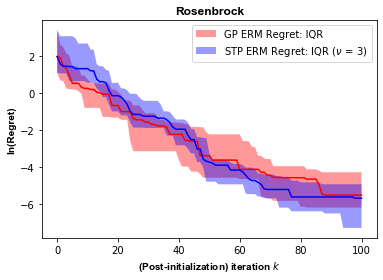

In [170]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_loser, color = 'Red')
plt.plot(median_winner, color = 'Blue')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_loser, upper_loser, facecolor = 'Red', alpha=0.4, label='GP ERM Regret: IQR')
plt.fill_between(xstar, lower_winner, upper_winner, facecolor = 'Blue', alpha=0.4, label='STP ERM Regret: IQR ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold', family = 'Arial')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold', family = 'Arial') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold', family = 'Arial') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise
